In [21]:
import numpy
#copied from the matlab by falsy winchnet.
#Emperical Fourier Decomposition technique

def segm_tec(f, N):
    locmax = numpy.zeros((f.size))
    for i in range(1, len(f) - 1):
        if ((f[i - 1] <= f[i]) and (f[i] > f[i + 1])):
            if (f[i] > 0):  # a value below 0 or 0 is not a maxima!
                locmax[i] = f[i]

    desc_sort_index = numpy.argsort(locmax)[::-1]
    desc_sort_bool = numpy.empty(desc_sort_index.shape[0], dtype=bool)
    for i in range(desc_sort_index.size):
        if locmax[i] > 0:
            desc_sort_bool[i] = True

    desc_sort_index = desc_sort_index[desc_sort_bool]

    if N != 0:  # keep the N-th highest maxima and their index
        if len(desc_sort_index) > N:
            desc_sort_index = desc_sort_index[0:N + 1]
        else:
            N = desc_sort_index.size
        desc_sort_index = numpy.sort(desc_sort_index)  # gotta sort them again
        bounds = numpy.empty(N+2, dtype=int)
        bounds[0] = 0
        bounds[1] = (numpy.argmin(f[0:desc_sort_index[0]]))  # -2
        for i in range(N - 2):
            bounds[i+2] = (desc_sort_index[i] + numpy.argmin(f[desc_sort_index[i]:desc_sort_index[i+1]]) - 1)
        bounds[-2] = (desc_sort_index[N] + numpy.argmin(f[desc_sort_index[N]:len(f)]) - 1)
        bounds[-1] = f.size
        cerf = desc_sort_index * numpy.pi / round(len(f))
    return numpy.asarray(bounds), cerf


#https://arxiv.org/pdf/2009.08047v2.pdf
def EFD(x: list[numpy.float64], N: int):
    #we will now implement the Empirical Fourier Decomposition
    x = numpy.asarray(x,dtype=numpy.float64)
    
    ff = numpy.fft.fft(x)
    #extract the boundaries of Fourier segments
    bounds,cerf = segm_tec(abs(ff[0:round(ff.size/2)]),N)
    print(bounds)
    # truncate the boundaries to [0,pi]
    bounds = bounds*numpy.pi/round(len(ff)/2)
    
    # extend the signal by miroring to deal with the boundaries
    l = round(len(x)/2)
    z = numpy.lib.pad(x,((round(len(x)/2)),round(len(x)/2)),'symmetric')
    
    ff = numpy.fft.fft(z)
    # obtain the boundaries in the extend f
    bound2 = numpy.ceil(bounds*round(len(ff)/2)/numpy.pi).astype(dtype=int)
    efd = numpy.zeros(((len(bound2)-1,len(x))),dtype=numpy.float64)
    ft = numpy.zeros((efd.shape[0],len(ff)),dtype=numpy.cdouble)
    # define an ideal functions and extract components
    for k in range(efd.shape[0]): 
        if bound2[k] == 0:
            ft[k,0:bound2[k+1]] = ff[0:bound2[k+1]]
            #ft[k,len(ff)+1-bound2[k+1]:len(ff)] = ff[len(ff)+1-bound2[k+1]:len(ff)]
            ft[k,-bound2[k+1]:len(ff)] = ff[-bound2[k+1]:len(ff)]

        else:
            ft[k,bound2[k]:bound2[k+1]] = ff[bound2[k]:bound2[k+1]]
            #ft[k,len(ff)+1-bound2[k+1]:len(ff)+1-bound2[k]] = ff[len(ff)+1-bound2[k+1]:len(ff)+1-bound2[k]]

            ft[k,-bound2[k+1]:-bound2[k]] = ff[-bound2[k+1]:-bound2[k]]
        rx =  numpy.real(numpy.fft.ifft(ft[k,:]))
        efd[k,:] = rx[l:-l]


    return efd,cerf,bounds

In [22]:
import base64
import numpy
from PIL import Image
from io import BytesIO
cameramantiff_base64 = "TU0AKgAA/WgLnJ+em56cn56dnp6f/qA4nqOhoqCkoKWjoaOhpKWioaWlpKalpKanpaWkqqanp6qoqaapp6qpqaupq6mrqqmtrayrrbCusLSz/7L+tQOxtLKz/rQYsri1tre2t7W2t7a5uLW1t7i3uLe6uru4t/65Iba3ura4u7m8ubm6uLi2urq5tbq2trm3tLW2tbm2ura1t7b+tRaztbG0tbKytLO0sbO0srCyrrGyrbGxsP6sDLCusa2tqaypq6enpqf9qAOppqml/qYTpKappqimpainqKWmpqSjpJ+kpJ7+ogGhn/+h/58RoJubmpuZnJuenJubnJqXnJuY/psEmZyamZf/mAWgmp2enZ/+niCgm5yfnqCdpZ+hnqKioaOfoqSjpKWppKOloaOlqKelpKP+qf+qAKn+qg6uqqirq6moqqmqqa2orK7/r/+wBbOxsrGxtf+0/7L+tWK0t7W1trS4trWztLa2t7WztbG4tri8ubm4tbi2ubi2trW4ubi5ubi7t7u8ubm0urW3uri1ubi3t7i5t7i3tLm3uLO1ta+1srSxtLW1srWvsLK0rrGvsK+vrq+vsq2uraqrqqn8qwGqq/+p/qgAp/6oB6eoq6qlrKqm/6n/qP+lK6mloqOmoKCinqGmoqChoKCen56boJygoJucm5qZnpucnpibm52cnZubmpuZC5yfnpuenJ+enZ6en/6gOJ6joaKgpKClo6GjoaSloqGlpaSmpaSmp6WlpKqmp6eqqKmmqaeqqamrqaupq6qpra2sq62wrrC0s/+y/rUDsbSys/60GLK4tba3tre1tre2ubi1tbe4t7i3urq7uLf+uSG2t7q2uLu5vLm5uri4trq6ubW6tra5t7S1trW5trq2tbe2/rUWs7WxtLWysrSztLGztLKwsq6xsq2xsbD+rAywrrGtramsqaunp6an/agDqaappf6mE6SmqaaopqWop6ilpqako6SfpKSe/qIBoZ//of+fEaCbm5qbmZybnpybm5yal5ybmP6bBJmcmpmX/5gFoJqdnp2f/p4goJucn56gnaWfoZ6ioqGjn6Kko6SlqaSjpaGjpainpaSj/qn/qgCp/qoOrqqoq6upqKqpqqmtqKyu/6//sAWzsbKxsbX/tP+y/rVitLe1tba0uLa1s7S2tre1s7WxuLa4vLm5uLW4trm4tra1uLm4ubm4u7e7vLm5tLq1t7q4tbm4t7e4ube4t7S5t7iztbWvtbK0sbS1tbK1r7CytK6xr7Cvr66vr7Ktrq2qq6qp/KsBqqv/qf6oAKf+qAenqKuqpayqpv+p/6j/pSuppaKjpqCgop6hpqKgoaCgnp+em6CcoKCbnJuamZ6bnJ6Ym5udnJ2bm5qbmSqcmZufn5ucm5udm5qanqKdnZ6dn6GgoZ2dnJ+goaSeoaOepKWloqCgpqmm/6T/pw6kqKSmqqaop6mlraamqKf+qv+tLK+srLOts7G0s7Kws6+yrbO0s7Kvs7O4trS4t7OzsrS1trm2ure4urq+u7m3uv63DLy5uri6u7y7vL64ubr+u/+5Bbu8u7q6uf+7/7kBurT/uf+4FbS3tLa4tra0t7aztLK1tLK0sLGxta//sPyvCKutr6qrqqmnqP+n/6kToaqnqaipp6unq6mqqaamqaanp6X9pA+jpKKipKWjoKOhoZ2hop6f/53/nP+bEJ+amZyYmpiZmp2WmZqXlpiZ/5f+mw+dnJ+YnpyemJmfnJ2hoJ6h/p8LoaKioKWgop+ko6Wk/qcIpKmmpqylpqmq/6n/qgurqqitqqqppq+nq6j+rCCurKyvsbCzsbGysbO0s7K0s7C3tra1trW1trq4tbm2tbf/uv63Dbu6u7y5trq4ubq5ur27/7r/vQ2+u76+vLq9vLu5u7m4u/+6/7v/twW7ubq2t7n/tv+3Arm2uP63Era3trWzsbW0sbGzr7S0sayxs7H/r/+uGKytrKipqKerqaqnqKyqqKmqqKuop6elp6b9pwuoqaampKOhoKGgo57/n/+i/54Anf+f/54DoJ6cnv+Z/5cAmP2ZCpeYmJaYmo6NlZaZLJyZnZyZm5qbnZybnJudnqCdoKGiop+hnpufoKKhnqOmpaGkp6WoqKqlpqipqP+p/6oApv6s/6r/q0ysq62rq6qtsLKvr7CvrrKytLOytrWztLW2sbO2t7W4uLa6ube5uLi2ubi8uLi6u7y8vry7u728u767vbu/try/v8C8vcC8vry7urm5uP68CL25t7e4ubm2uf66Abm4/rcXtrizuLa1tLOysLKxsLCxsrKwr7CurK2w/qwSraysqqajqaWqqaeoqainp6SmpP6lD6mmqKemqKelpaGjop+in6H+ov+fH5yen6CenZ6cnpybnZqZnJiblpeWnJqYmJqZl5SYlpiV/58QnJ6cn52hop2dn6Gco56foZ7+oxOdop+mo5+op6WiqKinq6qpp6qqq/6sEaqurKywrq2vq66usK+tsaywsf6yH7OysrGztLW3qra0rri0s7S0tba4ubW6uLW4tba4t7e4/7f/uwS6vbu+vP+7/7obt7y9u7y8u7y8u8C+vb+6vLu+vru+u7y8vry6uf67Fb65u7i7uri7ubS3tLW6uLe0tba2tbH/s/+0MrKws7CzsbCtqq6qq6yrqautqKWqp6uoqa2oqqupqKWqpKimo6anp6Wnp6SepKOeop6eof6fHqOem5qim52XnJ2bnJaam5eWmZWbk5iVk5WVkpaZk5b+kxuem56anKCim5+hnKGgm56hoqKho56cpaCkoKSh/qcLqKeqp6uuqaqrr6qr/qj/qw+uqq2tqqyrq7CvrayvrK22/6//sP+xCa+ws7KzsrOurLL9syqxtrK2t7W1s7W0s7WytLa1trS3t7a5t7q3t7W2t7m3uLi3ure6vrm6u7q5/rr+uf+6Abm2/rkuuLa0tba1tbO2tbK2tbK0srizsrautbGwsa6xsqeusa2trLGvra2qqaqmp6ivqaj/qv2oBKqoqqeo/qMDpaSkpf+p/6cuo6elo6Kfo6SgnaCdnpijnJuen52inJ+dm56dm5uWmJmbmJWamZiWnZeYk5qVlpMWm5qdnqCgn6CeoaCgnqGeoKKfo6Gcn57/n/+hTaKlo6Wnp6mkqaeopqaopaaop6mpq6irqKqsrKipqaqpqaqsrq+tra6rrq+tr7Kur7Cwsa6wsLKwsrK0srS1tLK0sLG0s7GztLSzt7i1s/64Cbm1tLe2s7i2t7b+uRi4u725u7q8uLm4uLe4ubq5uri3tra5trW0/7X/tA6ztbS0sba0tLW0tbOysrP/sf6yCLGsrq6trK2srf6uLqiqpqmmpqSmqKeoqaunqaWnpqOkpqKip6KjqKampaekoqSjnp+eo6Cgn56foaCd/ZoWm5ydnJeZmpqcmpqWmZWZlJaVmJaUl5kAmv6dHpybn5qfnqGenqCfoKGfnaCin6Ggn6ChoqGkoqenqKn/p/+pFaapp6ippqaoqauqqKipqq2tp6qqrqr/rv+s/6v/rB+tr6yvrLGvrq+wsa+wr7GvsLCysbOysbO0srCzsrWztf+z/7b/txy4tLW2tbaztrW6t7a4ubq8ure2ubm3tLa1trm4t/64UrK2uLSzsraxtbOzsK+ys7O2tLeztLOzsbKvsLOwsrGysK2wrq+usKyvraqtrqqop6mtqKeoqaqrrKeoqaWspqemqKalo6imqKekpqOlo6Ohnp+c/qAPoaKeo56dnZyemp6Zm5qYm/2a/5kImpaXmZaZlpqbXpiWm5qYnJ2cnZqdn5ucn6CdoJyfnZ+goJ6gnqKjo6ejp6GmpailpaOkoaWkpaOoqKWqrKelqaarqaeqq6uoqbGsq6quq6uusrCtr66ur7GysLGwsK6tsrGytLS2sba3/rZBtLe1tra5t7e5t7q4ure5t7q5t7q1tbu9u769ubu7vLa7vLe3vbq+vrq4vbm6uru5t7i0ubW3ube4u7i4t7m3uLS4/7X/tA2xs7avsbCzsq+yrrGvrP+r/6oEramrqqj/q/+pHqemqKerqKulpaanrKaoqaSqqaSmqKagoZ+fo6Ghn6D+oRqen56dmpycm5+Zm5+WmpqZmpyZnpianZibmZQOnZmcm52goJ2fn6ChoKCe/6P/oP+iIJ6ioqOho6WopqWoqaatqKipp6mnpKeppqqora2sqKqtrv6sZq2uq62urq2vrbGxr66rrq6vrrCwsbCzsrKws7WytLC0t7G0uLe1t7K3tre4t7e2u7i3u7+4u7q2trm4uLm6vLq8u7q7ube6u7q7uru6ubu7urm4u7m7vLa4ubm2t723urm7t7q4ubj9tf+2BrS1tbK1tLP/sv+x/q82sKyrrKyqsKupqqqprKqsrKupqKqrp6mnqKmmqqappqmjq6qlpaalpKOjoKKinKSgoaCgnpubmf6cEZmdnJeamp2bmJmYmZuYmJqelwKXmp3/nP+eI5ydn56cn6GfoKGgoZ+koaOkoaSfpKalpKenpaqnqaiqqKiqqP6pC6itq7Ctq62sra6rrf+s/64Wr7CzsLGsrrCrrq6wsbGws7Cxs7K1sLL/tP+1Hbezt7a0s7a1tLW5t7i5u7m7ure4t7m7urm4tre7uv67C7i6u7u4t7q5u7u6vP65ELi8ubi4t7u0uLi2uLa3t7m3/bgWsre0s7SwtLOwsrCusbCwr7CysLGurq/+qiippqioqainp6iqqainqKmlpaSopp2mpKakpaWmpaShpaSjpKGhoJ2go/6hEZ+cnp6dnJ2enpqem5qYmpqXnP6ZBJiVl5aX/5QknJ2doJ+fnJ6foqGgoKGipJ+hpaWjp6SjpKOmqaaqp6emp6uvqv6sH6moqKyrq6qrq6yqq66wrqyqrqqrrq6yrayvsa+vrq2v/rEurrG0sLG0sbKxsrSytba1uLW2s7S1tra4tri3t7a5ubi6uri7s7q0tri3tby5ubr9uQO4ure5/7b+uAi5uLu4u7m4trj+thy6ubW2s7e3tLe2tLW0tLWusrOxrrCurrGtrquwrf6sJ6+yrKmoqaimp6appKWqqqelqKajqaalpKejo6Sjo6Slo6KipKOhoKH/nv+h/6Aen5ygn5yfnpyYm5yfmpualJmXmpibmpqWmZeSmJiVlg+dnp+dnZqZnp+boJ+hoZ+g/aT/piKhpqGlpKajoKamp6qsqqmtqaqqq6ivqqmoramsrLGqrayrsf6vB7Crq7a6srKs/q8CsbCu/rEGsq+vsbCys/61/rRjtbi0tLW2t7S0sre0tra3urWytre4uLK0tbi2tri5uba6tLa2tba1ubS2tri1s7a0t7a1tLOutLC0tLGwsbO0sLWysbK2sLOxsq+sra6wrayurK+tqautramqqbKnqaalqKOnpP+m/6kKpqiopaimp6Smoqb+pxurp6OnpaalpKKnpqSloKGhoqOeo6Ggn56fn5ye/p8QnKCYm5qdnZybn5ubmJaXmZz/mg2cnZ6fnaCenpydnZ+gnv6gBKGkpKCh/qAJn6Gjpqenq6mop/6oPKaop6aop6qoq6upq6qtq6ypq6qtqqqusK2vra2sra6ysq+xr7KvtLGzsba0srS1trWxtrSzt7O3s7e2trr/tv+3A7a5trj+tv+3ALj+t/+5CLe7vLq6ubi1uf+1/7cctrezuLa5trS3tra3tLS1srS0srO0tLaytLK2tLH+siivsK6ur66tr66rq62rq62rsa2qqqeop6iorKeoqKuoq6unpaSpp6amp/6mFKSnpqWnoqOjoqSloqOgoaGioKCfo/+h/Z4Hq5+bnZuZm5r+mwaanZqYmZea/5hOl5mdmJycm5ydnZudoJ2co6OhoqKkoqKhpaWkoaSjqKWnqKeoqKSpp6yoqqaqpqusrK2srLGqrqysr6mrsKyusbCxr6+ur7Cvr7Cyr7Kwtf2yULSzt7e0tbSztbSytbO0tLa4s7a2tLa4t7y4ubi2t7W4tbe5ubi6uLy6u7q6uLe3trm0treyt7e2tbSzs7W3s7O1s7O1trezs7iws7S0s7Kysf6wMrKur7Gurq+ura+sq62ssayqqaqmqqiqqKmopqutrKqoq6mpp6akqKWkqKipp6impKSjpP6jIqSioqOhoKGgoqKhoqCcnaCcn52cmJuYnZydn52bmpuWmJeYDZmbmpmcm5mbmZuanJuZ/5//ogKeoaL+oH+fnaCdnqOjpaKkqKekp6akpKWnp6mmpamoqq2trqytq66qrq+vqq6vra6xr7CwtLOztK+0tLK1trO0sbSytbS2trm2tLe6t7W5urm2sre6vL26v7i6vLu8vr+7vr2+vry9vL+6vru9u7i4uri7uru7tru6urm3tbm3tri2urW4uQS2ubS3uP61FbGytK+wsrazrrG3ra+yr7CusK6rrqv/qv+sQ6ulqKmtqqymqKurqaqqqKmnqKalqKmnpqenpqempKWnpaajpKShpKamo6Sjn6KfoZucnZ6gm52bn5ufm56cn5mdmZqd/5slmJqYnJ+anJuhnZ2hoJ+ioaGipaOgoqOlp6GfpKOiqKeqqaupqar+qQinqqitqq2qqK7+rRWusLOxr7GusrCwr7O0sLKzs7G1s7O1/7T/sheztLaxtLWztra0uLW6tbq1uLe3ube4uLf+uRO8vbu8ur64v7y6vLm8uru7ucC9vPy5Bry6ubq7uLv7uRW3tra4u7q6uLe3tbaxtLexsLO1s7Oy/7P/rRWxr62uoamurairq62qp6mqqqakrKiq/qcYq6apqaaqo6WkpaWnpaSmpqOmpaOjpqOgo/6gA6GgoZ7+of+fDZyXmpmbmpqZnJqdm5qe/psEmZiXmZr/lwWanZucnZr8nhqioJ+goaCjo6GkoZ+io6GkoqKmo6aopqeopqX+pwuppqmoqKutrK6ssK7+sP+vA66rsq/+sQavsbOzsrGz/rL/sxqxs7SytLKzsrO3trS1uLS4tre5uLu3trm5urX/uf+7Jb25ubq3uLe5uLm6t7q3vLe6u7m3uLe2ube6trW4t7i1t7m2trKz/rT/sQCv/7T/sgy1sLOxsrGusK+ur7Cu/63/rB6ura2sqqmrqqunqaaqp6emp6apqKipqKippqqopKan/aUiqaelp6emo6GgpKCjoqGgpKKioaCdn6Cgm5qem5qcmZqYnZz/m/+cCJ6cnZqZlpqXm3+bmZubn6CfoZ6foKGfn6KhoqSjpKKio6CjoaWopKakpamopKmoqquspqinqaioqq6tr62tr62sra6vrrCusK6qsa6yrbKwsrGwr7O1srOyr7CytLGxsrazs7S3tLW3uLe5t7m4t7m5s7u6uLm9u7u6t7q1u7u4t7m5t7i5t7i3uCa6t7O5tre2t7q3s7m6trm4s7S2srSzsri0tLK0sLSxta+usLCtrq3+rgasrausr62r/6z+qAWppqmmpqj+pBGlpqimp6alqKmmo6eipqOko6L/o/+kCKOlo6GcnqKhnP6gHp+gnZ+foJybnpyanJyYnZecm5yanJuem5ydnJuamZb/lyGZm5mcm5udnJ2coKCdoKOjoKSioqSgpKKloqOhpaWmqKao/qcHpqSqpaekqKf+qf+q/6w/q6ytrKquq6ytq6utrqitsLGzsa62sa2vrq6yrrOvs7K1sLWwuLW2tba3tLa1t7a2tbm0t7S1uLm5vLe5uLi2tf+3/7YcuLe4uLG2t7i2tbW0tra5uLe4ube1uLi1tLKyr7X/tv+xHLOxs7GxtbKysbKuq7Cxs6uyrK6srqmpq62prKaq/6j/qxenpaqpp6uprKerqKelq6Opp6mmqqWjp6P/pv+i/6UNoaOioqWioaSioaOjn6L+nxShn6Kgn5+gl52cnZ6goqCjoJ2cn5wMlpebmpuanJienZ6fm/2fLaKhnKChoKGgoJ2eoaCio6WipKSgpqOmpqmopqekqqmrqqarqqyoqaurqayqqar+rQusrbCorq2sq66uq6//sP+xLa6vsLO1s7S2tri0s7q2s7a3tLe3tr24urm6urm6vbm4u7u5ury7ubq3ubi7urv/uf+6Drm7ubu6u7y7uLm5uri3uP+3/7j/tv+1DrS2s7Syr7O0s7KvsrOysf+w/68MrbCvrbCrraeqp6utp/+p/6j/pg2lq6qnqaeopqqopqappP+m/6UVpKWjnqSjoqSgn6GdnqKfoaKhnKGenf+e/58QmJyaoZ2fnp6inp6dm5manpv/nQiZmpebmpmbnZ79nf+hPpyenqCcnp+goZ+foKOipKSipKaioaOpqKenpqSppKaoqKepqqenqaysraqsqqqrramsrK6tsKyrrq2vrq2vrv6w/68YsLSysbK0tbO0s7O2tLK1uba5tLO2ubm3uf+7/7oCubu5/7r+uTy7urm4vLy7vLm4vLm8vLu9urq7uby8uby6trm3tre2t7m3tLeztLWzs7SysrGyrrGzsbOvrq+qrq+trKyt/6n+qv6oOqqpqqWnqaulpaepqKirpqalpqKmpKSioaSkpqCioaKjoqKgn56ioJ+fnqCfnZyanJybmpibnJybnpmX/Z0Dmpibmf+aSpucm5ybnJ6an6GgnZ2gop6inaKio6Kin6Gjo6KepaamqKWiqKqnpaanpKapqK2lqqyrqaitrq2sqK6tqqyuq66srK6zsbGwr6ywrf6yHK+1s7C2tbS2tbW2t7S2t7i5t7a3u7y8urW7trq8/rsXvbu9ury9vLu9vr67vbu/vby8u7y+v769/r4Fu7y6vL/A/73/vA+7t7m2try5trW2trG1sbSy/7H/sAuxsLGus62wr7Gtr6r+qzGtq6ump6qnpaemqaepqKiuqaaoqKanpqelpqGeoaSjpKKhoKWjn6OhoJ6fnZyfnKCcov6dEp+anJqemJmgm52cl5eWmpmZmJs1op2bmpybnJ2boZ2hoqOioaOon6Omo6ShoqOlpqWkpqWpqqisqaunrKuop6ipraytrK2tr66s/q81q6+prqysr7Csra+trrGwsK+wsbCwsbK1sLCxtraytq64t7a0ubKztLSzurq1ube5vLvAubq9/rs/vby7vb+7vby/vb++vb2+ubq8ub67vry+vbu+vb2+ury5u7q6ube6t7m4tbe1tbK0s6+vsrGzr7Cwsa6rqqqsq/6qAqiqpv+o/6c+pqmnpqKoqKmnpaampaOopKakpqWnpqGgoqGgoaCfnZ6dn5+dnp6doKCanpucmpuZmZibmpmcnZuemZual5eY/5f/mACXIp6bnJ2gnZ2inaCeo6KfoKKio6GloaSmoqShp6SkqaSnpqin/akCqqmn/qwQrq+ura2ura2wrrOyrqyvra7/rP+t/q4FrLGxrq+t/a8Ds7CxsP6zBrSxtLe0s7T+sgu0tba3tba3uLq4urj+uQG8uf+7/7pWu7q6vL+9vru7vLq5uLe6uri5urm8uLu9ubu6ubu5t7i0t7W3uLe1tLWysLSxsrKxsLGysLKura2ur62tqK2qrKaqpqurp6mlqKimpaWpqK2oqamopqan/6T/oxaloaSgoaKkoZ+inaCgoZ6joJ+fnZ6boP6cFZqdn5ebmJ+bmpuYmp2Xmpibl5iam5oUoZ2enZ+cnJ2gn6Kfop2jpaKjpaKh/qUKoqOlpqakpqerpaj9qQqrqKqsr62rq66pq/6uILKvrK2rrK2trK+urK6wqbCusa2srrGur7GxsrGxtLW1s/60E7eys7OytrS3tri4t7a3uLq2ubq5/roHtrm6uru6u7r+vAC9/7v+vTa5t7e6vLu5ub66ury4uri5u7m6uLq3tbm3tLO6trW2tbSzs7GwrrCysLOws66wrrGssLCsrqyo/qtEqqyoqKmop6mmq6moqqOoqKelpaelpqSlo6SgpaChoZ2eo6CjpJ6foKKen5menZ2bnJ6bnJuem52ZnZmdnZibm5mcmpeZB56fo52em6Of/57/ohWhpKOmoqaepaWopKKkpaSipaGipKKn/6b/qTqnqKiqraipq6qosKmmramtsK6qq6qwrK2rr6qprayurauprK+tsKyrrrOur6yrrrC1s7OvsrCwsbKys/2y/bUEtLKzs7b+twW6vLW4trr/uP+5Db64ubm2tLW2tre2ubq5/bj/uv+5ELq5t7m4vLS3uLO7t7O1srOw/rEEs7SzsrP9sROvsrOzr66rr6urrKuurayrqKiqq/+q/qkIqKqoqKKqqqWn/6T/philoqaioaKln6ChnqCioaGfoqOhoaCan5ic/57+mw2dmpadm5ybmJibmpSbnP+a/5xen5ucn52fn52eoqSioaSioaOkpKOio6SioqOlpKeppqenpayqqaqnq6quq6utrKuqsK2wq66ssK2srK2urK6wsq6ytK6xrLCxs7Ows7G0tbCztLKwsrS2tbG0srO1srX/tv+3DLq1ubm6ubq7u7y9u777vAu9u729ubq3ure6uLn/uv+5/7wxu7y7vbu6ubm4t7u6ure0tbi3trm2tbi3tbG1s7KzsbK2srO1srGyr7Cur62vraupqqz+qTmtqquvqamop6mlramnp6mnpaWmpKKloKCfo6KioJyfoKOdoZ+inp6do5ucnJudmZybmpqZm5yZnJya/pkBm5QMmJubnJ6bnaChnqGhoP6h/6I2oaOlpKWlpKalpaelpqanqqupqaesqqqurKuqra2qq62rrrGtsK6vrLCtrK2wrK2usbOws7GvsP6yGayyrrCus7O0srS1tLe2sbS0s7G0tbK2tre4/7f+tha8uLq5vbi4ubq9vbq5urq8uLi5u7q4tP+3/7kRuLm4t7i6u7m6u7u6ubi5t7e5/rcItLaxtLiztLSw/rQjsbKxsa+ysK+xsK+zrrGvrqyrrKqrrKqtqqisqKmnqaypqqap/qcdpKamp6Slo6Kko5+ioJ6gm6CdnZ6dn6CenJygnZqY/5r/lwSamJmXmP6XB5uWl5iWmJaTEpqbnJucmqCanKCdoaGfoqGho6H+ojujpaSnqaapo6mnqqiqqqWsqayrq62rrKyvrKytr66vrLGxr7Sys7GsrLGwr7CxsrGztbGxsLKysbCysrX+tDW3trWztbS1uLe1tra1tri5uLW3ubu4t726ubq8ur29u7y6vLm6uru6ubq4trm1uLm3s7W0uLb+uP+6Cri5tri3tra4tre4/7X/s/+1XrKxtLKxsa+wsLKwra+0r7KxrquqsK2rqq2sra6tq6yqqaqop6imp6iopqSopaSjpqSmpKeio6Gho5+eoqGcnp+cnKGenp2boJeYnpmWmZmamZmam5uYmpqZl5aWl5WZGZueoJufoJyeoqSio6WlpqKepqekqaOrq6ip/qooqaqqq6yuraqor6y0rbCxsq+tq6+wr62wr7OysLKxs7CzsbKzsq+ztLf/sv6z/7EQr7CztLe2tba3t7W2tLO2ubX/uf66MLi7ube9ubi6vru6vb+7vrvAvru8vLq7u7i8uLm3u7i2tba3tba1srO6t7W3tbm2uLT+tj64tLS3tri1t7S3tLSysbKys7Kvrq6wsbKyr6qwrq2sqq6qq6qtq6ipqq6qpKmpqKamp6aqqKGmpaanoZ6io6T/n/+gCZ6dnZuanJ+Zn53+nBCbnp2XmpiXmJeWlJmWmJibl/6YBJaYlZaZAZ+e/53/oBqenZ6ioaGmo6Kko6WioaShp6Slpqmrqqepp6n/rP+rAKj+rBSqr62ur7CwrLCxta+ys7CwrbCwr67+r2SzsrOxsbW0sLCytLGxsrS1tbG3srK2r7G2tbK3trW1trm2t725u7u6u7u8vrm9v769vbu6ur63uLa7tbe4tbW3tLa1tbK0tbWytbW2s7aztbq0s7O2tLKxtbOztLKzsbaysbOwrf6wA6+wsa//rv+v/qwAq/+t/7D+rQWsqqyqq6r+qf+lFqipp6anpaekpKWjo6Wmo6GhoqOioKOh/p//oByfoJ6coJqdmpmempmZl5mbnJmZmp2am5qWlpqYmUybnpyen52cnp+goqKfoaCho6KkpKOkpKalpqalpqemqKWpp6irqqyrrK2srLCtr7Gwrq6wr7Cxr66ysLCtsK6yrrGwtLKyr7KwsrOysP6zBbS1srewr/20DrK1t7K1tba4t7m5u7m9uv69/sEPw8HAwb2/vr+7vru6t7q4uf63GrS5tbK1tLK2s7W4t7W5tbeztLK3tbKztbS1tP6z/7EmsK2ura+vrq+wsbGurK6trK6pqa6trK2rra2spauoq6itqaumqKip/6j/pgWlpKekpqX9owiho56koKOipJ//of+fCp2hmqCdnpqYmpea/ZkCl56c/5v/nQWcmJiXlpcBnJ//nf+aEJ+gn56in5+goaSjpKWhoqKm/qUaoqeopaWopKypq6ipqaqsra2rra2urLCsrLCu/7D9rXCvra6tr7KwsrOxsauwr7OysLCusbCysbGzsbS1s7K2s7i3s7e2tLe4u7a4u725vrzBx8a9uMDEx8TGwsDBv8G8vb27vrm5ure4trS2tbK1tLa3tbazt7Wzt7O4tbO2srWxtrSzsrO1sbK0srWws7Gzr/6wFa+sra+sqa6rrq2rrK6qra2rp6yqran+qwCs/6j/qgGjpf+m/6kBpKb9pP+g/6EDpp+iof+j/6H/oAahn56inpyX/Jv/nf+a/50GnJqbm5yZmDmYnJaZm5+ZnpyhnaGen52io6Cio6SenaKhpaWno6WjpqWoq6yrrqitrqqtqa+rrq+qsK6wra6xsK+u/rAfsbOwtLSysbG1sbGvsLSys7O1t7exubayt7i6uba4uLn+tyK6t7a1ur69w7+7opx0Hg8OEhtBb4qbt8HIx8TDwb/Cvb27uP65ILe4t7e6ubq7t7m3t7W5tbazsbW0tLWxtrS0s7Gzsq+wsv6wCrKur7Cvra2rr6iq/67/rQ2rra2qqKumo6irqKirqP6n/6YEqKaoqab/pf+m/6QSoqSgo6GeoKGinZ+eoZ+fnp2gnP2aEZmanJqYmZmWmpWWm5WYl5WUlxibnJmZnpyfoJ2fo5ujop2joqajo6WopKel/6f/qR2mqamoqaypq6mrrLCtr62vra6vsa6vr62xsrOxtK/8szG0tbe1sra1trC2t7KytrW2tbi0tbS3tbe2uLm2u7i5ubq5uL/A0cPGqGYxFg8LCgoLDf8L/wwYDyJHfrfHw8DAvry6vLq9urq4ubm6uLe3uf62Gbi1ubS3tLO1s7O2tbKztLOzsrCzqq+tr7Ku/a//rBmvrKyqqaisq6mpq6imp6ipqKmpp6mmqKWip/6mMKWjpqWnoqKloqOhoJ+dnZqbnp2cmJqbnZ2anJqam5mYlpaXmZmalZiZl5iYlZKXlZMLoJ6dnJ6dnJ6doZ+g/qEUpaGjoKKioaKkp6Snp6qpp6ynq6qr/6z/qzisrqysra6wsbCyr7Kzr62xsrKzr7OxsLGztLW0sra4tLO3tbW0s7aztbi3tbe4uLe1uLq4t7q5u7z+uwnCxa1NGRMTGhEL+goAC/0KKBeUx8O/vb28uby4uLm3trm3tra3tbW2tbOzsLaytbSzsba0s7W0sbSv/rAWq7GsrKuyrKyiq66wrauuqq6rp6utqar8qCCpqqepp6iopaimo6Wop6WjpaKkpJ6hoZ+hop+eoJ+dnpn/nf+ZGJuZm5ebmJmcl5iXmpaZlpiWlpuWmJaYmJU7nZygoJ6foaSipKSmn6CjoqSlpKampKKip6msq6israqsqq2rq6qurKmusK+ysa2ws7GwsbG1s7GzsrK3/q9Nsrext7a1t7W4trS3sbS1t7a0t7e2tLe5tbi8tbm1vLu5u767vr+eJQ8OFBQPDAsLCgsKCwsMCwwLCwwLDl2yuL3BvLu3urq5tbq2t7W5/bUStre3trOxsreztLWztLOzsLGzsP+t/68Xq66ns7CssKyvrKytp6qrqquqqKiqqaSo/6v+pxeopqSjqaalpKWkoaKfn6OkoaSgnKCeoJ7/m/+eHpuanJybmZ2bl5uXmJyXmZeYmJeZmZaanZeUmpOXkpj+nQWhoKGgoaL+owCk/6X/pBGjpKWlo6WmqamqrKmrqqmrrKn+qg6rrquyrq+qsK6vr6yxrbH/sv6vHa6wsK+wsLGyr6+zsbSwsrWxr7GyvrO1tbSztbS0tv60F7W0tba3uru2tH8gEA0QDgwNCw4LDAwKC/wK/wv+ChISiaO1uLe4tri4trW0tbW3tre4/7P/tA6ysbOxsrO2s7KvsrO0srH+ryCwr6yvrqytq62trK+vqK+tqKmqqaiqqaarqqqpqqqpqKb/qP+kCqmnp6ilp6KkoqSh/aIJnqKdoKGgmp+cm/+f/5wMnZyZmpeamJuYl5mZmv6YB5SYlJmWlpWXFJucnZ6dnJ6eoKKjo52hoaCfoqGio/6kAKf/pv+o/qf/qAWprKyrqq3/q/6uF7Cur7GvraywsbCyr66wsbCwr7SzsK+xtP6yTbSysq+ys7uxs7GztLW1t7i3tbm1t7O1t7q4uqxkFA0PEg0SDg8KDAsRCwwPDAsKCwoMCgkKChVsqZegjLC7ubi3uLayt7e1ura3t7W0t/60/7MPtLWwtLKvsbKwr62rq6+ysf+s/60BrK3+rh6qrKmrqamrqKepqqirqaqoqaqop6upp6emp6SlpKOk/aP/ogqgop2fn6Cfnp6fnf6fBJyenJ2c/5j/mQ+YmZial5WWl5iYlpmUl5eYRqCcnqOdnZygoqChop6hpaOkoqGkoqakpaWjq6eqp6ekqqirp6qoq6qsq6yrrK2sra2wrq6xrq6vra6srLKusLGutLCvsrCy/rEus66zs7GwsLOxtbKytba2sLW0t7S0uLu6vrt/Eg4PDgwKCwsKCwoLCwwLDg0LCgz+Df4KDhVmpJpkbbu5u7u5uLq4t/+5/7gJt7a2tLW2tba1uP61LK6zsrazsbKzsLCxsrCws6+wra6xr62sq6utr6ysqa6sraqrqKeoq6eqqamnqP6mBKWpoqSp/qUopKKgoqCioZufnp6gnJyinJ2el5yWlZmamZiWmJaYmpaVlZiZlpWZmJYomZ+cnqCdop+hoqKfo6GfpqSinaOmp6ejqaelqKuspaqrraioqa+rrLD+q/6vKLCusa+ysbKysLOzsrCyrrWxrbaztbaztbmztLKztbO0s7a2tLa3ubq5/rgEure4ubj/vf/AA5QQDwv/CvwJCQoLDgwKDA8LCwz/Df8M/wkuCgtvjXI0qLe9urm1uLu9u7i3uLm5t7m2tLS2ubq3t7O3t7S2sbCysbKztLCyr7L+sQqusK2vq6qurayvrP+u/az/qjurqairraaoqamlp6emp6SjoqSioKGjn6KhoKKenZ6cnpyhnp2amZiYlZiYlpWYlJibl5eYk5aWkpiXlpgDnqCgo/+f/qARo6KhpqGio6amqKWopqimqKao/qkLqqyqq6itqq6qrq2s/a83oK+wsLKxr7OvsLG0r7SysLKxsrOztrGxtLGztLOzr7Czs7W2trS1trW0t7e4tre5uby/wMO1JQ38Cv4JBAoLDhAL/goCDA0Q/gw7DQoJCgoLNjwqbKa7uLm3ur24uby4uLWytba2tba1s7S1sraztLOysbGysK6xsLOysa6trautrK2tp6qp/6v/qQmrqquprKqoqK2o/6T+pRmjoqWho6GjoaGio6CjnaGfnp+dmZ2cnpycnf+c/5kBl5j/l/+VEJaYmJaXlpaUlZWXlpmTlJSVJ5+jpaCgoqakpqShqaOlpZ6kpqWpqaisp6eoq6qqqayurauqrq+vsK7/rf+vAKv/rv+v/7ADr7Gys/+y/rUJsLWysrW0s7aztv60HLa3trCzs7CytLW1s7e4tLW4ubi2t7i5ub3CNg4L/goDCQgJCP4JDgsQDw0KCg0RCwsNCwwQCv8J/woiER02ebe3ubi4t7a2t7W5t7e2srW0tLWxtbS1tbKzsq+wtLH/sv+w/7EbrrKwtK+vsLGsraqqqa+qqaypqaytq6msq6enqP+n/6b/pRCjqKamo6Glo6GioqOlnqCgnP+e/53/nhqfm5qZnJqYmpeUlpaYl5mYlpeWmJmclpGUlpgpoqCgo6Cjpaalpqalo6OlqKKoqaeoqKuqqaytq6uurKyrrayura6wrbGw/67/sTausbKwtK20sbOxs7Cyt7CysrOwsre2tLS3tri2tLSwtbi0tbK0s7u7tbe0t7i6uLq4u8DCjBMQ/wv/CvwJ/woODA0MEQ0MDw0MDhMNCw8N/wv+CgYRIEmzuLa6/rYmtLizs7K0tbW0tbSytLOysrSvsrGxsq+yr6+xsK+vrK2vrq6sra2v/qkUrKepqaeop6qoq6mqpqenpaOopKWm/qIvo6SmpqSgo6KhoJubnJ6boZ2gm52cnZ6Zl5qZmJaYm5eZmJaVmZiYlZialpeRl5eUCp2gnKKgoKSioqOl/qb/qC+ppKakp6aqpKmppqunq6iop6mrq62sqqyyq62tq66urK6vr7KvsbKxsq+wsbKusK/+sAyxsrK0srGytLGvsLOw/rEQsLO2s7S0tbaysbe2trvAWAz/C/4K/AlsCgsMDAsKCwwNCgsMCg0LCgkKCwoJCQwXN4+5uLS2uba4tLiztbW0trWwsrSxsLKztLKxsLKvtKy1rq+wsq6vsLCssbKvra6tq6qorqqqrK2srqWpqauqq6inraeqqaikp6SopaKkpaGkoKCjn/+i/qD+ng+dnJ2bnZ2alpiYlZmZmJSX/ZkImJmXmJeVl5mV/qAHoaCgo6CgoaL/of+j/6UDpKWmqP6lNqSlqaWnqaamqautqqqprquqqq+yr6yvsbGurLCvsbSys7Sys7Cvs66wsLKzs7W4tbSztbOztLL/tP+zALD/tP61CbO0trS3uri8wiX/CvoJ/wgACf8K/wkGCwwLCgsOCf8K/wn/CBUKCwsKDA0bRay5uba1t7e4tra0tbK3/bQUs7WzsLOxsrSxsLSws7KxsrKwsa+w/q8Prqyura2rrKutqqmqq6qsq/6s/6kBqqj+qf6oKaSooqOjpaOhpKCin6GfnZ+cnJ6cm5ucmpyYl5mXl5WXlpqYl5mVl5WXmP+Z/5YClZmTBaKgoaGgn/6gDKGlpqSmpqSlpKinpaP+pP+o/6Ycp6amp6utqaytrauxrqmtrq+wr7Cvr7OusrCytbP+shCxsLKytLO3tLW4tLO2tbaztv6yArW0s/+0/7YKuba3t7S3t7u+tRHzCQMKCwsN/gsACf8I/QkACP4KOA0JCwoSnLi5u7e3ure0trW0sri4trK1s7K1sbS2tLKysbCwtLCxsLCvsrCur7Cwq6+wrqupqqutq/6qAqyrrP+r/6o5qaqmp6qkp6inpqejpaOlpaCio6Cjn6Cfnp6anpudnpqdmpiampaXmpaYl5KUlJWSlZaSlpeWlZWUlQOfoZyj/qEVo6WjpaSkpqqjpqSnp6WpqKilqq2rqf+u/6sqraurrq+yrbCwrrCvs7Gws7Gws7Svsre1tLK2ubW2ubO3tba2uLm4tri2uP+1/7YLuLW2uLa4ubi2t7m4/7v/uQjAjQwKCgkKCQr7CQUKDQsLDAv/DP8K+gkhCgkJCgsLChuZt7a7tLy5trq2t7Gzt7W1s7S1tLK1s7Kzsv+0/7AGsbCwra6vsP+u/q8Arf+s/6/+qgevqq6sqa2usP+o/6r9qAypqKeoqKWjoqSioqSf/qIloJuinqKeoZqbmZuanJiZk5eXlpeZlJWSmJaUlJeSkJGWmJeSko8poKGkpaKhoqOkpaOmqKmqp6qoqqqppqqqpayrqqyurKitrK2qq66xrrCs/6//sQ+trLCwr62zs7KwsrOytrSx/7P+tQS4t7i2uv+4/rUCuLW2/rURt7a2uLq6vbe5ury9wMlkCwoJ/Qr7CQYKCwwMDQsK+gn+Cv0J/wooCTmhr7m2uLi3trO3tLS1sbKxsbOxsbKxrrCwr7Cxrq+xrqytrKytsKz/rf+pDK2qqqyrq6mqqamopaj/pv+l/Kb+pBClo6OkoaCkoaKlpaGen5+doP6dGqCbm5mampuZmpSVlZSWlJWUlJaSlpWWlpGVk/+S/5MAlwqloaSioqSipaKop/6lAaql/qkeqKqqrqinqaupq62sq6+ssK+ur6yyrrCtrbGtrq+xrv6xDbKxsq+xsrXHt7Sxs7Wz/rURtrW2t7S1t7S0uLW2trW4s7m2/7r+uQW7uMDCbgv8Cv8JAAr6Cf0KAQsK/gkFCgsMEBIK/gkKCgkMc6i4uby4t7n/tv+zCbWztLOzsrCxsq//sP+xXrCtsbCurK2urK+sr62trK+sraysqauoq6qqq6mpqqmnp6alpqSnpKWkqKejpaOioaKkoqKko6OfoaCenqGfnpubn5ubmZycmpeWl5eYlJaak5WYmJaYmZWUkpSTkpCU/6EUpaCgo6Slo6Snqqepq6mpq6Wnqqin/qkKpayrrK+trq+tr63/r/6uEayusa6trrCzsLGwsrCxs7Wysf60FLK1srK1srW0t7W2tLW1srGzs7K1s/62ALn/t/+5Bbe6ur/DX/8L+wr8Cf8KAQsK/wv8Cj4LChAaO0UQCgsJCgoobF1SVF58orS0trG1trGysbKxsa+us66xrrOxr66tsK2sraysrqysr66tqKupqKapqqn+p/+oBqaop6Snpaf+phOlo6KnpqSlpKWhoqGgop+goJ6ln/6gFJ6foJmcnZyempiam5mYnZeYmZSWmP6WCJeYmJSWlpKUlQGlov6g/6JBpaelqqOkpammq6aoqKqnqaqpq6Woq6qmrKusr6qtrq6rraytrayrrqyzsa6wpLGytLGxsLOwsLG0tbK0rrO0rrO4/bIVtLCxs6+ytLa6s7W1t7W3tba9vicMCv8J/gr+CQMKCREQ/goACfwKHwsQGzE+WYaTIgwLDw8SFUqJWUlsqrd+sLW0t7K3tbO2/rT/sQaztLSysbKz/rABrrH+rlOwrq+vrq2vqqytqKqpq6msp6qpq6irqqmlo6aqqaWmqKanpKGmo56jpqSlpKCfpJ6gnqCan5uenZqfn5mbmZuampabl5uWmZiXlpmYlZWXmJOUlpH/oQ+joqKjpp+lpqioqqSpqKqm/6r/qQWmqKepqaz+qx2sq6+sqquura6trq6wr62trrGwsa+zr7O3srSzsbP/tf+zILe1t7e1tLa1trW1tLO1tLO1tLO1t7e5ure4ubm8vnULCvgJBAo4ZFgZ/wr/Cf4KIQsUK22ZoqWvq24WL0knDykcHiMrNTE3gX2nuLe3s7W1trf+swS0tbGxsv+x/7AGr62ssa6wrv2vC6ypr6qsqq2pqqmrqP+q/6kTpqeqqaanp6Spo6enpqempaWhoqT/pf+iCaGgoaKfn56gnJ//nv+fCqCbl5yamJiXlZeY/ZcKlpial5eZlpOWl5FFoKGdn6GgoaGipKanqaiqqKWmqaqnp6Wnq6iuq6epq6yrqaywrbCsraurrq+usK2ysLGysrGwsrKzsre1sba0srS2sra2uP61Cra0tre2t7a5t7O1/bkLure5uLi9xE4NCQoJ/wr8CStNUjoaNwsKCgkLCQoldaa4u8G0qqumQVRBDhQWGSAmKC0uMzFMda+7tbm3sv61/7Qhs7G0tbKvsrCvsK6xrrCsr7Csq66vrayrq6qsqamqqKilqP6n/6j/qf+mCKSlpaOko6OioP+h/58rnqOhnKGhnZudn52enJ2bmpqbmJubmJ2WlZaYlpGWlJaXl5aYlpSRlJeTlZL/nyuipKSjoqOkpKWjqqepqKmrq6mnq6itqaeqrK+trayuq66vsrCwrqy0tLGur/+y/bH+sw2wt7O0tre2trS2ubi4tP+3/7gXube2tbSzt7m3t7W2tr26ury5ur28wVwS/wr+CQAK/gkuFJijfhYTCwoJCQsKK6W6ubm9tZ5zh5p7XBAQGBobIi4vKy4vQTREYLi3sra3trP9tQWytLCzsbP/tP6w/68mrrCwrK2usLCvrK2sq6moraWoqqmnqKqmq6eoo6ajqKakpaOhoaSj/6D/nRufo6KgoJebnpyZmJiXm5iZnJqZlpWblZOVlZSS/pUFkpOUkpOU/5P/kgGQk/+hM6Clo6KloqSlqKWqp6qnqqzaua6vrKqoqrCrqqypqq6trbGurrKxsbCzr7SysrGvsa+wsLH+tA62tLS3tbWztbS0trW3tbf9uAy1uLe0tLe0tba4tbm4/roJvL3FWRQKCgkKCf0KdTmXtJI9PiUSDAsLI5+3sq6bdlpNLBxNii0zWFleZGJnaGhnaWtoaJS2wb29u728t66zsbCvsrStrrGvsrGwq62ssKqrraqsraypqKanqqWmp6WopaWpp6alpaempqOloqSio6KhoaOenqKgnZ+eoZ+cnZydl5n+mhydmZ2alpeZmZaVmJKWk5eVlJaWl5aTlpOTkpaTjzqhoqShpaKhoaWmp62nqKqmqKmnqauuqKqsqKqura2srq6srqysr7Gtra6vsa6vsrKvqrSxs7CysbGvtP6yJrG2trSxtrS3s7W1t7S1tLO0tLO0tbS1trW0tru5vL3ArRgPDAkJCv4JRQoMLZGkSFKFpk4ODg9PsLqulmZOOCMTDitmL5JmZHa3fWVjZGFfYWJkZmZqeolxdHupvrKwsK6vsbCxrbCvsbCvsbCvr67/rf+q/6wAqv6pAais/qgAp/6pB6WqqaaipqSn/qQppaOkpJ+hoqSfnqCcn6CbnZ6dm5qbmpiXmpmbmJeYlJmYmJOUk5SWlJWX/pP/kf6SAZSRAZ+g/qEjoKGkoKSko6moqaqmp6qsq6qtqamspqquq6ytrK6urayurayy/67/r/+uI62yr7Cxs7SzsLGzsrOysrSxsrOztbeyt7W2tLe1tbS1trS3tPy2Cre5uLq8wWcMDg8K/gn+Cn8MHYqVU0C+sH8WDw1Zsbqzr4toLxkkWoyNIochIDVYSSIdHiAdHR4dHB0bXHUdHBshwrGtrq+wr7Gusa+xr6ytsa6vr6ytrqyurKymp6ioqqyqqqmop6ipqaimp6elpqWlo6WmpKSgoqGjop+joZ+fop6cnZ6cnZubmJ+cm5eZmgWYlpiWlpf+lQ2TlJaXlpKZl5OTlpSUkQCf/6H/o1yfnqGhoqalo6ilpaanqaSopamppqWmp6iprKitqKesqaypq62urKusr6uprqywr7CvsLGvsq+zs7GzsauztLCxtbK0tbazt7WzsbO0t7e1trm6t7q6vLm+xzoLDBD9Cf4KIBIYhI1EI5SXbhENFGKrtbm9vJ5fRKzGurwwVCc/NxkhIP8f/iAMHx0bJDViYR4eGhm2sP6yYLOssLOzsrGxrbCvrrGur7Gwsa+usK2uq66uraqsqaqqrKirq6mnpqilpaaoo6empKOmo6Ohn6Kjo6Kdn56fm5yfn56fmZubl5ual5iVmZWYlpSZlJiWl5aUlZaTkZOUkJQGn6Cgopqfnv+g/6UFpqemqaup/6j/pwGlqP6pKayrq6mqrKyrqKysra6uq7CurbGtr7KssbKytLexsrOysrSztLW0tbW2s/64Grq7ubu2t7u6trq6tri5ubS8t72+wsd/FAsKEfsJWA0UE3RxrSJ5hVARFStym7G8wMbBpJrJ0czSlytyl5iHhoGGpb+9vsCypMvj5ZWBgGI1jGmueXLfX4WzrrKwsrCtsayvrq6qrquuraqvrautqqmqqaitramm/6j/qSOop6KmpKSlpKSmoqKjn6SjnqOfoKCanp2cnJ6YlpiZmJaal5T/lf+W/ZQFk5CQkZCU/pIBj479kA+foKKepKKko6Cjo6Wipqan/qgsqqmqq6uoqquoqKutrK2tp6utra6wrrCwrbCxra+xsLCxsrOxtrGztbKztba0/7b+uQi8ury6vLu+v7z/uv+7EL28vcC7wMPCxr9lDwoJCQ8L/QlHCg8VFCettYZ2hWVBNU6OkKetsq6sprK+ytDR0HMjISQnJ0hdsMvHxda3qcKeyTgjInlrr6HjxMfvzcyvsa+tsK2vrq2rraus/638rACt/KgBp6r+pwiop6eqpqeko6b/ov+kFKWeoqCkoJ6foJ+fnZycn5ucmZqYlv+Z/pcLlJaXk5OQlJCTlZOS/pMGkpeUkY6Tkv+RYp+joZ6joqChoqWjp6Oopaamqaesqaqpqqanp6yoq6yur62sq66tra6trK6yr62wsbOysrCys7O1sbCwtbK1srq0t7a6vb+/wMK7ubKytLi8vry1tLO1s6iWaW0wDQoJCQoNDv4JQAsQFBUVEVmpqG5ydIePkZaaoaioorCxr6y3vcvSqyciJyhtVk3QrKScusCy39yhJCEhhnTHyeja1uve1bGrr7Cu/q//rBetqq6uq6yuramtq6ioqaenqaaqqKenpqj/pv+iEKWioaKgo6KjoKKkoqCgnZue/psDnpudm/6Z/5cNlpSZlZOQk5SRlJCUkpH8kgeUk5GQko+PkhWioaWjpaWnpqakpaSkqKarqqqrrKyu/qg/p6qpqK6urKqorK+vrK6usa+wsq+tsbKvs6+ysrWyr7KxtbOxtLW0t7q5wrSEVVRFIxwZGRsdKTIrGhgWGBcTEv4RABD/Cv8Lfw4PCQwXNCQWGxgTE194aWlziJCVm5eiqqSxureniq2+wdGvKCclNVonUN45J2HkRyp8zm4kHiCJepgtv01E1URgsa6wr6uvrqqqrrCvqqyqq6mtqqump66np6mnp6mopaenqKWmpqOkpaWioKWgo6SioqSen52enZ6doJ6enZmcB5qYmJWdl5eY/5b/lQKYm5b/lP+WC5KVlJWWkpSUjpKSk0+jpKWipaOlp6ShoqOmpKenqKepp6impaako6moqayrq62rra2vra6ur6uusa+urrGysbCtr7Cwr7CzsrCxtbS3tbu/liwQEBESFRMTEhQTFf4T/xL/EwAQ/Q8BEgv+CUoNEBUtR0pMKBsaFhMTKFVne4mRmJaXqa+oq7OmgHKftbbIuTEmI0tILVrFQCF1u44jVXCNIyAfjnpUHolNRahBYbWtr62wrrCuq7H/q/+sRa2uq66qrKqppqmrp6upqqmqqKeoo6alpKWnpaKnpaSjoqSjoqCgop+eoJqgnaCcnJuam56clpmXlpaXlZaVlZeWlZSXl5X/l/+T/5UDkZaPlf6jAaSm/qQKpaOhpaKlqaWoqqX/qP+n/6n/qP+pBKyoqq6s/67/rCWurK6vrauvrrGwrq+zra2zsbGvsbO1tbS1tbe+mxsNDAwNEBIVEv4T/xECEhES/REAEP0PAAv+CVQMPSg4QEdWUyAcGhQbJUFVbIGNjZacpK6uq6GGh4M1KCVCVScjITRWMTFTPCitxEcmJUhHKCIfkn1HMV9YUnFVh7Gwrq+wr62ura2qraynqrCuraqt/6v/rP+qCKirqamrqqeppP+l/6QdpaOmpaSlpKCio6CioqCfn52bn52cn5ycm5ycmJmb/5n/lwaZlZCUlJiW/5X/lAKRk5T9kwKPkJcgoZ+gpKSfoaOkoqGhoqOkpaalo6iko6OnpqSpqaerqquo/6v/qAqnrKyrrKytrqyurf6wD62xsrGxr7C1s7O1s7q5tSX/Dv8PfhAOEBUTEhQTExIREhIUERIREBEPDg8MCQgIDElwOUBGXWxTIRobLBYqR19ufIeTkZuzrqCQiJ6ihz9qIEIoLygslEU1VTAb09ZcJCOW1Y0ldJGHTEkqKCClnquuq6qtsKyqrKupsq6sra2sq62qrKmsqaimq6mqqrG7qKerp6b/pQmkoqCioqOho6Gj/qIqoZ+hn52ZnZudm5+cmpuam5iXl5ialpSXmJaVk5CVkpOSkZGUk5KQmJGUkf2iEp6lo6WkqKKnp6alp6mop6ilqab+qAmnqqutrK2srKuw/7H/rx2wr66yrrKvsbK0srGxsrW3tbW0trS4trfDYBAODg//Dv8PChIUERMSEhARERAO/hADDxAPDf8O/ggiDSzNSkRPYHiARCZCKxEULERdaXqJhpCWpJKJiIWMc37ELVT+KiWVP6GJjSocfKokJiZ6TpIikJWGWb2djJnAw7y9xKWvr66tsKisrv+r/60jq6qqramnqamoqqmpqKeoqKmnqKWmoqOjpKKjo5+ioaCgn6Ke/qALnp2enZmdnpmYm52a/5v/mQSXmJiWlf+X/5MAlf6TCJeSkpORkpWUkv+QB6Glo6OipqSn/aUhpqSkpqinqKqqqaqpp6qoq6qrqq2rra2sr6qssK2srrCusf6wBbKwsLGztP6y/rQIt7q/nxgNDQwN/g4QDxAUERMTERISERAQDxAPDg/+DjIMCQgIEBq8vFNZaHmCdlxMMhIPFitDWGh0fIGJk49MPWqGe6S/L1wuJVSsSCg7OiQ8V4H9Jxqaj0SioItLsTw4fKSVqLGYjbCxsK6traqsqKr9qQeqqamoqaepqP6pF6appKWnp6OlpaKgpKGjo6Kjop+jn52gov+h/p0Bmpv/nf+bHpmdm52cmZqWnJWZmZKVlpORkpOQkZKQlJOSjpGPkpH/o/+hAqWkpf+k/qUnpKWmp6moqamoqqynqaqmq6ysq62uqq6srq+usKyur7CvrbGvsLSxsv6zELWytLa1t7m+uTEPEBANDAwN/g4KExEREhMREhAQERD/Ef8PZg4PDgwJCAgKF6XVlmRseHZtVkUzFBAPEyQ8VF5weYOHX2JKKCBJrrwvXjEmMGMsKCkrIypSRygpKit3gUSCopBQ0SgRtb2oraempaaopKawqq2sqKyrqqyrqaqqqKeoqKmqp6eqpKf/pv+k/qMboKKko6ShoqOioKGioKCfoJyenZyam52cmpqYm/6aDJmXmJOVlZaUlpKQkpT/kv+QB5WRk5OUkpCSBKalpaSo/qUnqqenqaqpqqqrpaisq6mrqainqqurqaqsrayvr6uvrq6wsrKur6+ysP2yBLGwsbW0/7b/uA+7wGgWFBEQDwwODQ8QEBIT/hIBEBH+EAAR/hD/D/8OAQ0K/gklEJHN1XxybmlhUT8sFBAPDxIhQFJdZF9Sao+dgFW3trsyXDErKib/Kf8nGBsaHiYnJicuhNQ2M6iRQXWKmuCCe8eLf0v+EBgwsK2rrKuqrKywqaitp6irp6qpqa2rp6Ol/qkxp6ajoqGhoqWjpaOko5+ioKKgoZ2gnJ2dnp+cnJ6bnp2bmJyZnJmYmJOclpeVk5OWlZb+lAaSk5OSk5KNB6KjpqSkpaep/ab/qAypqqenqauop6urqaim/6v+rP+uFK2vrq2tr66urK6rrbGyrrOwt7C0s/63Bra6vcGFGBH/EP8PAxANDQ/+EP8RBxASEREQERIR+hAADP4KSQkMf83exnl0alVDOS4VERAPDxEmRFRZWWR+eVg6b7a4ujZZMiwqJSUoKScdLi4qJi9ynqmaLkSwlZbA0+Pt1uPl4+CvQ0defLmw/q4Brar/rf6qG62qramqqayoqqqnqKqkqKSopaekpKanoqSnoqP+ogOgpJ6i/5//nRifnJ+dm52amZ2Zm56amJqXlpiVlpaTlJaS/ZQGlZSUlpOSlAOkp6ak/6b/pzapp6iqqqmqraytq7Csq6ytqKqqrK6vr66trq2urbOwsK6wr7CzsbS1srW0srS0tbe1uL28wIkf/hALERISDw4NDg8QERAR/hADERAREP8R/xD+DwEdDP4JSQgJQcLc4aR/e2pVSDsXEhAPDg0PHTlQanuEYShstbW5vTpbMiomJSkrKCQwKTMqKWFFUXOjTo60t77WxdLmz9XY1dKnNzpKY7ir/az/rQquq62uqqmqqq2rqv6pCKqnqaapqKano/2lDKilo6aloaSjo6Sgop/+nf+bEZybmpybnZiZl5iXl5SYlZeUlv+U/5MLkZKTlJGOkJSSkZGTKaSgo6Kpo6ejpKSjp6ijqKuqqKmsqqioq6qrqausrq6qrq+wrq2ysbGtrv+v/7EPsrSzsbW0s7a1sbe5usF+Gv8R/hAAEf8Q/w4BDQ7/EP8P/xAODQ8QEA8QDw4QDwwNIAwK/QhID6vP1JGdjIV3YFQjExEPDQ0MDhU3WXmJi3m7uLe2vEFVMyYmISQrKSVGOC0qKlktU0dqRzeqnp0vO0m/SkuYZ1Q6CwoKEqysrv2tAa6v/qz/qg2nqairp6qkq6imqaelpv2kCaejqKelo6Wko6D/of+gBaOfoKCem/+d/poNnpubmZiZl5aXmJWVlpj+lQyUk5OUkZKUkpWOkpGTF6CjpaempaOlp6iopqmoqqeqq62srK2uqf6qI6ytrq2ur6utq6+usLGwsrGytLWytbO2s7W1uLe4u7rAgxgQD/sQCBEPDgwNDg8PDv8Q/w4MDxAQEQ8PDhAPDw0MCf0IEAl5oFqUurmai3doNRYSERAP/g4WFDVabnR8ubm2t7xAWzUnKyMkKCQfQjz+LRM5WDliOyEjizpjGCEqdCsqRDMvIP4LNxKqrq2vqq2pramqqqyrq6eoqaaopKWlpKOlpKaip6SloqOjpKOioqWhpaOgn56goJuenZ+bm5ya/pgBmZz+mAyVlpiXlZaTlJKQkZKT/5H/kAaTj5KTk42RKKOhpamkpqWkq6inqqmop6ipra2rqKyqsKmrrKutq62tsK2tr7CxsK2v/rESs7G2tLa2tbO1uLa2vcB9GBERD/4QDREQEBEQDw8ODw8RDw8Q/w7/D/8Q/w//EP8PAg4KCf0IDgkiUGyKtbaXi4d1UhYRD/wNNwwPGy01grO0srW6QlY5JisrKSglHS0xJi4uKztRPCQjIXtMak43OzZLRzI3MyUfHR4vrK2qtaup/6j/qf6rSamlqaenqKmlqaimpKWnpqikpKOkpaakpaWho6agpaKgn6GgnZ2enJybnJubmpuXmZyXmpaUl5SalpWVlpORlJGSkZSPkZGOlJKQOqSjpKOlpqWnqKamq6ipqKmqrK2urKynqaipq62sq6yrra6urK6vq7GyrKuurrG1tbK0srS2uri+v3EY/w//DQIPERD+DwAO/Q39DgUPDg0ODQ7/EP4P/xABDwz/Cf0IDgoYoHg3i5d1fXh6YBYNCv4I/wn/CjhicI64srKztLg9SjspLiwnJyYeJTNVcYx5czMqKSMfvoddua+tqa+tpa2qpKWjoqSsr6inqamqqKr+qBCqqKmnp6inqKmop6unqKekpf6kNqajo6eipKCjo6GioZ+em56doJ6cnp+am5yampuYmpqYlZiZlpmXlZaVk5aUkpGTkpKPlJaSkJH/ov6l/6YCqqas/6v/pxWpq6irq6aqp6qoqqmsq6yuq6utsq2x/awHsK6xrLKzsrP+tAezu7m+u18UEP8P/w7/EAAS/xD9Dv0NABH8DgAN/w/9EAMREBAK/gkRCAkJDReGu5N5ZVNQSUswDgoJ/gj9CSRovri3tbO0s7o7LUolKS0oKSQyTzVoIcJFQmMmKighcSAasq+w/q0Dq66urP6uDquqq6uspqunqqqrpqiqpv6oF6emqKanpaWoqqmoo6Wkp6WmpKOlpaSjpf+k/qMMoJ6fm52dn56gm5uemv6bGJiZl5iWmJWUlZiXlZOVj5WUlpGTlpGRkJQDoaCkov+l/6T/pxGkp6Wkp6qnqKipp6aqp6epqKr8qAStqqusrf6s/64DrbGwsv60CLO2ubuhOhEOD/8Q/g4BEBH/EP4PAA71DQkPEA8ODg8QDw0L/w3+CA0SFTGPlHxxXTYvVDwLCvkIKiPCvLa1tbK0uVIUaCYoKSknIFVLIWpZrGRlRiYpKiNvDQywtLKsr66srK7/qv+tFaisrKusqKyqq6qqqKuup6eop6qopan+qD6mqKump6elpqOkpaGnp6KjoqSloqGfoqGioKCbnZydnJ6empybmZqYlJaZmpmZlpWWmZaUmJSWl5WQlJSRk5QioaOloqSipKWoqaanpqWpqqWnpqurp6mpqKqpq6ioq6msqa39rv+tDa+wsa+ytLO3uLe8tm8h+xH9EP8RAhAPEf4P/g3/DP8NAgwNDv8N/g/+EP4PEhAPCwsJGxMVWo6BTz4sbl8aDgn8CP4JMwy7ure1sbW0uYoNUjcmJiomI1hNISMwLzcuIiMlKSRhDg2ltK6xrquurautqaypqaqrq6z/q/+oF6yoq6qpp6eopKinqKapp6amqaekpqanpv6kM6aipJ+ipKWhop+hnqCem56dmZqcm5mcmpmam5iVlJaWl5aUlo6Uk5aVk5ORlJaTkJGTkpM3o6akoqihpKemp6Sop6epqKapqKqrqaimqaimpaiprayrra6vrrCvs7CtsbOxsrS2trq+skYXFRL+EP0PDBAPEBEQEBEQEA8ODg3/DP8NCQ4NDg0ODw8ODw7/D/8Q/w8PDQsQGxIRQ4ppJhtjKBANCfoI/wlGDIu9t7Wzsra9sx8QgVhUUk9FTlhJTlBTUk1PU1BOWikrMWqzrq2qrK6sqqirqaenqKyqqqaqp6ipqqinpqmoqKanpaaip6j/pf+nBaSlpKWno/6iEZ+ioqGjoKKgoZygn5udnZebnP6a/pkImJeYlZaXlZOU/5X/lAiTlZKTlJOQkJH9kgCPCaSmpaajp6Cko6b/qf+nC6ylqqmpqqmppqinqv6rAKr/rP6t/6//sBCusK6zsLC1tri6wKczEw8ODf0OAw0ODhD+DgQPEA8ODf4OBQ0MDQ4NDv8N/w4dEA8ODw4PDxAPDxEMChIbFBErnFohLRINDAsKCQkI+wkvDTW+t7Oxsq60t3kPECUmIyEzQikjJyQlKCUgICIgEA4lKSt2sKmoqqmroqWmpqil/qYOp6WopKOmpqOlo6Wmo6Wj/aL/oQegpaSlpKOipP+j/6AcoZ2goJ+goaGfmpuZmpqZmJebm5eWlpeWl5WXlZf+lQORlZSQ/5L/kwqUkY2UkJGOkI+NjwCh/6L9pQajp6Snqamn/6b/qSKlqKmrqKmprKqrqKqsra6vra2xrrKwsK+wsLS1t7nAmC8RD/8O/QsADP8N/w8HDgwLCwwODQz+DQEMC/wNCgwODg8QDw8OEBIQ/g8TCwkKERQRHbDHQxELDxAREwsJCQj9CQUNEBeiubb/s/+vErG1VhAVGRsTGD4QCxELC0hoTg7+ChMLEgwQKq6rq6qoq6aop6inpqinqP+m/actqaappqOnqaWopKWno6emp6SnpKalpKOlpaOioaOgo6Kko6Cin56dnJqdmpuanf+c/5cGmpeYlpeYl/2WEJWUkpaXlpKSk5KTkJKSj5GQEJ+io6eloqSmpqWkqKanpqeo/6v/qQCq/qgHqqWnp6mqqaj+rACt/rD/r/+xCrK1u7x/HxAQDxAP/wz/Cv8LBAwNDw4M/gv/DAAN/Az9Df8MAA39DxkOEiJBGRINDwoJCQwUDxnKYxMMDxISDxEYDvsJBg4KCxuet7T+sBatuLlxNTZBPC81LkeBOiqNdyMKCg4MCf4KEA6arKqopqiop6aqqKmlpqmo/6b/pxCmp6mnpqinpqSkp6OjpqSmpf6mIaempaOjoaCjoqWnoaOho6Sgop+en52fnJufnJuXmJmbmZj/l/+YB5WZlpiWlpeV/JQHlpGSlJKSkI0OoKKkpaimpqWipqWop6Sm/6j/qRGqp6mmqKqoqKemraqmq6usq67/rf6wB6+xtLa5ahYR/w/9EAENDP4LBQoMEBAPDf4L/w3/DAAN/wz+DQQMDQ0MDv8P/g4ZJjwgGQ8NCQkICREPFlwpEg8SEBATFBIXEQn/CP8JAAz+Cxw0spdPxeqcwsyfmZebnpuem6PHwcXSzVIXHh8MCv4JBxWnrKqqqayr/akKqKaop6inqKinqab9qAGppv+o/6f/qQGnpv6nGKanpqSnqKeioqOnpaOgpKWjoqOinp+foJ78nAyamJqbmJmYmJeYmJaT/pf/lQuUlZaUkpeSkZGTkpQAn/2iNaCipKOjop+ko6Wmo6ilpqWopqelpqmnpqqnqKerrKuvqq2ssq+ytLe0WxIPDw4PEBEQDw4MC/8K/wsIDBAQDg0LCgsN/gz/C/wMAAv/DP8OCA0PDA4OEycNDP0I/w5ADUu4LhAUFA4PExQRHQwICAoWOFl1gYOrgTXV8FWFlC9ISEYwR0hcG36CeJibY1Y4NSsmKSsPkK6uqausqqmppqT/qf+oHKqopqilqKmnqaenqKWmp6akpaaqqKilqKSopaWk/qX/pBinpaWkpaSgpqCfoJ6enJ6anZqgm5qbm52a/5n/lwGalP+Z/5gGlZeUlpSWk/+U/5IEk5SSkZD+ow+mo6GhpaKloqWlpKWmpKil/6b/pAenoqalpqinrP6qDquqq66vr66vtLa0ThIPDv4PEg0OEBEPDgwMCwoJCw0QDg4LCgv/DP8L/QwAC/8M/wsBDQ7+DUMMCwkKDhEMCAkICAoNF8OWFBIVFRMQEBYUGQwJF2O0w6udoaerhDPV6US1uqacjIeChoKKfXh2bpumgTAmJiciJzY3r/+r/6gRqqemqaepp6mmqKepqqanpqeo/6n8pv+kB6alpaapp6ek/qP/pv+jNKSipKakpKGkoZ+goJ+gnJ2dnJ6emZqZmZiZmJeUlZeTlJWWl5aUk5WRlJWSlpOTkJOQj4+TAaCj/6L9owGipf+k/qX/pAelpqelqKampP2oAKf+qwytqquurq2wsrK4rkUR/A/9DhEQDxAODQ4MCgoLDRAPDAoLCwz+C/oMDQsNDg0NDw4LCgkMEw0J/ggGCQ8htSUTFP8W/xQ2FhQNCwkwrqloOxsUFRscNyW6sCs6Pj47bt3s7u/u6+vt7uza0g4OERMRGDJIs6qnqKmqpqmopv+n/6T/qAGlp/6oAqSmp/6o/6YBqKb+pRqkpqSlpqenpKekpKKjpaOjoaOioqOgoaKdm5/+nBudm5mdmpibm5mXmZSZlJaVlJeWl5SSl5KUlJKR/5D/kQCU/o8rpqWgpKWjoqajpKWkpqWno6ekpaepqKSmpKOpqKepq6qrq6+sraywsbS4tEH8DwgTEQ8PDhAQDxH+EAgPDgsLDA8QDgz/C/4MDwsMDg0NDA0MDQwPDw4PDw7+DQIUEQv/Cf8KJRAdYBcVFhYVFxYTDwsKH79+LxMSDQsMREarYKQrFhEOEg4uiuLt/+//6xTs7uZzqQ8MDRAQDA5Jr6unqaSkpaf8pSWoo6Olpqelo6alpqWlqaSlqKejpKWlpKWmoqOlo6SioaKgoqSkov+h/6INoKGinqGenZucnZuem5n/mP+Z/5oYlpWZlpaUj5OTlpWVkpeQkZKUj5CQkpGSkQikoqCjpaSjpaf+pQGjpf6jGqSmqKaopaalpaeoqaWoqamtq62urrCyuLBJEv0Q+xH+EAEREv8T/xEFDw0OEBAP/gwADf8M+w0ADP4N/Q4HDw4NDAwSDwz9CQQOMR8XFf4WNxMOEA4MILJ8HRAPDwwKEGxuine3MkZAPlgXa+fu6+zw7+3w7ubj2TM9P0JCIxGdrqmpq6mlpqao/qYBp6j+phCppaimqqemqaWkpqWkpKOkpf+k/6b/pAulpKakoqOmoKKgoqP+pAqfoaCjo5+doJqbmv+d/5wZl5qXmZmXlZmWlJaVlJaWlJaSlJKTkpCRko/+kQCQAKL+oQmln6KinqOho6Sj/6T/o/+m/6QAqP6kAKb+pw2mqKmrr66ura61tUoSEP4P/w4AD/4QAA/+EBsPERISERAPDw4QDw8MCwsMCwwNDQwNDAsLDAsM/w3/Dv4NBAwODhIK/QgUCxETFBYaEw4LCQ0PH7CDIgoNDg8L/gkuCoWOi2yztba1KMXs7sbk6e7w7+9asNwrMTBHSTc8sKypqKaop6aopaelpqWkpKX/pv+nBKmnpaeo/6b+pQKkpaT+oxmkoqOopaSko6ejpaGkoKOho6KhoaSioaGfnP6eAJ3/nv+cEZuZmpiYl5WUl5OWl5WUl5aVkv2R/5L/kwORj4+RB56dn6ChoKGf/6L/oAqipaKkoqGjo6SjpP+j/6YQpaemp6asraytsbC0sEwTDg/+EP8P/xABEhH/Ev4R/xD/EQIQEQ/+DgEPDP4LAQwN/w7/Df8M/w0YDA0ODw4PDg4NDBEQDwwLCgkJChIWFxQPDP4KCwsaq4kkDw0OEBANC/4KHpW4tbO0sbGqm+7w8I3F6fLx8u4cl84WHCMrLCA9s67+q0enpqWlpqikqainpqempqWnqamnqaanpKWmpqWkpaKlpKmkpaWmpaejo6SipKWjpJ6ioaSmpKGdoqGfnZ2fnpucnJucmZmXmJf+mAmWlZaWl5WZlJaT/ZQGkpaRk5KSkwedoKKfoqCeov6h/6IJpqOmpKSipKKmpf6kDqOmp6mqrKuqq6+vtrFJE/4QAREQ/hH+E/8SBxMUEhESEhEQ/hH9EAoODAwLDA0PDg8QD/0O/Q8SEQ8OFRgVEA8MDAsKCRAUFA8MC/0KBRSjkicOEP4PARAN/Qo2hL+2tbSzrpDu8PH04eLy9PP01xPAmAwLCwwOEzqvrauqqK2mq6apqqipqKesqamqrKmtqqanqf+o/6b/qP+m/6gVp6Wnp6qop6Wlo6Kmo6aloaaioaKjof6gE56fnpydm6Gbm5qZlp2ampialpaX/5b/lAOVmJOQ/ZP/kQWPkZSPkZIUnp+doqCjoqCjoqGkpKOkpaSjpaOl/qP/pBKnpqipqaqpqKuwtrVMEw4PDg4P/xH/EgMTERES/hAUERAQDw4NDA0ODgwNDQwLCgoMCwoL+gwGDQ4ODQ8OC/4JAQsP/wz+C/8QLAsJCQoNCQkWnqMvCwkLDw0PDwwJCgkJIb62srSxk+Xu8PLy7+3z8fPuYzboTP4JDQoNFDawqqqlp6mopqap/aX/pgqopqmmpKejpqempf2kCKOhp6Gkoqalp/+m/6QAo/+i/6MDpaSgov6h/6IVnp2fnp6dnJ2bnZicmZiZmpyZl5iSlf+W/JUNlJOTkJSSkZCRkZCPj5ELoKGfoqCioqGkpaOm/aMDpKKmpf6kBaqko6ajqv+o/6cHq66ytVUVDw7+DwUREhMSEhH/Ev8RARAO/w//EAIODQ7/C/8M/w0LCwkKCwwODAwLCgoL/wz/DQcODw4NDAkJCP4JEQoLCwwPDQsJCQwJEg4Ul6g3C/4KBA0PDg8M/QoVDKS5srKflO3Gzu/j2ODs7/GWIr/EFv0KCwsOe7Cpqqipqaapo/+k/6YIp6alpaaopaWn/aYrpKOlpaOio6KkpaKkpKOipaOkpKKjoZ+mo6GjoqKhoqCgnZ6fnJ6anZ2bmZz+mAyZnJmUl5WSkpCUk5aX/5P/kf6QB5GQj42Pj4yOBJygoZ2g/qINo6KioKOjpqOkpKekpKX/pv+lFaempaeoqqmrsblqFBAODhAREA8OEAz+C/8MAA36Dv8NCQwLCwwNDQoJCgv+DP8N/wwFCwoLDQ4P/g4ADfsJ/woUCw4MCggJCxAKDRqOrUEMCgoLCQsN/g4ACv4JKgpUubSxiZTqvm2kztfb5+mUGKrjQgsKCgsKDU+uq6mnpaqlqKego6KloaX+pP+lK6Sio6OmpaampaSioaOipKKmoKKipKWkoqCeoqWio6WjoJ6iop+goZ+em5+e/psUnZucnpuanZiclpSUl5WXlZSXlpaR/ZIJk42PkpCMko6Qjf+hCJ6foaKhoqCiof6jDqGkpqOmpKSnpaKkpaWkpv+l/6sDr7OIGf4QBxESEA8ODQ0L/gn+CgAL/wz9Df8MAw0MDA7/Df4LAQwN/AwAC/4M/wsAD/0OBAwLCwoJ/gr/DBUJCAoLCRENEXaySQ0MDw4PCgkMDA8U/AkaIbu2wdmYpurVe+Ph5enqpqvjZgwKCg0UETGw/awrq6Wmp6ajpaWkpqSlpaOlqKaop6ekpaako6Olo6OipKOlo6SepKWlpKOioKP+pP+iDaGgoqCioJ+eoZ2jnp+d/5v/nAWbmpmamZr+mRWSk5OXlJeVk5aVkJORk5GSkI2RkI6QC6Ccop6foKKhoqOkpf+j/6IGoaKio6Kkpf6kCqalpaaopaqyqCsQ/w/+EA0ODAwLDA8PEA8NCwoJCv8L/QwIDQ4NDQ4PDQwN/QwADf4MAA39DAENDP8N/g7/DQAM/gsFDQwKCQsN/gsFEGqyRBAN/w//DgAL/gk1Cg0KCQoJCQyeyNjQy3iLv2Hi6+7n6d/ITA4OEhQTEx+nr6mpqKqpo6SlpKKlo6SjpKalpKWj/qUqpqWlp6WfpKOhoqGjpaOhoqOko6OloqWkoqSjoaKgoJ6gn56goKGdnp6cn/2dH5ucmpuZl5iXlpWUlpSVk5OXlpKTkJOSj46QjpCPjI+QCp2foJ+en6GjoKOh/6X/ov6jEaSnpKWjo6Wipaemp6qqrrVREv0PAxAODQz+CgAL/w3+DAQNDg8PDP8K/wsADP8N/w8FDgwMDQwO9w0ADv4NBAwNDg8O/w3/DP8NAQoL/gwNCwwLRbU+Dw0QEA0PDQz9CQAK/wn/Cv8JSlCZdHB1cUVBNmzl7unevTYREiYZERAQe7Gqp6irqqinsaikpaSloqOipaOkpaKjo6Kkp6WmpKSio6Kko6Kjo6GfoaKjoKSjpKGlov+h/54CoZ6f/qEAn/+h/54CnZuc/psNmpmdmJicmpiWm5eVlJj+kwOWlJKU/pIFj5GPjo6Q/48CoZ+h/6P/ov+kGaaloqelo6epp6appqeopqWoqqaopqmqsJgV/xH/EAMODw0L+wr/CwYNEBQSEhEM/Qr/CwcMDQsKCwwMDf4O/wz+DQAM/g3/DgYNDAwNCw0O/gwRDQsKDA0MDAsMUqg8Dg0PEBAO/Q0ACv4JFgoJCQoJCh07LTRBNDZhWDhIg5KCHBYU/xD/FzsST7OtrqyoqaapqKmmpaampKiipaSkpaSjpqaioaSlpaSlpKCipKGioKKfoZ6go6Cio6KkoaCfoqChoqD+niudnp2em5ybmZucnpealpqbmJqamJeVlZeWlJOUlpKQkpGTjZCPko6Rj4+LjhOdoKKhnp+hn6CjpKOmpqWmpKWnpf6mE6KnoqejqKqpq7Q9Dw4NDQ4NDAsK/wn+CggMDg4PEA4LCgv9CQkICQkKCQkKDA0M/w34DPwN/wwGCwwLCgoMDvwLCwoJCkW2Qw4MDg8PDv4N/wwBDgr6CQIKCQr+CQEqT/0KEQsNCw8NFBINDQ44ra+nqKmpp/+l/qYOpaOkpKGipKOho6KioaOi/qEKpaCgoaCgo6Cknp//nv+fC6ChnJ2inqKgn5+dnP6dAZ+b/p0onJ+bm52cmpufmJqbm5aYnJaXmpWXlpWWk5CSlJGSkJKSjpCNj4qOi44LoqCeoaGio5+hoaOg/qQBoqX+pACn/6X/pBOjqKeoqqmsphgODQ0MDQ0ODQwMDv4P/RAKEQ8MDA4NDgoICAn9CP4L/Az8C/sM+wsDDAsNDP0L/goJR8hRDwwODg8ODP8N/wwBCQv3CQYKCQgKN30N/wv/Ch4LDAwNEBQNCw81ta6sqaqnqaaopaOlo6OkoqOjpaKk/6L+owKmo6L/pP+iAaOf/qMUoaCjoaKgn6OgnJ6fnqGeoZ+hn6Ce/6D+n/6eBJuZmpyZ/5z/mv+bEpiXmZiXk5mUlJaVloSTlJOUkZP9kP+OAo2OixWhnp+eoKCfoqCio6SkoqOloqOkpqem/6T/ogemoqiqqKyHD/wMCA8RERAODg8QEf4QDA8ODxAODgwNDw0MCQj/Cf8LAAz+Df0MAAv9DP0N/gz8CwEMD/4N/QwLOsxbEQwODhEPDQ0M/g0BDAr3CQUhCQkKCQ79C/8K/wwNCw0QDgwKDoyyrK2qpaf/pv+l/6MApf2jR6SjpaOjpKCjoqOjpaOho6OgoqOgn6OioKSgoqCimJufoKCin56eoKGfnqSjoJ+fnpyen5uenZ6ZnJqcmpuamZmWlJWYlJeXk/6UDJOUk5KTkZGQj5OQi48NoJuenaCdop+jo6CjpaD9owCk/6L/o/2iDKOlpqipdA0MCwsMCw3+EAIPDg//EP8OAA3/DP0LBQoNDg4QC/4JAAr9DAQNDAwLDP4L/wwADf0MAQ0L/gr/C/8MAAv+DP8LBi7JahIOEA//EP8M/w0ADP8N/w4BCwn+CP8J/wgaG6ILCAkKCwwLCg4OCgkOCgsMDAoICjyzr62q/qg4q6elqKKnpqWnoqajpqKkoqSlpKSlpKSgoaKgoaOjoqOfnpyjoqKkmZyiq6SioJ6doaCdn6KinaGg/p8Pnpqfm5ybnJmampaamZmXmP+V/5MKlpOTlZOVk5OUkJP/kf+OApGPiv+fH6CfnqGgn6GjoaKho6Gin6Slo6OkoqOjpaOmpqeoq4QN+woADP4O/g0ADP8L/goCCQoL/g3/DgEQCv8I/wr/CwAM/w7/DP4LCgoLCwwNDAwNFRgM/Qr+C/8NCgsKCiK5ehcKDhEQ/g3/DgYNDw4NDg4M+gkMDoyvDAoKCw0OCwsVF/4LAw4KCQj+CQoRl7GtrKqnqqilp/+m/6QPpaalpKOlpaako6GjoqSipf6h/6D/oiKjoqKgn56io6eWnLbDvqyhoKGepZ+doKCfnZ6dm56em5mbmP+a/pkLmJuWlJWWk5KVk5SR/pMMkpOSk4+QkI6LjI+LjASen6Cbnv6hEKOioaCioaSho6WioaOjpKKj/6T9pgOnoxUL/Qn8Cv8MAg0ODf4L/wwCDQ8Q/g//EAUPDA0PDAv9DP0LAAr+CwoMDQwMGBIKCwsKCf8K/QsGCgkauoceC/8J/woCCQoL/gw7Dg0NDg8PCggICQgJCTe+pwwJCgwTEQoLDxAKCgkMDgoICQoJDD2yrquop6WkpqajpqOko6aloqSlpqSi/qMjpaSipKSho6Gjo6SfoaKfoaCgo5+Pn8PT1cOkn52eoqCfnqCf/qD/nf6cBZ2em5mbnf+Y/5kWmJaYlpaXlJSVk5aWlJWVlJORkIySkI//jv+dCp+ioKCioaWioqSo/6X/oxGloqSmpKOmpqOloaOlp6mxRwv9CQAI/gkHCgkKDhERDxH/EP8P/xD+EQcSEBAODxERD/8O/wz8CxAKCwsMDQ0LCgkJCwoJCwoKC/4JBwoXq5ohCw0M/Qn9C/4MBAsKCwwL+wkMQMA9CgkLDxsTDAsXE/4KCwkNDAkJCgkKD6Wuqf+o/6cNo6akpaekoaSipaOkqKX9ogmlo6Kio6GhoKGj/qAonaCfoaKjn4efxNLXzKqgnqCcnp6dnJyfnZ2cmpubnZyYnJmbmpabmpj9lguVk5WSk5WTkpOUlZP+kf+QA4+NjY4DoZ+fof+e/6L/oxiipaajp6KmpaakqKWmp6Wko6SmqairrqAW/Qr7CQIKCw78EQUQEhERExL/EP8OCQ0ODhAOEBQPDQz6C/8MBg0MCQkKCw7/C/4KDgkKDBOTpykMDQwNDAsKC/8M/g0ADv8N/w4ADPoJDhuVFxcgNjw1Mi0qKhoPC/4KCw8LCQsKCQpbraenpv2lDKajpaKipKOmoKOjpKH+oCKkoqCjoqChoqKjoKKgoJ+imZSfoX6Dq8DKvaWdoaCdnJ+dn/6dDZydnJyam5yZm5yZmJqY/5n7lw2UmJeWl5WVk5KWlpKUkv6QAY+QAaOh/qL/oR2ioKOipqKipaKlpqWioaOkpaSjpaWmpaaop69qDgz8Cv8JBggJCgsNDxD9Ef8Q/g//DQsODQ0ODw0QEhEREA37C/0MEAoJCQoMDwwLCg4XDA6FtTYN/wv+DAMKCwwN/QwGDQ4PDw0MCf8I/wn/ChoUKluGr6ptPKiFsLqXcyEKCgkLDgkJCgkKKq//p/+m/qcZpqSlpaaio6SjoqSioJ6goqShoqKhn6Cin6D9nzChmHtvfo14ZHiNnaKhn56gnp2en56eoJ6enJqenpiam52anpqZmpuZm5qYl5aWl5iX/ZUBk5X/lP+SBZOQj4+QkQSfoKKhoPyiCKOkoqGnpKOloP6iDqSipaekpqWjqKapqqpMDPwKAAn/CP8J/woECwwNDQ7+DQ0MDQ0MDQ8NDQ8QDhESEf4SAhMQDP4LAAz+Df8KEgkICQwUEU1UGgwWqj8PCwoKCwz/C/4N/gwHDQ8ODw4MDAr8CCkMEiN1l7o7ERlST2O1m4o/CwoKCAwOCQwJCRquqairp6aoo6WjpKOgoaX+ogukoqOioKSjn6KgpKD/n/6iAKP+ojOUZ1teemBZVm+Rm6GenZ+foZ+fnpufnqCcoJucm5+dnZybnJmbnZuYmJWWl5eWlZeWlJea/pUIlJKRkI6PjZKQJpuhnaOboaCjn6Gjo6Glo6Wio6OhoKKjoqOmp6Okpaalp6qoqTkLCvwJ/wj9Cf0K/wsVCgsLDQwNDg0OEQ8REBETERMSEBQPDv0MIw0MCwkICQkKInZ9EwsQHBAOCgkKCwoLDA8ODQwLDA0QDw4PDf8M/wkACP4JEAsTIHeawywLCpTlvIaYhEAK/gkPCA0OCg0PN7Cpqqmlp6Olpv2kOaKkpaaipqajoKOhoaCfoaCiop+koKGgoKKflnVmdZJ9Z2eJn6Gin6CcoKGen6Sgn56fnZ6fm5+bnZz+nRGanJuZl5iamJeWlZiXl5OUk5f+lQeSlJCRkIuLkg6koZ+hop+ioaKhoKSioqH/ov+kE6ajpp2moqWipaijqqWoqaqrpzsL/wr9CQIICQr9Cf8KAAn+CgQLDA0MDv4PAQ4T/xH/Dv0RAxARDw3/DP4LCQoJCwspZEETCg7/EP8M/g0SDAsPFA8MDQwMDQ4QDxANDAwLCvwJDxk3I3yZvToPEsnl11qWg0H+Cv4JEgsPERuZqqipqKeop6appqOmpKP/ov+jNaaloqGhoKOioKOgoqGgn6KhnqCcmqaopKevrKanrq+tqJ6hoJ+fnZ6hnaCcnZ6dnpybnJmbmf+a/5gAmv6YFpmVlJWXlZSWkpKUkJWTkZKPkY2PkY2QCKKeoKSjoKGhoP2iBKGloaaj/6X/oxKhpKKloqSlo6enpaeqqqynNwsK/wn8CPoJ/Qr+DBMODw8QEhAPDgwPEBARDg8PEBIOC/4K/wsLDB8gEQ0PDhEPDAwT/hUJFBITDQsKDAwOEP8P/w4DDQwMC/0JFAgJDBEQHCUuHRYbW0Q/KnkvHg0NDP8K/gkDHIaqp/6oA6anp6T+owiloaKkoqKkoqP+ogqgn6Khn52fn6Ggn/6eApuPsP64/7oJuLm4tbSsn56eoP2eGJ+in52en6Gen52cm5uXm5ian5iZlJiWlZP+lgGSlP6T/5QBlZT9kf+PAIwAof6i/6QipaKkpaSmo6SlpqSjoqmnpaaipKeopKOnpqqpqqmsqrGiLgv/CvsJ/wr5CxEMDQwNDhAPEA8UEA4QEBEPEA/+EScSEAsKDBAaERAMCQkNERAMCwoJCgsLDAsMCgkJCw0QDw4NDQ4NDQwK+gn/Ch8LDAwNEBElGgsUbRsNDA4SCwoJCRaSraempqelp6ejpv2jWqKhoqOho6KjoqGjnqGfnZ2gn56foJ6gn5+YiLG1uLu6t7e6uLa1q6GdnqCgnpyenZ6gnp+hnqCcmp2ampuam5mYmpiYlJeUlZWUl5WUlZSSl5eUk5GPkpGQjZAppaKipKKkoqSjpKOopaSop6OopqSjpaenpqSlpqapqKanqaenq6msoCoL+wr4CwQMCwsMC/4MDg0TED8iDw8QDw0PDhAREv4TDREoLy4oIiQQDhAQDQsK/wz/Df8MAQ0L/goDDQwODf8M/g0BDAv5CUYKDzkNDAsNDxkZCw1KTRIWDhQMCgkRjq6qq6aop6SnpaKkpaSmpaOhoqOhn6Wgop+joKKho6CgoaKdoZ+hoKKbirC+u7q6uf+8/rsFtKKenaKh/53/oRajoaOdnp+fnZ+em5mcmpqbmpqZmpiWmf6WBZiVkpOVlv+S/5P+kQOOkI6QA56ioqH+ogalo6GkpKGn/6b/oQCg/qMEpKKjpKL+pQSmpaimp/6mBKuumysK/wn9Cv4L/Az+C/wKCAkNEQ0ODg8ODP4PBxAREBQRERMk/y7/KwgnEhAQDAoJCgz/C/0M/wkCCgsM/QsEDA8PDQv9CPwJBAoznBQM/gn9CCAcmVljGBUpCg2Bsqypp6amqaWkpKKko6CmoqGkoKWhoaL/pP+iAKT/o/+hGp+hn6GgoJ6gnJmKr7u8u7i7vLy2ubiynp+gnv2fGaGinp+foJ6fm52gm5manJyamZqblpeUmJSY/pYOk5WSkpOVk5WTkJGOkJKQK52hoaOloaKkpKKkpaOhpaGfoqSiop+ko6KkoqKjpqSkpqWmqKWnqKmvnjkL/Qn8CwAM/gv/CvkJBQsODQ4PDf4PERARERASEhESHSkrKS8vMBsMC/8J/Av/DPkL/w3+DwENCv4IAgoJCP4JHgtqnxELCgkICAkICQwaDAwJC0gUEKCwqqqmqaWoqqT9pT6koqGipKGipKKhpKGipKKjoaOgop6foJ+gn52emIivvLq7uru6uLa4uq+foKGdoaCfoKGfnp+gnJ6gnZ6fnJ3/mf+aBpOamZiVl5b+lQuTlpOWk5SSk5OVkZL+kQGNkBmioaKloaCjoqOioaKloZ+io6SioaGgpaOhpf6jD6agpKakpaOmrKqtq62oSA39Cf4K/QsACv4JDAoJCgoJCAkJCg8SEg//EP8P/xATDxAQDxEfLispKi40OTgeFBcWFQz+CwAM+wsADf8O/w8ADv8M/Qj/Cf4IBQkMm2oPC/wJIAgKChUKDg4VGCMOR7CsrKerpKemp6aopKWhoKWjo6Kkpf6jAqKko/+m/6MMoqGgoqKjoKKgpJ6Jr/+6/70Nt7i3ubm6sZ6goqOhoKH/n/+gKKGin52ioJ6inJyenZuZl5yamJiTlpeVlJeUlZOUlZSSkpGTkJSSk5CRDaCioaOhoqWjpKejqaWk/5//of+kCaKlqKWipKWnpab+qAympaepq6aqqauvrloT+wn+CgMJCgkK/wn/Cv8LAAr9CQIMDg//Df8MFQ0ODxIRERIjMy4tKi80PUJFNCsnGBP9CwUMCwsMDQ78DwMNDAwI/An/CP8JIxC5SQ8MCg4nIBIJCQoYDQ8UKUk6FhOorauppqiqp6Wlp6Wop/ylGqGgo6SmoqSgpKKhoqKgnp+fo6KinqCbi625uv+9/7oju728vbKfnp2enpyeoZ+enJ2dn52dnJuempucmZubmJaXlZiX/pYRlJOSlJWTkZCSlZGRkJKPkI2Q/6QHoqSgoaempKj+ow+ipaKjpaWopKWlpqWhpqWk/qX+pgupp6mmqqupqq+zgST9Cf4K/wkRCgkJCgkKCgsKCwwLCgkJCgwL/goCDA4P/hAPEygzLycuNjpCOjovJCwTEf4L/gwCDg0O/g//EAMPDAwK/Aj8CTAPgj4MEQtPurJXDw4RHhwKCw4dKSEOZq6pqKempaempKWkpKWjoaKioaOmpKOlpKKj/qIkoaKhoqGgoqKfnZ+Zha64u7u5u7m6u7rAt6GfnZ+cn6Gin56en/2dC5yfnZudm5mcm5uXmP+Z/5YTlZOVlZSTlJWTkpSVkJOSkZOQkZIAof+f/6IhoKSjoqWhpKOjpaGhoqSjoqWlo6WkpaKkoqWkpKWop6anqf6o/6sDsLeRDvIJ/woBCwr+CwAK/gkbCgsNDQ4NDg8QGyosLyksNDI2PCkgLxsNDQwNDP4N/w4JDxEQEBEQDgwMCvkJ/woOG3VXDCYmrNTKjCcLDA8N/QoQDBwOPrGtq6ipp6ilo6SmpaP+oiakoqWjn6SjpaGlo6Chop+jnKGjn56gnqKbh6qzuLq9uLe7u7q5saD+nyCeoaChpKKjnaGen6CfnpudnJmZnZuZl5qamJeVlZaXl5P+lAuRk5OUk5SRk5GSkZUwo6Wko6Glo6ejpqWjoqCkpKKlpaKlpKOipKOjoaOkoqGlp6Wnp6aop6eoq6qusoENC/0KAAv+CgEJCvoJ/woAC/0K/wv/DP4NAg4PEP8j/ygOISMpKiksHhoUDAoODQ4M/w3/DgEQD/4QBA8ODQ0M/wn+CAEJCP4JLgouWioNPTy/58WHOQoJCgoJDAoICCYfHamurKqpp6WlpKampaakpaajpaOipaSn/6L/pASioaSgov6h/6AUn6GgmYeuuLy9vry4u7u5vLSXoKCf/qAsnqGinp6gnp2fnZ6cnJ6cmJuenJmYmZecmZmUlZSXkpWVk5WUlZWTkZOOlJKRE5+goqGkpqWioqGioaOkoKCfoqOh/6P/pBqhoqKmo6GkoaSipKSlo6qlp6qora23WAsKCgn+Cv0J+Qj8CQAK/AsADP4NEw8QHx4mHRscJystLx8UCQkNDhAO/wz/DfwP/w4DDQsLCvcIDAlTOg8RQEPG7Mx8Qgr+CRsacxQICRA7EW+uqqeppqimp6Wlp6ajo6KjoqWj/qUGpKWkpKOlof+g/qEAoP6eJaGeh6q5uby5uLS6uLi7s6ChoaSgn5+goqGhnp+gnJ6dnJyhnZ2e/5z/mRaWmpqZlpqVlJiTlZSUlpWWlpCVkZKRkP+SH6Ohop+ipaSjpaOkoqOkoqCioZ+gpKWjpqKko6Skpaal/qb/pAqmp6amq6mpr7oyCvwJAQwL/wr4Cf8K/wsGDA0ODQsMDf4M/w4OEx0eHhcZICMoKCYZHRgP/Q4ADf8O/w//EAkPDg4NDAsLCggJ/Aj+CTQLfyIOEkVLyO3ZbUYLCgoUi7hSCgkKNhorr62sqKqnqqelpqijpaKkoqOkpKGlo6Oko6SioP6jSaKkn6KfoaKhnoast725uLe5ubi3u7GjoZ6cnqKeoKKgoJ2fnJydmpudnJuanpqbmJyYmZeXmJuXl5OXlZaVlpeTlZOSj5GRkJGT/6QTo6GhpKKloqSjpKGkpaGipaOkpKL+oxWko6WkpqekpKWkpKmnpainqamssbYb+QkACv8L/wz7C/4M/w0DDg0ODf4M/g0SDhIZHhcUHhohJyMaISUnPR0RDf4O/w8HEA8REA4NDQz/C/4J/Qj+CSEKDaAXDhJJXMjs1WJADAoalq6xpRALChQ+EpGyq6qrqKms/6b/pRGmo6OlpKWkpKekoaOkoqWioqX+ov+gLqKhn6Kkh6+5ubq4tri5ure7tJ+en6Cen6KdoKGhn6Chnp6cnpqenZugmp+ampiX/pkFl5mXlZWX/pYKlJeSk5WVlJOSkZIHoqWgoqakoKP+pBSmoaOipKahp6OloqSjpaWkpaenpKP+pgynpqSpraerq6yxqhEK/wn6CgAL/wz9Df8P/Q4ADf4OAQ8O/w3/DhMMDRIXFxQfHSAnIx4iJBsaJx0aGP4P/BD/DwQODQwMCv4J/wj8CSgKE3wRDRBGWMTp12I5DDGhrKitr0IKCQpFFzazrKmopqWmqKWmpKKiofyj/6VQo6Kjn6GfoKCin6GdoaKeoZ+chKm2t7W5uLi3uLi7sqKfn5uin5ygnp6fnKCenpybnJyZmJyam5yZmpmbmZmXlpmZlZaVlpWWl5WWl5mWlpOU/5IEoqSioqX+ow6ipKWjpaOgpaKkpKOko6T8oxKkp6SjpaeopKeopqmqqaissYsL9QkGCgsLDA0ODfwO/w0ADv8N/g7+CwAQ/xH/GxUYHiIdGygWDhERExIZEA4PDxAPEA8O/g3/DAAL/wn8CP4JKwonXRAOD0hXyOvbZTFHpKurpqirkQ8JCR8rEqCurKmpqqSlpqSjpaSko6Sj/qUwpKWipKOjoKOhoqGinqOioaGfmomnuLm4urm3uLm3vLahn6Gdnp+foaCeoJ+bnZybnP6aGZybnpucnJmcnJuZl5iXmZeYl5OVl5eVlJaT/ZEBkJIMpKOkoqalpKKjo6Kkovyj/6UdoKKho6Oko6SlpaOipaekpamppqipqquvt2EKCQkK9Qn/CgELDP0N/w8ADv4NHA8NCwkKCwsMEREQFR4aFSogGhQMCgsMEQ8QDw8Q/g8ADv8N/wwCL0QL+wgmCQgJCkQ2DxkOSFrG6t9pSqirp6inqKmuMgoIDTsTTLKpqaqnpqap/6X9o1GgpaOnpKKjoqWioKSgoqGeoKCin6KfnpmGprW0s7Szs7e6t7m0oKGjpKGhn6Ggnp6fm5ydnZuZm5ybmZubnZ6anpqbmpSblpeZmJaXl5aVk5aX/pIDkJKRky6kpqSjpJmioqWjpqGkoKSgpKajoqGjpaCkoqakoqilo6KmpKakpKimqKaqrbg7CvYJAQgJ/ggCCQoL/Qz/DQEODf4OAAz9CREKDAsNDhQWEB8XISc3JBQMCQv/Dv8QBBEPDw4N/QwIca5EDAkICAkI/gkrC30eDiAPSV3K6uFsTaqnp6Slo6areA0JCS8hF6epqKWpqKimpKKlpKKkpaP+pAejoaOgpKKhpv6gIZ+goKGiop6dh6u5t7q4tra3ubu8tqChoJ6hn5ygoaCen53+nhidnKGjo6CZm5abnJmYm5mYl5qXlZeZlpWW/5X/lgaTlZKUkZCTDaOgoZ+knKKhoqGjo6Gg/qEdo6CjpaSjo6CioqWioqSnoqOjpaelqKemqKuwtx8J/wj6CfgIAAn9CgcLDQ4NDQ4MCf4I/gkOCg0SEQ0XEw4NERkaHiIW/g7+DwAO/w3/DP8LBRSera5MD/0I/wkwCAyoFQ0PDkpky+nhc06rpaSnpqOlqqkjCQgOPxBnramoqKWipKOkpaWjpKWlo6Sko/ykIaGjoKCjoZ+eoaKhop+KqLa4ubOys7a5uLm1oqGinqKfn6D/of6e/Z0GtLy4ubegl/+Z/5oMlZeXmZWVlpOXmJSVkf6VB5SRk5CRjpKRAaOh/KMAov6j/6QKoqShpKSjoqKhoqP/ov+k/6UVpqShpqWmp6ilpqmora+1EgkJCAoJCP0J/Aj/B/4I/Qn/CgQLDA0MCfoIEQwNDAoPEBYOCgoOEREbKRsfEv0O/g07DA0LN7CrrK1uFgkICQkICRKLEQ8NDkhwy+nhiVWqpaeno6Wmpq1lCgkKMxkkqqyppaanpKOmpKKio6Wh/qD/ogakoKGjoqGi/6P/oC6en5+gnZ6Fpri1srK0srO3tru2n6ChnZ+gnpqenp2bm52bo6a4wb++va6joaagmf6YB5aXlZiWlZiW/pUJk5iWlJKVkZCRkgGkof6kCp+io6SipaOkpqOi/qMfpKKmo6SjoqSipqSlp6KmpKWmp6Wnqqmsr6ENCQkICQj7Cf4IAgcIB/0I/wn/CP8J/wr/CQAI/wn/CFEJCAgJCgsNDysvEwoMCwoNFx41LxYODw4NDgwLDAuAramoqa+RKwsLCQgJK2IPDQoOSm3N7OGRZ6elpqmlo6KkqqYSCgkRPxKCq6qnp6iio6Kk/6L/pAyjoqGkoaKio6Clo6Gi/6D/oReioaGdnp2Hpri0trO0sbC4tbeyopufnpr9nf+c/54mnKS4vcK/qbDDv765vrWdmJiXmJiUlZeWmJWUkpSUlZOSkZKQkpCU/qILpaKloqOkoqKjoaak/qIKoaOmpaijoqanqKf+phCkp6WjqKqpp62tr7V7CwkJCPYJ+gj5CQgICgwNDAgIQA79Cf8MBBwbIhwS/gkGDygtHRkPDvwNPgwRqaqopqeprqpLEgoJC14yDw0KDkdsyOnfj2SnoqWRoqKhpaWsSwoJCkMXNqyom6Glq62sq6ejnaGfo6Ggof+g/6FBnqOhoJ+ioqCfnZ2anpuCpLS2s7SwrrGwt7uwn5yboZ2fm5+dnJ2fnpuovsPDt4WcwsXEvMO8npuWmZeWmJeVl5OW/5T+kgeVk5OWlJKRkgCf/qISoaSioKGioaKkoaaioKCkoqOiof+i/6USpqKgpKOlpqWkqKeoqKqor7hMC/MJ/Aj5CQkICQoNDg4NCQgK+QkLDhseIxILCg8XFBES/w7/Df4MPgtMq6alpKWqqrG1LAoJC6EdDihgEUlsx+bhjmSmoaKjpKKkpaepnxEJCRo3E52vq7K6vcHCw8C9ta2moaCgov6gBaKhn6Kgnf+g/54An/+e/5woh6a4t7e1trO2ubq6tKCenZ+enZuenp2enJ+coKmosa6Yn6empaWiqZ7/mf+XE5aYlZSXl5WUlpWXlJaTlJWRkZSQLaSipKKipKWio6SmpqWjp6KkoqWjpKKkpqWopKWno6Slp6empaenqaysr7G0Hwr/Cf8K+wsBCgn5CAAJ/wr+Cf8IAQsN/w7+DQYKEA8NDQsJ/ggNCQsVHh8UDQoMDhUQDQ7+Df4MH5eqp6qkqaqqrLEbCgkOqhUPlK0TSGnH6d+PY6SioaSh/6L/pB6msDsJCAtKFVDBv7/BwsLDy83LysS6q6KgoaGfoZ+i/qAFn56goZqc/p4Dn4iru/62LbSytri5vregnJ+fnZ6dnpyfn5qdm52Rj5idlpqUkJCWjaKem5aWmJeWmZWWmJf+lAmVkpeSk5STk5CTEKKkoaKhoqGko6OgpqKjo6Gk/aMDpKWkpv6lA6Snpab/pP6mCqipq6ywtWsODAwN/wv9DAUNDg0MCwr8CQAK/AkCCgkL/A4CDQwL/BACDw0M/ggECQ0REQ3+DP8NCg4NDA0MDQserqqp/qh3pqytmg8JCReZEReophNIbMfm4IxhpKKgpaGlo6SjoqqIDggIKygUtcK+wb67v8PHyMnKy8K2oqChoaKloqCgn6Cen6CfoZyeoJ+JoreztLWztre6uby1npudoJybnZ6gnZ6fnp6ml5WTmZmelZeQmpKnoJmal5eW/pgJlJOXlpWXlpaYlv+U/5P/lQyfoKKlo6KioaKkpqWi/qMBoqP/pP+mAKP+pBaipqmipqSkp6Wnpamnq66xryAMDAsKC/4MAgsMC/8N/wwCDQsJ/ggBCgj8CQAL/g4bDw4NDA0LEBARDw8QDw4MCwkICAoQDg4MDQ4OD/8N/wz/CwNkq6mo/6f/pjmssXYMCAk1bg8rr6gUTXDI5d2NZKekoqOkpqWmpKWpoSgJCQ4+EWXCvr69vL/DxsjIzMvNw7ernp2k/KMMoKGgoaShoZ+enYejuP+2/7c3tbu6ub21n5qbnpygnZyfnZ6fnZ+lmpWYmpaWj5GNlpijnpmZlZiXl5WTlZWTlZSSlZOVlJGTj5T/kgGdof+i/6EloKSmpaKioaWmoaShoqOhpqOmpKampaajpKWmpqinqquqrLG5ZQ3/Dv8NCQwLCgsMDQ0MCwz9DQEMC/4J/goDCwwPEPwP/w0BDBD+EgAR/hAKDg8ODAwPEA8PDg39D/4NOAsRmKqmp6imp6iqskoKCAplQw9KrqcUTHHF5uCQYaWio6SjpKKlo5+Pek8LCQkwHCK5v7++wcTEx/7IKsnLw8a/p4+jsrW0sbGrra2srq+kn56eh6S1sLGys7K1t7e6tqGanZucnZ/+nimcnp2do5yYmJmWmY6TjJOLpKGZmJeXlZSXlJaTlpOVlJSRlJKUkpCSlJL/oRCkoaOjoaOmpaCioqGjpaWjov6jF6WjoqSoqKSipKempaWmqairrbOuGgwODf0O/gz/C/8M/w0ADPwNAAz/C/8KAgsMDf4O/g8ADv8M/xABERL/Ef8QBg4PDg4QDxD+D/wO/w0EDAs2rqn+p1GmqKmusSUKCQuNKQ51raQUT27G6OCPYaOioaSioqalmHxkaHoZCQkROBN6tbSztbi2uba7vLy/vr+9t6Snr7Cvra+qqqmoqauln52ehaK2srO0/7X/twy5urejnp+enp2cm5ud/57/nCWimpmXl5OWlZOOlI+jn5eWl5iZl5aXmZWUlZaUlZWTlZOSkZKTlA2hpKWipaekpaOknqKkp/+l/6YXpaalpqSnpKimqailpaiqqamqrKyusLlZ/wz9DQMOEBAO/g0JDAsMCw0ODQwNDv8N/wwPCwwNDw4PDxAPDw4NDhAQEv4RARIR/g8EEA4PEA/+EPwPIg0MDXCrp6amp6KmqK2rFAoKD6UZD5WpqBRPb8Xo349gpKGd/qIfn5poTVBjdUEKCQpBFzGopqWpsLaxs7Wzs7i6urm6uKL+jv+PDI6MjoqMj5qen5+Fo7b+sgextLS6uLu3of+d/5//nSybnqCdn5ydopiXmZaUlpiZkZmMoKCam5mZm5aalpiWlZWTlpeUk5OUkJKSkZIeoqOioqGgoqWio5qcoaKjpKSnoqajo6SjpaSjpaWjpv6nEaWnqauus6gUCwwODQwNDQ4QD/oO/gz7Df4LAgwNDv0P/w4RDA0QEBEQEA8QEA8ODQ4PEBAO/g//DgAP/w7/DBAWoaumpaWnqqiprpINCQkZoP8S/6ggohRSc8bo4JZko6KhpaOhpJlgSlRshIkQCAgXKhScv7q9/sJOxcbDwMXIw8HEx7ebkIqMi4uGiISGipqim6CFoLGytLKxsbW4uLy7oJ+gn56enJ6en6CgnqChm5SXlZaakpaXmo+gn5ycl5mYl5eZmJaWmP+U/5UFlJWVkpWS/5MVnqCipaKcmpqYmpqYoKOko6OkoaSho/6kAqalqP6mC6WmqKanp62wt1EMCvsMAQ0O/hACDw4N/Q7/Df4M/w39CwkMDQ4PDg4PDQsO/RD/D/8Q/w4JDRARERAPDw4QD/4O/gxVPq2op6WpqKerqLBmCgkJMHsQH66pphRTdsrl3pFko6GfpKOioJVnVGF6jJg6CgkMPRVHs7GztbO0tri5t726qrG+wsXBtq2ppaKgoJ6goZ6dnZ6Jnrf/sv6zALb/uf+7BqWenp+dnJ3/m/6fD5ufoZuYmZaVl42TlZeOoJ//mP+XBZaXlpeWlP+V/5QJkZWSlZKTkpGUkhSSkJmZmJGMiYqOlpmboqOjoqChpKL/o/+lEaOmp6anpKSlpqeoqamzpRcKC/oM/w4FEBEQEA8O/w/+DgUNDg0MDAv+DQILDA79DwINDA/+EQEQD/4QAw4NDQ7+DwQOEA8QD/8O/w3/D3+HqqKjpqanpaeptjUKCApdVA4+rKmjFVN0xuTdkWWjnp6ipJ13XU9QWGRrdGkNCQodIxWPlZibmZqfoaKqtLm5vcHCxcvLyMW5rqakp6ampZ+cnYiYsKuurbSytLe3vLiknZ2fnp+dnpyfopyen6KcmZaTlZeSl5WVjp2empmXlQyWnJiWmJaUlJaSlJSV/5H/lAKSk5QXf32ChIF8enp7gouKfo+YlZqdnqOjpaGl/qYDqaWnpP6nC6qprrG6WwwJCwwNDv0MGA0MDQ8RERAPDQ8PDgwMDQ4ODQwKCwwODQ7+DwYODQsPDxAR/Q//DgoNDw8ODw8QDxAPEP8O/g1FFaqmoqSnoZ+nqa+6FwoJC5gsDnWsqqcVVXPF5uCSZqWhoqGhnmVBQ0lYYmxzgCUKCw48Eleorq2utLOuqqy0t7q9vMDExv7IDMO0lYmKiY2Zn5udhZn+sTuwtLS1tri9uaOcnJucnZuem5qbnZydnpiVmJSXlpCSlJiUn5qYlpmXmJaYlpWYlJKWlJSTlZGSlJOQkZAFend6d3V2/nQedXp3cXiBhZCWn6OhpaOmpKilpqmnpaipp6mqrLKsG/8K/wsGDA0NDg0NDv8N/w4DEBEQD/8Q/A7/Df8O/gwADf4OBg8ODgoREA/+EAgPEA8ODQ4QDhD/Dv4P/g7+DWdSqqKhq7Ozsba9xLoPCgoMthsOm6mooxVVd8Xj3o5ooKKfnqOhd0ZPXHF/goSQZwwJCi8eG7e8vMG8saSrrrG1usC+xMPFxsfGyse9o42LkJydnZyFnLS1srCxq7G0uL27pJudnp6cnf6e/5wnnp2fmo6UkZOUjpOQlo+dmpaXl5iXlZKWlZeWlJKTlZaUk5KVk5GTkhN0dnZ3cnZ1eHdzdXZ4dn6Gi5Weof6k/6MOpqWnpaSmpqmmqqqvuWQM/gr/Cf4KAAv/Dv4PABD+D/4QAA7+DwEODf0OAw8QCw3+Dv8NAQsQ+w8BEA7/D/8O/w9gDg8QDw4PDg4NDA6dqKKwub/DxcbJzpQLCQkPtxQQrqmopRZWdcPi3Y1loKKOkKuhe09abH6HjouTmRwJCRQ9EIfDxLmYipGepqyztbq9wMHCwsPExMLFt5eBjJudnJuDm/+3/7Yisauttbe+vKWcnpydm5mcnJ2bnZ6doJmLkpGRkJOVjpePoZ79l/+Z/5UPmZaXlpOTmJOWk5SUkpGTlC1xbW1waXFydnZxdW5wcXqEi5eeo6SkpqWkpqalqaimqqmpq66wuhwLCgsKCgkK/QkFCgsLDQ8Q/w/+EAQOEA4QD/8O/g8KEQ4NDg4UEg0NDBH/EP8P/hAFDg8ODhAP/hBMDxAPDxANDg8wrqWgq7Gzube1tsBTDAoLHYYSIrCppqUYWXnD5N+OZZuPf4ikon1SW3GCj4+Gip5UCwoMPhYywsCSYnKDjpqirbK1vbj+tji5ur+7vLu1m5CZm5qahZu6u7m4saywubi+wKicnZ2cnpyanpufm5qbopyRlZaWmZCSkpaPnpqXmJf+lgSYl5iUl/6VCZaUmpaUlpOVk5UDbmtobf5s/3Qebm9rbGx3eHOBk6SgoaGloqWmqaiopaaoqaustHcNCv8L/gz+C/oKBAwNEBES/hD+DwAN/g4LDxAODhAULBcNDg4S/xH+EAERD/0OdhEQDw4PDxAPDg8NDg1vrZqIh4eIiomNkqEnCgkKTlsPQa2ur6wXWH3G5t2QZpaMhY+ioX9PXHB+ioqDhJWQEgoKGy4VnLuimqWxqqywtLm2tK+vrK6ws7m5tLq+spqWnpqdhJe3s7Oysa2ytbe7vaWdoJ6dnJqc/p0PoZ2foZyOkZKUlpSTlpuRm/+W/5gRlJuWl5eYlpiWmZiWmJeVlJOV/pMabm9sbm9xcHJraWRjbnB4eHmJl6akpKalpKKe/qT/pgeprqSntSMKCf4LAgwNDPsLAAr9CSQKCw4PEA8ODg0MDQwMDQ4MDQ8NFQ4MDg0REA8PDg8PDQwNDQ4P+Q7+DWcetb27tri2ubq9v8TJGAoJCp80DoLIycfDF1Z8yeXdl2aelYWKq592UmFtfIODhYuXpTULCgxVFE/BvrO1wLa0uLOztKuqrK2qp6SwrqKrsbOpn56cmoaWt7i0srKxtLi6vbumm5qdm/6aGZmanZybmqOZjo+Sk5SJh5GakpKKk5SWmJaS/ZYNk5eYmZiWnKCZlZeVlJIqa3JscXBybW9paGZkaG99foWTmqSjpKCnu73Atau+xsTKzbyzhg0KCQsLDP8N/wwAC/0MAw0MCwr9CX8KDA8QEA8ODQ0MDg0LDQ8MCgkJDxEQEA4QDw4NDg0ODQ4PDg0PDQ0PDg0MDQxlwMDBvLu4vLy9v8epDgkJDNgdDqfEvb++F1Z8xufdkm2jk4SStp1tTVprfn2EgYObrYEMCgomJRmws6ivtbKyuLmusrK0t6+qpp2rrZ+osLO4uS2upp+Nl7W1srCxrbO0tLWyoJuam56am5qamJKTkY6RmZKXk5WXkI2Ynp2UjJmg/5//mxGgn6OgnqOlpaKjpKikoKKjn6D/a/9tIWtwY25sa3NwcXF+fYGMjJWXn6KrytbXvKC4w8TK0M3KPwv/Cf8LAQwN/QwAC/4MBQ0OEA8MCv8J/wgICQsPEQ8PDg0P/wz/DwwNCwoMCg4REQ8QDg8O/g39DgUNDg8ODQ7+DX8Ts8C6uby7vL2+wcHIggsKCRDZFhPBy8fIyxlVg8Xm4Y1vpqClorWthmhxf4yHjIlsepulIwoKDUsScMC2t7Wztbi3s7a4vby4uLazsravr66trrGtrKyvp6usrK6sqq+ssbCyr6qhpKGgm5aUj4eNj4mKkJWTk5mgn6WppaaenReppauqq6itr6utrq6wrayrrKyqrLGtrKooamhnamtrW2BoaG5tbnF6en16f4SGmKi0vcC6pJd3gImPoMS1FwoJCQv8DQEMDf0MAA3/Dv8PCA4NDAsKCQgKDP8O/w8BDgz+DgoPDgwLCgoOEhAQDv8P/w0DDg8QD/kO/xB/JMzLyMjKyc3LzM3P1VcLCgojsBEnz83Ly88aVn/A5t2ScKulrbO/wb20sbCxqamkeVh9unYMCgouHSLCube1tLS1sLG0t7q6t7GzsK6xsKyqqqapsLS1tbGppqGoqayuq66ppaikmZeVlpiXlpeUmZ2YmJqgopydn56doaCimpYSmoWZn5KUlJGTko6YlpeSjY+JiP6GAYWEJG5WUmBkW1VVYXWIdm98goCCeH6Oj5OepZmLdmyGdHl+gYGsYAz+CQcKCwwMDQwMDf8M/gv/Df0OAA3+DAAK/wj/CQYLDwwLDA8O/w//DQYJDQsOEhUO/g0TDg0ODhAODQ8NDA4MDw8NWdHNzMr+y1vMz9DR1jMKCQpKaA9I1NDMztEaVH/A5NyRcquhpbTCw8TDxsK8tLOxnIKXt6sXCQkVOxGCr6uoqammpaGgop+dm5qbmpSZm5WSj4ySlZeWkoh/d3WCiYuPkJmWj/+U/5YNmpydoaGioKWlpKenq6z/pf+pHaikoqCdlIN3fH96eHl6fXl5dnd+fnp+eXh3eoF6eCiFbV5oc1xWWITAzJ2DlqGarJ+Iqqm3qIRuVEpKVl5lYmVeZRsKCQkKC/sM/w38DP8NAA79DQMMDQwL/wr/CQUKDAwNDg//Dv8NWgoNExYVEQsLERITEhAPEg8QDgwLDAwODw+g0s/Q0c/Q08/U1dbPGgsKDIU4D2/KyNHP1RxUgMDi3JJytLi5vcTExcfGxKySk5GDeYKLgDgLCgs/FyeVjIiRj4z9iVGChYOKiYSGh4SEgXZvfYSGj4h2YVVcbXR5fYSNkZSVmZmYm6WoqqmrqKmrrquqra6ssa2sqqqrsa2opaKaho2Tl5mcl5CAhoqUnJ+cm5efpZ2YI36npIBvWldWksKxiKjLxK/BsoqWjqmkiHxxWUhDRkpKTE5DD/0J/gv8DAELDP0L/wwTDQwMDQwLDQ0MDQwMCgsMDQ4ODw7+DQsJDg4KDA4KCwwMDg/9DgAP/gpQCwwTEhDI1tTY1tXW19jW2N2yDwoKDLAhDpvMvM691xpVg8Pl35JzwrzAvsTFxsnFxLKcnJmRjpWZgGAPCQkdJxKXrLGzsa+rr7SysK6ts7Ss/63/qiinn5yoq6uwq4prWWeAjY6SlpSYm52goaatr66ysbKwr7W0sa6ytLSxt/+6/7caubq6trGwrKKYh39/eXFtgYByjKOOfX6VnohyI1+bo3t7bWNpjKWIhamqkoyOiXx7eH6RkX6Ij21TQ0RGSEoiDf0J/gv/DAMNDAsM+wv9DAENC/4MBg0MDA0MDQz/Df8O/g0BDAn9CA4KDQ8KCQkKDAsLCgsICAn/Cv8SAhO/0//R/89o0M7Oy87UfgsKCRHDFg6nu6m0nLgbVIPB5N6SbauiqrO6wMfKx8bAt7W2raGotq6QKQsKCzYTSbm7sKuvt7Wnpam1q52aqbCfj5GrsaOopaOUgGleaX+NkpOZmpufoaGmrLC2t7W1tre2/rgltrO3ube0uby/vLq4u7mxsKuxr6iTfGlkYmZgTk50mm9HQHCIZUsrX2xuZWxiY3R/m4R4e2xsb2ppa2xxcHF8eJuqfWhNRUVGSBIMCggJCgsMCwz/Df8MAgsNDP8L/wwFDQwMCwwL/QwDCwwNC/8M/Q7+DQULCA0NCwr+Dn8MDg0NDg0QDAoICQsLChAREXN6c3NwbWplZGVoczMKCQkirRIQYl1bZFxoGVOCvuTglWl8bXl9bXODmqu+v6KMhpWZh39/iG8MCgkeHBaGpl9GXJmRUT1hm3Y6NmqaZjU9kbelp6megWZhfY2TlJmgpqKlqKensLW2uLSxubu6tQa2uLi6vLu5/7X/uP+6G7i2trevrqinqaajnJGDc2xPOEt0mHBLQ1ViUEojUlVQUFFJSlRUWlRTT0hKTEpISUdKTEhLS1dgTEtIRUdHMQ8L/gkDCgsMC/8M/g3/DAAN/wz/C/8NAAz/Df8MAA3+DPwNAw4PDg/+DQMLCRIQ/w//EBQPDg8ODg8ODw4ODA0NDAoREBOQjIr/h/+GVYmIkJaiIQoJCkKCESOoqZ20obUeUoW+4uGcdbaqqZ2FcllRVH6ypHlmg6OFZWB7oxULCQwsEUOiPRwohIYnHDGLZB4cR59wMC6Ovri3ubSHcXyEh4yX/6L/qRCxr6+1uLu1trOwtLu6tre6uP66Ira6u7u5vLq5uLeyr7Cmm5WMgoR/fXFsUT5TboRnXl5ZV0RFAUVD/0D/QQI+QD7+QAA//kAXQj5AQUBCPT5AQUBCQURDQ0oaDwwKCQoL/wz+Df8OAA/+Dv8NAAz+Df4O/Q3/DAUNDg4NDg//EP8P/w4CCwoR/w/+EP8OAA//Dv8PABD/Dv0NcQoQD2zS0c7NzcjLz9DS08gSCgkKclIPUc7KuMm2wh9Tg8Hf4pp2t7O5tLa4t6ufpsCxgHCRrI5rbISrPgsJCiMaHLFMHiOHnTEeLodxIB1Cq6tkOY3Cvr+2mF1FQ0RIVGN4iJuxr7K3ubu3trq3uLW3u/+4/7wHvrq5tbq9vbv+uBq5t6qejoRyZmheVz9BS1pbVV1obV5iaWNfTkwJRkQ/QD8+PkA+Pf8+/0ANQT8/QD9BQEA/QEBBQEL/Qf9EBj8RDwwJCQr9DP8NAg4PDf8O+g37Dv0NBAwNDQ4P/xD/D38ODQoKEQ8OEA8QDw4PDg8OEBAPDg0ODAsKERGFn5qXkIuFiImHiYdwDAoKC540DkJuYVpcVFgaUoO93uKfZm9hdoJziZ+qsrKuoZmVlKmmppuMq2wYCgkQMBCIXB0jiKY5HzZ+dCgdQ6q5eEOOvb6hZTUgGRofICUnLz5ZfZaxwBS8uri7vb6+wL6+u7q4t7e6vcG8v73/uv+0Gq6YhXFgaGJeZGFTMi0vNUVSWl1kVVBQTFFNTAhAQkBAPz49Pz3+PglAQT5DQD9BQj9A/T//QQhCQ0RKLBAQCwn/CvwMAA39DgIQDg3/Dv4N/w7/D/4O/g3/DP8NCQ4QEA8ODQwJChD+Dv8PCA4PDQ4NDQ8NDv4NbgwKCRQTIiYpKSUhHh0eHR4gJAoJCQ/BIA0nKxsrISUnF1KEvN7eomhbN0VbMVl8enR2gH6Hi4uVkZaMhat0UgsKCi0WL2QgJIurPCY9eHYzIkKmqlc+gLeZSR0ZFRYYHx8hIiEhJSxAaZOuu7u8u/+9/8AqvL+8t76/vb6+vbq5vLqokXtlZGZkaGZgY2NWODQyMTU7TFxjWUxFSVFOTP9CBz9AQj9BQEA//0H+Qgc/REFDRUVEQP9B/0QIQkNFTk0bEBAL/wn/C/0M/w0ADv4PAQ4N/Q4ADf0P/w4ADf8O/w3/DAwNDhAPDw4MDAkKEBAP/g7/DwMNDg4N/w7+DRIMDQoJFRoYGSMnHhkXFhYXGRsZ/glEHL8XDTk0GykgJiQWT4LA4eKkbVgzQFUyXHRiU1J0bmhqd35rZmJ6pWuGEwoJFikRZB0khahHNkh2czotSaimUURxi0od/xn/GCcZHSAhIyQiJSQkJzFWhqa2u8C8vsTExcLBxcfBwb+6urexk2JMXmRn/2j/ZhNjYmdVOjk5NzY3P1hiXEtDS1VQSw1QSlJPVkxOSVNIVEpUU/9V/1kRVV5UYVhiWmFVXVpiblYTEREL/wn8DAQNDw4ODfsOAA39DgEPDvwNAgwNDP8N/w4KEA4NDQwJChAOEA//Dv4P/Q5/Dw4ODQ4MCgkWGxkaJy0dIDApGhkZHg8JCgsznhMWeGwoJSEjI0Nsg7vZv6VcgKKFflRZalBCSnBpWlxZaWFYVG6cZpBECwoLMRIxHSV8qE9AUHFwQThJmplTTF9KJSEjGhgYGh0fIiMkJScmJyYhHilNfai6ub7AxcPAw8LEwsIKvratk2tDOT9eamX/Zv9kA2JhZFb/OP46/zcIS1daTkBGTEhGJXFwhXmJd3ZpfnGGcX92fYOCfHGCdIxyhXiEdYRzf4g/ERMRCwkK/w3/DP4N/Q4AD/8O/w//DgIPDg//DvgN/A4GDQwLCAoQD/0O/g/9Dn8PDg0ODA0KCz1AQUFRWjhFZ1xAQkRFDAoKC2N0EDeSkjsqJiROjbZ/nbl8mEeW2uKbcmFmUDlEcWhKR0VUUENDZ5piiIgOCQkcIRMfJH6xUz9ObG5IPEyMhVBNTDEjISAaGRwdHx8iJSYnKSssKiUhIR4rVo+uvL28u7y9wL26wA23nnZMMjU/QmFqZ2dkZ/9k/2YQVTs3ODs/OTdBUVRLPj1FREcfbmqIeoVyd2d8bolrdm51enpqY3NphmZ8b354hm12chz+EAILCgv9DP8N/A4AD/4OAA//Dv4P/w7/Df8OAQ0O/g39DwgODQ0LCQsREA76DwAO/Q//Dn8NDwsUo5iZmJ+de2t2cnd/hVgLCgsLo0kPYY+ZUj09PmWBm3h2W5OLSYDU6cRHRUM8NDxVT0A/QklCOzxelmF/piELCg0+ER8lfKlMO0pjXktDSn95Tk47Ix4dHBsbHB4iIyQnJykrKywrJiUlHRsfN2+kuLSvrbK2uraqjVw4LR4xLy81X2dlcGlhY2NkWz8yNTY4QDs0PEw8QDAuREU/K1ZZd215aG5ccGB8X2hldHt7bFxsZYRodWyBgpGCiW0SEBEQCwoNDQwNDQ4N/g4IDxAQDw4PDg8Q/A/9Dv4N/w4BDxD+DggNDAsJDBAPDg//Dv4P/w7+DxQODQ0LDg4/rqekp62mlYmEhZWhqz7+CiMM1iQOk5CUWkFDOD61jzcrRlVjU3+8v+F1RkFDUFdkW0Y+P0T+Qjpbg1RxoFMLCQkqGxMleqJHM0NdWEpBQm9vW103Ky8kGxwcICUkIyMlJixPNSoqJiIiHR4fICNJibGyrf6yJKF5UDdBRj4xJzBkaGp4dWVgYmNHJSMoKS5EOzI9NyY1JSE8PCwldXqYjpqbm4SWkKGPj4yTmp2Ui5eRnouYjp+Yp56sRBAQEQ8KCw//DP4NAAz+Df8OAA/6DvwNAA7+DQMODA0O/w//Dv8NCgwKCA0QDg0NDg0P/A4AD/8O/w1/Cw4OeI2KkJGTkY6Lkntrj6EeCQkKEdcYDp+JknlVWThnzVkcKzU4TFSa1o6b44hic42Vn4ptYlhPREdIWXpSZYh3EQoJDS4QMnuhSjA7WVNCPkBha2dmMjxLMyUkJCcuKignJiYrRjIpKichJCEgIiIcGy9ooK2zrZdoPz5ASk4eQTYoLV5paGFgY2JiYTYdHx0fIjErJzUrHyweHTEtHCZiZ4F8jpuRbn97i3p6cHmGi3x6hHmEZXJkcm97b3kXEA8QDwoMDgz/C/8M/g3/DgEQD/sOAwwNDQ7/DP4NBg4NDg0NDg/+Dv8MAgoIDP0OBA8ODw4P/Q7/D38ODQwNFp2DgoiNjYuJipN9dJWZEwoLCyW3FBaMeHxnTEYppaQzKlA+NDldfYZ8QqTignOJiX1xbXFxZ1ZaU1NZO16DfjILCQonGBt7pEsmL2FfQDk6aXxVTzE9QCwsJx8gIiYnJikmJycoJyonIiUkIiYkIR4bJEiBnYZoUkhFSiBUVUE7NDBXY2RcYGVjZlglFhkXGxsfHiErIhslHBslIRodWF58eICJhm1/d499gnR5iYp9eId8iW11ZW5uhn1m/xD/DwcOCQkLDA0NC/8M/w4DDQ4PEP8P/A78DQQODQ0ODf4OAA/+EAIPDg3/Cv8PAw4PDxD+D/4O/w9/Dg8PDg0NTr67vLu5w8TAys/Nx9KgDQkJCmZ/EERxWFc8OC1M0WkxQ4Zik3hmSz1ITjSv5WQyNjNCX1tQaniJglozJFd6cGEOCgkPIxBjpFErPnx1WlFrl6l/Zjk2MScuJR0eIjZaRycoJCktKiYlICIiIyosJDA0Kyk0YVVKYF4iTUxWWEhBQUJaY2lnX2FjX0UYEBMRFBIUFh8nGxkeHBsgHRodYGqLgomMi3KBhpyMjX6Li5GIgoyGkoKLeXuAj449/w7/Dw4MCgoLCgoMDg0LCwwODw7/D/0O/w0JDg8ODQ4ODw4ODf0ODRAPEA4ODQoJDw4ODQ8O/g/9DgAP/g5/DQ4NsO7t7Ozu7+zs8vDx7++FDAsKC6pID6KmWz8xMiKM1DYxSIN+n5FrLyssMDE4s9xsYUEzQD1DXHmOmWxPRXGGdn0rCgkKJRMuYjw6X3qPlI6fpZ6Ndk5AQEFFP0o+P16AcldVRkRQSzozLzw9NklUTV5xZFZQcFtVdYFkWlkfVVhXXGdvYnCCb2NgVDQQDg4PEw8RFBwgFxcaFxobFhoTZ3eRjIuOkISMjJWAiniEgoyBepH+mAaXkZSalIcd/w7/EAILCQv/DP8L/wwBDQz+CwMMDQ0O/g0DDg0PEP4O/g//DgIPDg//EP8PBA4NDAkL/g4BDQ/+DgMPDg4P/g4LDQ4MDRfb8/Lw8PLz//D+8X/z8E4JCgoL2yQOxbZhPjQuNbyjHzBThIq1oG8rKygqNkQ7s9yZc1lDN0pZdHZ4aXlwdntqf3EPCQkZIhJoamRta3RwYl5YZGRYU1hUUlpib1JRYXmOim1ZVVpiXUo/TVhUWV9eY3BwZmeDalRzh29pX1h7XmVtbWFkdWtfWEcoEP8ODhETDxUYHyEaGxkWHB0VGCdlaGxoapqmp6udeGJqYGRmamdihaKeoqKlpqejcxEODg8OCwoLDAwL/w3+CwIMDQz+C/4MAQ0O/Q8ADv0P/w4CDw4P/xD+DxIODAkKEA8ODg8ODg8ODw4PDg4N/w7/DQY03OHi2trW/9f/0v/QAtXIIP4KfxThGBTJo1tEQBl0zWIaMmCMudagbyopJig3ZGlBud5+fmxNVVpjYHVnZlhWWFpwhSYKCQswEUt7bnJtZlxbVlJhXFRYYl1TVl1wWlxcb3ByaVxbX2ZnXlpmaGRqbWhsa21zbnBraWpuamxeVVdZX2FjYF5iaF5SRTw1OT0+QDxECklNTlBOS0RFR0VIHHJ9fGiBrry7tax6b25rZmNmZVp7l5aRjJedoH0o/w7/DwcNCwoLDAwLDP0NAgwLDP4OBgsKCwwNDQ7+DwcOEA0ODg8QD/8Q/w8GDg8OCwkLEP8P/g4AD/4O/w/6DV0tY15bVE9Vb21pUGJraVcOCQkKLMIUG6CFV0w3KKixTB1EfrTW3Z9wMDAzNEFOZVw9vthzYVdYVFNuhnZxZmZudnF2UQwJCR0aGXd2c3FqbG9oYWNpaGttcG1udXp0/nkIdnh7f3t5eX2C/4T/hv+HDYOChIWHh4SGhYOEgX58/3j/eg19ent2eHp8e3p5foB8ev99/3//fgeFgX1+fXx8gRxpbHZufY2UmZWJlZiEiX59cGBUa4WTgnGLg4lkEv0NAAr/Cf4LBwoLCwwODQ0M/wv/DP8N/wz/CgAL/g0SDxANDg0ODQ4PEA4PDQ0OCggLEP4O/w0ADv8N/g4ADf4MQg0PDUtraWpucHmSkJB+iZGSXQsJCgprhREsm5iMhyFxzYp+JEOAstnfoHBpcXN3eXyBh2NAxNeFfH1+fIeQg4KCgIT/hf+MCBoKCQ4xEl6Qi/6IB4WEgoKDhYaA/4b/gyCGg4SEgoOEhYmGhYaIiIeDhoiGiIWKh4mKi4mHhYmIh4n/iv+HBYOBgIOAgf+D/4ISgYSChYSDhIKDgX+CgYKDgoOChR1fV3eMhnl4iZB9hI2MlZeViHJqdoCbjIiTi4lhDw3/Dv8NAwoJCwz9CwINDA7/Df4O/wwKCwwNDA0MDAoMDA/+Di4QDg4PEA8NDQ4NCQgLEA4PDw0ODQ4PDg4NDw4NDQwODn2SkJSXkJCVkpaVmZihQf4JYQufSg9Km5iaZCSmwIGLJEOBtd/fpWqGhYeGhYSDgn5hPsLTgX9+fIWOhYODgYSHi42TUAwKCiUXKZeUjoyJiImIhoiKioeLiYmKiYuNi42OjpKRj5CNjo+Qj5GQi4yQjoyL/Y4LkI6PjY6LjYqOjI6L/4r/iwCN/4v/jBCKiY+KiYaFh4SGhomIhoaIiR1ydJCehHl+fXd4en5/gIJ9e3lvcXd9fISEiIxADQz/Df8OAwoJCwz+CwIMCwz+DQoODQ4NDg4NDAwKC/8N/wwBDhH+Dv8P/hAMDg8ODQoJDBANDg4NDv4NAA7/D/4OKw0MDRWVk5KUlpaUlZOTj5GToh0JCQoNxSgOaZaTkiVez5eMkCRCgrXf36hp/ov/jSGLiIuKi2lCztWJhomKioeIlomOjYyLjooRCwkOLRJ0i4qM/4j+igCF/4b+i0OIjI+Ok5GSk5aWk5GQkZGUk5KSk5CQkY6NkJKRko6QjZCQj4mPjo6JjIuLjpSSj5CRjo+Nio6MhpCSkY6Qj42Ih4mGiAOChYiF/4D+gRqAgYOAgH58enl3e31+hYeJj5gXDA0NDg8PCgv/Df8MAAv/DP4NAg4ND/4OCw0ODQwNCwoLCgwOD/4O/w//EAIPDg//Dv8JAQ4Q/Q8ADvwP+g5+HpCKhoeFgYuIh4uKiouQEAkKChXOGg53iYleHJXPeYSEJUN+seHfomeGhYWGiomHiYmIjmFL1M2Li46PioqMj4yNjI2Tm0ALCQspFTWhl5GPkJGPjIyNjpWXmJaZm5mbmZeVm5eUl5SUlZaTlpWTkYaNlY2Oj4yLio2NjI2Piv+ICISBhIOFhYiGgv+G/4oOjomLioSIjYqIiImKh4iK/4chj42LjIqMiIeJh4iJi4uKiYqMjJCPjI+SlJ1sDgwNDQ4PDv8K+QwADf0OAA/8Dv4N/wz+CwEMDf8O/g8AEP0OBA0JCQwQ/g4QDQ4ODw4ODw4NDQ8ODQ0qhX//gv+BV4aBh4uPjpV6DAkJCiy3FBWWmpknSMSqjZOPVhpAdM2sXmeQkpGUlpaXk5SPlZBiStXKjYuQi5CVjoyKjJKVnYYQCgkaJhOQj4qGiYiGjoiGiJGRkpOJiY3/jv+QJ46PkpOUk5SSk5OUkY6LkJaPkI2PjpOQj42Oj5CRjZONjYuNi4mKi4j+jhCUkIuOjYmJiomGiIyKhYqIhQqMh4aJiIWKi4uQif6ODIaJioiIioaGi4iNkSD9DQcPEA8LCgwMDf4M/g3/DgENDv0P/w4AD/8O/g3/Dv0PERARERAPDg8ODgoLDxAPEA8PEP4PAQ4P/Q5/Dw4ORZWNkI+Sj5aQkJSbnahOCwkLC1aGESOipHAYhNOCmZiccxlboe7NjXmQkI2KjI6Njo2OkYmKXE7cw4SLjJOTjYuJipKYm50xCwgMNBJGm5aQjY6QloyFhY+MioqDhoiHh4uOj5COiY2LkIeMkZGSjIySioqPjo2OkouNjoz/ihCMiYyGiIqMhIiKiYiIhIaIif+K/4sIioiKhIaIgoOE/4P/hRiHgnt6iIuGhHB9foOBfoB4goB7gIiDhXQQ/g0ADv4QAQwL+w0ADv4NBQ4NDg8PDv4P/g7+Df4OAA//Dv8PARAP/Q4GDAkJDQ8OD/sOAQ0O/w3+DiwPDW2ZlJSbmp2bn5ieoqGqJAoJCgqIYA8/paIkNbC9iZaSm3EaYKTx0ZR1k5T/k/2PHZCRjJCPk11S4MCMjJKPj4yNh4SIholoDQkJIRsVkv+N/4cTiIN/gIKEhYmIhIWGiomKhYWJg4T+hSKDi42LioWFhIWEh4KAgYWFgH59eHqCgIOCg4mPiYyKhYSFgf6FDouGgX6DgoWHgoJ+hYN9fwKMk5D+kgyXmJCOh4aIiYyKi4WG/4X/iAqKkEwNCwsMDQ8ODf8L/gz+C/0M/w0BDg/+Dv8NIA4NDA0NDA0NDg8PDg8PEA8PDg0NCwgJDhEODw4ODw4ODf4OFA0ODw4PFJmdmZuZm5mXnZmenKKjEf4JPAzFPg5jom4RZtCPj5OQkmwbX6Tx0JJwjIuJjI2Ji4iJiICJioeBT1/kuoeHiYSIg4KDgX6AhB8JCQ0qEFb+hkx/gn+Cf359foeBeXp6goSAe4SDgH95fn9+gYSBgHuAf3x9gH97en17eXJ1dXR6eHFvdnh4dHh2cnd0dnJwc3Nva2xrcHFrbXN0d3FudBmGhYCHkZSSjo2Oi4iLkJKVk5STjY+Pk5aeK/4LBQwODg0ODf4MBQsMDAsMC/4M/Q0CDw0O/w39DP8NBw4PDw4PEA4P/Q4DDQoICf8Q+w8BDg3/Dv8N/g4QD2GTjomJiIOKiYiOjI2Yfwz+CRkS1SMNgZUpJJnLfYSFhIZmG16j8MyTaYuMiv+E/4L+hP+F/4cJgHhKYOW1eHuAff9//4MPgH+BSwwJCSMYJIN/enp8dv93/34eeHt2b3h0dnRxbHV4eHt2dHVxdnV3dnBwcWtwcXRvaP5pB2Voamdramtq/mwYaG5zcW5zenRxbXFuaGhkamtmZ2dsaGtsbhqMjY6OkZSVkZWYkpWQkpOWlZWWkZOVk5aPFQ3/C/4M/g4BDQz+C/8MAAv+DP4NAQ4N/g7/DQAM/A3+Dv8P/RAHDw4ODQsJChH+EP4Pfw4QDg8ODQ0ODQ5Uk46Jh4eKiYaMj4yNkZtdCwkKCiTLFw6VaxVMzaCGg4OBgmgbXqLwypJoioiOfn97eXyCfXd8f317bnJCZuanbGlpcXNvb3R1d3IRCwoQKxNgenh0c3B1dnp3dnVrbnd0cWtucGloamtoa2yEbW9yc21rbGVpKmxuaGRlZWFfXmBjWVlXX2JgZmRscnFrdHNzdG5xc3BrbG5ycXh2cGxvdHEQkI+Qj4+VjIySlZCOhouQjor/jf+OB4uIkGsPDAwL/g3/DwgODQ0MDQwNDA3+DAAN/w7/DwIQDg3/Dv8P/Q7/D/8QAA//EP0PAg4QC/8K/hD/EQIQDxD8DxQODQ0RhpCJh4CDhouDio2JjJSYNAv+Cn9ToRMZlysihdaGhISAh4lnG1yh79GTa4iIint9eXp6eXh5e315e3R4dzxy5515c3Z3dHJ0eHp+NQ0JCicVNY2FgIB9goR8dXt/d3t9d25wb25rb3FsaW1udW9nZGdjbWlfY2JkXmFgWVxcV1hdXWBmY2JjY1xhbWxsdnR1e3x+dwx8fXJucnl6eHt8d3VyGI6MiIqQkImIjoiIioiNjZCMjYuPiIeIlDj9DAINDA7/D/8N/AwADfwM/w4BDQ76DQEODf4PAA7+DwEQDv0P/w4GCwkKEBAPEP0P/g4AD/8O/w0QG4WRiIeDiIqNiYySjZCUmh3/Cf8Kf5RyEjZvFzvAt4WEhIWHjXIcYqPx2JhtjYiGg4N/gISHgYWDenp8eXZ2cjt+6557f4R8e3l6e35wDwkJEyEVcXR4c29yc3JrbG5naWljaGtlXF5lYlxdXFxmXFtYWl1jYV1iZWFeXl9cY2RjYmVkYWlmamtoaW9ubGp3dXRxcXhuDHB4b2hnaGdgXV5cWmAejYmHh42Kh4mKg4aKg4iHh4SIg4CDg4qHFwwMCwwNDP8N/AwADf4MBQ0MDA0MDf4O/g0BDA3/DP8N/w4AD/4OCBAODw4ODw4ODf4J/xD+D/8OAhAOD/0OLQ0OapOQjIaHiIeJh4iNjY6VhhEICQoM1z4PZiwdcduJiYOBg4KHcBtmp+/Xlmv+gAJ7foD+hv+CN4SAgH97fXh5dTt/55l6d3J0dXVxdnQjCwkMKxQ9b3Zvb2VkYmVpaWZjZl9dYWFdZmpjXl5dX15i/1v/Zy5mZGFjZmpmZm1sa2tuamptamJiaGVobG1qamtwcXJxbG1sbHBnZmtubl5fZGZpZv+IF4SKh4SBh4iEhYOBhoGDgX9/eH+AgWUPDP4L/Qz+C/kMAAv/DP8N/wwBDg39DP8NBA8ODg8O/g8LEA8PDQ8PDg0JCAoP/RB/DxAPDg8QDw4NDhKAgYOFgn56fISCeImGgYhfDAkJChDnIA1dFjuyzn2Hg4aJiItrHWSj8NSUaYSCg36EgISAfoJ/fIGAfYB6d39+eTCM6opycHF0dm11e1kNCgodHBZ7d290dHN3c2tudoB6dnl9dG1zcG1wa3F0aGhlaXVtZWsCbWhr/2z/cCVub25saWZkZ2hoa25sbWZobG1wd253bGlua2tqaWZqaWVoa3R0cw6HgoOHh4OAhYqHiYF9eX3/gP9+DH2CgIBwEQsLCg0LDA75CwAM/Qv+DAENDP8N/wz/DQEMDf4OBQ0ODw4QEf8Q/g4FDQ4NCQkK/xD5DwEQD/4Ofxt7dXZ4fH99fn91dn1+e4RBCwkLCiDYFw4kHWnTl3+DhoaIhoZpG2Cj7dWVYoaJhHZ2cnp7dnd3dXd6gXd2c3p5gXk4neSJdXGAdnBxeXocCwoOJhFXfXB3eHNyeHV1d3xyc3B3b2lra2RsaXJ1Z2psanBtZmpscGlqYmNoaWdlF2ZtbWlqaWJraWdobnFqa21zanNoaWplZv5sAGX/Yf9eAmRoZR2Jg4eDhYGAhIZ9goGAe4OEgIF/fIB4fYNIDgoLCgz/C/4M/wv/DAAL/gwAC/0M/g3/DAQNDA0MDfwOABD/Dv0Q/Q4KDAkJChAQDxAODxD+DgAP/Q4RPX99fHyChoKBg4GEhIWBiykJ/gpdUq0TDhQrnNF8gHmBgoB7iWkbYJ3u1pVhgoKBfn17gHx1dXd5fYJ/foaAdnd6e246ouOOgYJ5d3p8hkgOCgsgFyKBgn11cnV6fH11eHJzb3RvcWtlZ29nbnR3c3Rvcf9y/2grb25saGVsZWhrbGdvdXV3b3FuamRrcGloanV5e3BucXVrdnJzbXJwbHJ1c3EdhIeDfX+BgIGBe32Dhn6Ae3l9d3h6dXiAfjgOCw0L/QwBDRD9DAILDAv+DAcLDQ4NDA0NDv0NAA75D/8RABD9DgMMCQkL/hD7DwIODw7+D39njIeIh4uKh4aHiZWMk5OSFQoKCwqXdBAOIErEqoKEgYCGiYONbxpcne3YlGODh4yDgoeMiYGAfYF9goR/h4Z6fHR1fmo2qt2Jfnp3eoGFchQKCREjE2V6c3J8fX11enp5gIN/gYJ+gIiAf4B+gYOAenB7eXJvcn2AfYJ/h4F/fgaDgH9+f3+C/n4Yd3J3gX99gHx9d3d5e3F0eHp1cHNycXNtciODjId/hYaCg4B9f4GCf4F8d3p/h4Z8gn9/gT0ODA0MDA0MDA3/DP4N/wwAC/0MAg0ODf4O/g3/DgEPDv8P/RACERAP/g4GDQwJCQoTEP8P/xB/DxAPDxAPEA8OfIZ+hISOg4KAgnuHiISOfg4JCgoMyTsPFieB1oB5hIB+gnx9hXAZXZru2JBhfnx6fH99cnd7dXV8gH52dXJwbGlkb2xoVTCy2GxhZGZycHouDgoKJhQzgH13en9+goOCf4CJg3+AfIKBfXp8gnd5cXZ1fnh0dG8rdH2AfYCFfoSAg4F+dnlvdnl3en12dISHgH58goGCeXmCfHyGf3x5e3t9fIYSfIN/fX57gX9+hIZ/gYONjIqGh/+I/4IFgIGIjkgQ/Qz/DQQLEQ0MC/8M/wsADf8M/w3/DgINDg3+DAsNDg4PDhAPEBAPEA//Dv4NCAsJCAoREBAPEP0Pfw4PDg8OF4CEfHqEgH+DfoKLi4yLmlgLCAkKEt4fDiA/tb9ybnh6eH50enpiGl2a69aTYnt+fHp8eXl9eHp2dXl5d352eHZ3c3p3bXFbOrrSdnFub2pzXxAKCRQeFn5/dn19f3B4f32Cf3p3gHt8dHFzen59c2pxc359e3d2dnpzKHKAgYF3dX1+g3d3fH92cnB1c2tscnRvd313fHx3dHN7fnV3cWxxd36EIYKEhIGFgIGIiImKh4mIj4qOlY+OiYOEfIeDiYZOEg0MDA34DP8L/wwBDQz+DQEODf4M/w0KDg8ODw4QDw8ODw7+DQgMCgkIChAPEA//Dv8PFg4NDg4NDjaHh4WEj4qLh4OIjo+SlKAx/wn/Cn8r2RYMJ2zTj4WLiYWGjYKIjW8ZVZ/u1pNjg4SHgoGIhoZ9goSIiYyKiImGfoOHjoiDgYNnPMTShoWIhIuCIAwJDCUSSoqHhoKMgXh0eIGDgIKMj4eIh319hIOFf4J+hIiOhoSChYOEhIGLg36CdnV4en14cHpzbnVscW9vcHh0cQ5ydGprc3FvbWRlVF9raF8LdX6Eg4uAhIR8d36E/oYQg4iMjo+ZlYyKio2GiYRsGg74DAAL/gz+CwENDv0NAAz9DQYODQ4PDhAP/Q4BDQ7/Df8JCQgLEA8QEA8ODxD/D/0OcHCPjYeKk4WDhIKGiIOGjJwYCgkLC1yrEw4zn8t+jIyQjo+Ti46VehhGlevPk2aMjJKOh4OEhYqOiI+Gg4GEiX6ChYyOiYqPlJRqO8zPhIiJi45hDwoKFxkXkI2Mi4yGi4KCi4iIg4mKgoqBgXl4e4B8/4P/f/+ALIJ/gXd0cmlydnZ5d3h4fX90d3R+d3Fxe3pybWlkaWdhVlhhYWhrZGhkamNoYSWHhIaJiIaDi3+DgIaJjYqNg4iOjouMioqJjYWBgod4NRANDAwNDP8L/wz9CwAM/wv+Df8OAAz+Df0O/xADDg8OEP8P/w0KDA0JCAgMERAPEA/9EAAP/g4REJCYlYublJCbpZ6WkpSWlZYP/wr/C3+KbRATUdGgiY6QkJKLkYyOlncWRo7o0Ilrj42MjIiHhoGCkpCQgYaHjJGHio+IhZCTjJGFiWg8yseMkYeOjBwLCwwiD1mYhoeGioN/kIF7gn1+f3d9goGAfnd7e3h6e3p1dX+CfIF+hnV4eIKKi393fYJ9fHyIf3R6gIBzeGdpYw5mYGBmZWdsbXJwa3WDhXsJh4aFgI6TiYqCiv6JGI6TlZOWjY+LipCRiYeKi4OIen5pJQ8NDA36DP8L/wwDDQwMDf4OAA/+DgIPDg/9EP8PCA4MDQwMCgkIDP4QLREPDxAPDg4QDg4ilJeSjo6Pl5OcmZ6ZlZieagwJCgoNwD4PJorXg5eYjI2Mi5L+jlByGEiJ5dGCbYmMhoaAiYuGiIGEiYN4fJCPiISJh36GiYuQio2LXkPPwIKIiY1NDgoJHRUdlImCfYaAio+AdneJhYKDhYN7gYd/gIh8gXJ2gn/9hSh+hoV3e3yCgn6CgoeFhoKKhYWBiISCjICFh4d+fXV7cnl6eIt6f4SDfyWBhH5/kZCIiYWKiYmCiY+Slpqcj5OalJCCjoyPjo6Nk5aJYyUPDf4MAA38DA4LDA0MDg0ODQ4ODxAPEA/+EP8PAg4PDv4NAAz+CQAN/RD/DxgQDw8OEA8NSJmRl5KTmZucmJKTjZKdnDoL/gp/GdomDT+5sHuGh4WFfoeDg4KGgl9pepyYfYOIjYWMh4aSioaAiYqFjoqOkIqOiImIiJCPk46NhoZZS9y6h42GghkLChEfEXmKjYiKio2Fi4h/i4uVjod9gIeKio+Kg4SBfoWAfYOAfHiLhoGBf3p5gIeDhHp9joOBi4iNgn+CgIsPjIiGioKDgIODfoGHf359gyh7f4aIiouMkoeFh5KQmpqUlpmXjY2QiYqFiIWFfoWUkY+Rl5MvDQ4NDv8M/w3+DP8NAQ4N/w7+D/8OAg8QEv0RAxAPDhD+DQUMCQkIDRH+EP8OFxAPDg4PDg5ihouNen2MhYZ+g3h2d29rGP8J/wt/Ls8YDGnUcmhpa2dbYVlZbmx0hYeBiY2MiIiFjJWRho2Rko2FhImNj4OGj4eAeXqEjouIg4GEfX5+U0Tfs3+FjT0QCgsiFDCGjYuLkJSPhouRmJKUmYyJho2DgY2IhIiJhoaDgoiJf3eKgYN+goCEgoSGhYB8inx4dnt9fnhlencPenV5gXx/eIB6am93dHR5gCR4gYuCiYR+kYuJjYmGiYmQj46JfIGCf3x7hIx9e3l/gn+Bj5Ao/gz+DgMMDQ0O/g3/Dv8P/w0IDg8PERAQERIR/xD/DwAO/g0AC/4IHgwRDxAPDg8RDw4PDg0Ue3yAe25wg356gXZuc3F2cxD/Cf8Lf1qlExGmvIaHe3F2bXRudYmEipSJgYiHiIWJfoSFjoyLiouYhH+Ei4aFhI+BgYaKjImEf42MiYiFiYlQVt2sg4Z0GAsKExwVeIeKkISFmIqMgn+Fg42Gfnt1enV9goGEiXl5g3x+gX15enl3dXRyeHp9fHNtbIB1bWpjZmtranl8D3V/fH53fXp/gW52foB9f4gvhI+Ng4uPjYSKiIaJg4iEhoqIfHmDf4l7eIGMgIiDiYaKiZOQHgwLDw0LDA0ODQwN/w79DQAP/Q4CDxAR/BD+DgMMDQwL/ggfDREQEA4PDxAPDg4NDiuXlpeYkZGQl5mTi4WJhJ1xDAn+C3+QeBEj1Y+XioSAmZ6Vl5qOhZOQipePhYyOlIuPjI+Lio2BhYWNjoyJhYuJgIWLloeDd4mKjY+Ei4mNfEpa4KB3gCUMCQsjEkuMhJCRiYeLhXuFhISGiYB9ioR7f3V8eX1+e353d3+CgHh3g4B4cWlmbWlnYFxsY21xZ2l6e3l+eg90dnNzbWtzd3hsdX+BeH2FGYeJi5GLkZGQkpOXkoeNgoeMkoKAjYN9enmC/oQQhoyPlZePlx0MDBMsEAgKCw3/D/4O/Q8AEf8P/hD/D/8RAw8ODxD9DgAM/ggJDRIQEA8ODxEQD/4Of1GXlpaOkY+Sj5aPj5iGiJIyCgkKCw7KSQ9ezXqHfH6BiYSKjIOKhIaBgX6JjouZjI+CiIuHkYd4doeIh4WJg3p+d3ZwfIV7eIeBfod8gYKBgnlIWeShfV8VCgpDrayCiXuHi4qLj4aOiYOHi4N6gn53f3R4dXB9cX15cHF3gXlvJXNrbnJ1bnJ3hHlyc3RzbnBsdHVsc2xoaWNmZWVodYJ0a3x1aHR5Ko2JiY2IkJaVj4WMjoiCio2CjIyNiod+f4R/i4N/gpOZj46QjxUMDBAvMgv+CQcKCw0PDw4PDv8P/xD/DgAP+hAADv8N/w4AC/4JAQ0R/RB/DxEPEA8ODomPiZKOipajjZaVmZyKjoosEh86YJHpShC0oH6OgX2DiX2BeYSXiH93foSQeoaTnJ+JlJualIuYopmElpaShIyHh4N6dHJ2dYZsaXFyh39/fIJ/Q1nhnoUmJ3PO8NuOkIODfYV9goqEfo+Pg4aGhYKFeHmCbG93e4wsfn2FenZ4bm14fYCAbnSAc31/cXeAeXtzc2txcm5ubHZrZGdlbYN4aXV2d3RrFIl6e3d7hIaIh4KEiYSFg4OFgoqKfv58E4V8f4CQjISWjYyJhBINDQ4nOyQK/QkKCgsMDxEQEA4QDhD9D/8SCBAODw8NDg4MCv4JBQ0REA8PEf0Pfg4PEouThYyDio+RjYyEipCNkXkkESt4s+7332nOg46Oj5OSmI+Jg4GGkJCMioSOi5iboKKXnaKlo5qknpmZlZuckpqYlJSHjYyZi5OChICHmpOQgoGCeTpp3cW0SWu98eR6jo2GgI2RjIeJhYxxhIOJjo6If4KIfYR1g4iCc4X/fid8dH6If3ttZWtwdnxwe3NxaHJwc3FvaXt7anNybWh3fYB7bG53eXluEJSMkY2SkZCZiYaGiIOKhoWN/oD/fxWCiIZ4jIqPjoSOjIOJcRANDA4fOjoS/An/Cv4LAA7+EAUPDhAREBL9EAEODf4O/gkCCA0Q/g7/D1YQDw4PDyONnJKEiY6LkYqPkISYk4xwEhw7hMD09uGDkYSDhpSNjZODjo2RlZSelY+Nj46PgomEf5WRl5eRjouVioGGiIuPgomGh5KMlJCOh4eSj5KJgYT+gVF8R8fa3lxVjYRTF2yRlImCipB8gYR+b3qDkYyKkH9/enh3dH2CfX93a3Nua294fW5yZm9edHB2fHtsYGN2bXF2cXF4b3Jtc3NvcoBzcWBoa25yK5Z8iJCRi4uOh4J+i42Hinp8goOSgpCJioqJkpOPiomNjn14URUPDA0YNzwr+Ar/CQcKDA0REhMTEP0RBg8QDg8PDQr+CP8Q/w/+EP0Pfw5WjpeSkoeDgYaPhpN+hYWUWAwMFx8xzN7Bbm2NgH+Iio6Pko6BiYiDhn6CipSHe4CHhIOLi36Vln54gnt7gXuNkICDeoGJf3aOg3yLkY+Kg3d4gYd6f22Z1ttqFA8NHRQmlpWGhIKMhIl/b250eIqBjZB4eXFzcnaIfXh5fHplDWlreG9ya25qdHN8doZ7/noWd4N7f3h8dYKEfYODiICFjX2NgXhtaYALjHqIiIqDhIeFhoOL/47/jB2IlIaNhpCJko2ChYGDko5/iJaNUBUQDQwSMT83EQr+Cf0KAAn9CAsKCw8TEhMPEBARDg3+DwAK/ggBDhH/D/sQfw4Pf5uYhIR/gYOGmYyklZeFnjoLCQwLFeRGG0bCjoN/homRjJmUiIeWjIN0eX+IcXqAgoiAdn+CioR/hYh4cXRxio9/h3+CgIF6i356i46LfoJ9g5eNgHuBhZqFbRAKChEgEXiOiYKNl42JeHx4bXGOd4GLi4l0gXB5e3eEgnp//3Mmam+Kc3FweW5/c3iIeG97dmhweop5eoaWmImEjImIkImBmJOUh5SNLYeEhImOhn6LlYZ+hoqakIyLi4GKh4ycjZGQgYmRk5eOkKGgVBUUDQwPJT88Kgv7CgAL/QkACP0JCgwPERITEA8QDw4N/QkCDREP/xD/D/8Q/w9CEZKcnIaAgYiWhJeJpJKcm5khCwoLCx7yJQ8yZHqQhoCHhZSMlJOHi3qAenqAiYWJg4ORi3+BhIeDd3B4bnx4fIKEg/+G/3hgdH6BgHZ8d3GEg36LhmqAdo2Pi4l+MgoKDCQTP5ODhI18hXZ2dHdwb3N2Z2pza3WKcXqTgH1/eH+HgX16f397aXt5d2hxe4qCfH94hYV+eYCGkJOQio2DgIN7gH2EgX1+gi5ugIWFgYR9jJeMi46Xm4uRjId8hYKNl4x8g4V9koqXk5mimkAUFQ8MDh06OjYWCv0L/woBCwr7CRYICQoKCxATERAPDw4JCAgJDRAQERAQD/0QHSmcm5mbj4aPmJWfna2Qk7CjEQkKDAs26BkNdHeHk/6CWYiOhI+NgXN+fH54fpGChYx5lpCBfnd+f2Z7iGx8j4l/fYGMko6OjJKEhouHf4GLaHd7jYiPe3yBi3x1XwwKChMcGH97b3eBdH58YXWCbFllUmhhWmRyaVxrcv98/3ModXx0fHOMfHqJiXhreW1ybnmBjIFtYnF+bW5wgnVwj4edcnCAlH+IgYAxeIGAgIqHiH6JjYyLio+VlY2Egop/hIqRiIONj52PmpSPlIgzFRYTDw4UNkA4NQ0QEQz8CwAK+An+CgQNEBEPDv0JAw0SERL/Ef0QLA9KhX12d258dHVqc4KPjoJ1fA0KCgwLdbUTF4qDjIiKgXmBlHxyen1/gHmAbv97/393dHt3coSWhI2Qg4eUhYugn6Wfko6Rg4F/g4aPhpKRlY6Efo6ZgIZ4am+Iamh8GwoKCyYSTn1ubHp1iIqLfX+NgYJviXpqbIB0b2hzZW1veYdyc3Z3f21tbnl6cmtwb29rc4J3hpSFcmp5ZGVoYnNqfnVwZ4KBhHB5L42MioWSkY+LmYKBfnF6hYaIf3yBi4SIiod8dH2JjpONgY6UKRQUEg8NESw/OTYpDf4LAAr+CwAK/QkACP4JCQoJCgoJCgsMDgr+CAILEhH+EG0REBEQD22NfIGNh4RzgomGioaQlpRVCwkKCwypcREqnJKUkoaBiIeEfYaFf4qKgoV8dG5lh3t7bm9+lH2JlYCFj3qaj5OfkYCGjIR5dIeGm32Mgo2EiYCChHxrfH92h3ducE8LCgoYGR1/f4SJev+A/306gXmBh4ltfX17foCDhnFqaXF8gHxxamBWW2dcXlxlfWZnYGVhbmZmZVtcYF5PTlhWXGdud11MQz8+Pln/fi96cXhxf4F7hY6DjYmXgoCKi4GIh45+hn2BkJOHioV/k5YnExYSDw4PITo9NDkoDQv6CvoI/wkAC/wJ/wr+CAQJDxEPEv4T/xF/E3KBeYOCdoR+e3iAfXeIf4YjCQkKCw/ROw9PkH2RkpuRk4GCdoJxa3F1jn91dm1neGhog3VkUlBefHmEf4iOiYGCaHBxdHt2epaJiXKDdnF4d3V3eHhyfoSFiXt7eoYXCgkOJhJUc26Bdm+Ge5GBeXZ0eW18anF8cHlycnpsc4Qog32BeHNpcH1zbmJ1e358d3htg2pxcGNgc3p0glxfW11PTz48Uj4uMj01dXuDgHeLiJGBgYmIgn2CaGdobH9xhICAf3uGeYuRjYiag4EeFRcWEQ4OGDA9Nzk0IRALCwwL/goACf0I9gn8CPsK/wt/IFdfXG1oZmdkfmhianFYX2tsEQkJCgsb5h8NWH5VWW5cYXRadlxlWUhSWmViZktSXm9obnlyeoZ4h3x+hZuRg4OEe3qChHiVhYWPhoNzj4F8bYNtbXiBeIB9c2xxfJiWUgsKChwXI35viG9+dIaNanJ8fXeAg3BsfXp2cX2FfIUpfYKAhH1/gnd8i42GiYZ3e4aHgIdzam9wcnZxdnpteW1iYHtuaXpRXGBcMnJthH15d3FnX1plTFpibGdqZWtxcoN0eXB+iYiGeYSAgH9xGhQWGBURDxUoODkzOS0dF/4L/gr/Cf8I/wkACPgJAAj/Cf8I+gkdCkCDgHR6ZHlwZ3VnZWpwZWlqcw0JCgsLQdwZDV5U/kN/V1pRVldgaGNobGp6eGBse4V+eYBzeoeBiYuXn5uDkY+Eg42KgH6Ds5aJknqCg4mWj3x7bmlngXyUhXeIcYKImpQSCgoTLxN/fnNzhnd3dXJ5hH11dndoYHhsWmt3eHF0bpJziHZoeXWDjFyDkYJ4gIGGkoJ8c2ZgbGB6dWFneoQJa1xsenFsZnFzZjR3eHxvgFtmXnRqbW1zboGCgpCejYiEfoiDhouNmZCLlYqTfRcVFhcUExEVIjA+Njo3IR0ZDvwLAAr6CfkK/gkACv4J/QooDEuEcniBfpB/dIZ0eoOGg4KCTwwJCgwMbacUFmtrU0JNZGRpbG1+aGv/cP9zdYJ/g46XloSKeIqUfXx/h5KMjIumi4qBm5aDiomQiI+Ck4SQj4B9j3yQh4mFfIqQkpeLi5edPQkJCh8UMox6fIWAgpSAe3V/iYZwZm90bWxubXtwgX6Bb3JlbHJ3bl1ccWtyfX94bX2Le3WBd31vcnNsd2VzeW//cP9v/3YBeGMieGxwfIODhIOJg3yAhJGPjoqPk36Ti46Fj46HhpKQjKCXl37/FP8VDxIRERQeKjk/MDwrISQmGg7/C/8K9gn/CgEJCvoJ/gp/CxBgjod4eY2PkYqDeXt4a3Z8gy0LCQoLDZtyESBwX2NPVXZvanyEfXNjm5uIgn56e35fkHaLh4yPjIaJhZSBin6NlpSFm4SAkZOMj355gG2OgY12naiNkYB1hpKcj5qFkpOEdxAJCREbFIqWiY6Cl5yDdnl9iJqOcn9wa2prZm8rhI6CcnZsWXqAe3l7e3FhXGl7fW5+i4uMioKQenWAhXN2gXh3eGdoaG1pdHw3ZXeEknh5jod4i4mGd3STj4aTdoV+ipiPkYWFkpGBlJuLkoQUFRgVFREQFB0pNT45LDoyJCIjIBL+CwAK+wnyCv4LfwweWnSEiHd1hHCDc0tCU2FqcZMaCgkKCg/JRg8ucEtdeouPh29+b3xpgHx/cmVna2lWYm9cbWl7dlx4bpmXa4yEeo2OknySdJWYhpGPi4Z8jIlpgn6ZiZNugJiPkouOkJCJdpAtCgkLHxJHmIeZh6N/hIaCeYmWjYSRf297goGDK392c3l+goF9hoCJloODioGDiISRiHyAgJGPhouNk393hXqCjm1wd3R+c3iAO5OOgoeIfHZ+cYeBiYF1d5CTfneDhH6BlJJ/haiVgX6Vn39tExUYFBUREBUcJzA5PDYzOzMkHBoaFg4LCvoJAQoJ/gr+CQAK/gn8ChMVHk5iWlRVaE42QkpJW2xNXF1iEf8I/wp/GuAtDU95houKj4SDcnZpaG9tX3Fxa19FTlFiWFFcbYyQgnuLg4J8c4N/kIeYiaB8g52LfoylmY+agI2MnYadjoqWgYV4qaSYkJpymXAMCwkZGhp7iZuGjpOIjZWCe3yCjYV/hICIioeBc3eLcHl8en+AhIhzhYCFh4uihXBnXIoThIxyfYCMgIJth3J6fWp3fISAZ2o8fXd0gnJ7eoJ/goWLgXZ5j451f4R7g3+FgY+He318i5CgknkSFBkVFRAOExsmMjY9PzM3PDksJiAfHRUMCv0JAAj+CfwK/wn7Cn8LFB4eYG6Bb3RoX11ifZaRgm+CiHINCAkLCjTTHAxqhIV9dICGeG2MdmhvbGRlUV5baHN3VmJsgXCFnJyWl3ZwW2V1gpB2j42NgoaNjYmKhomOkJKMkaGJgYiZjHuOgo+TjYeDfpGRGAoKCyQSV49xZHh+hXqIgJ2KgZBmaGJxgS13eW9udXpuhXZzgGpwd4B9hWlndXNoeHB/hGtoZm56eXOUeIB/fItxhJB9gnd7PW56g36Ec4F7cnF0e4F2cXx8c2N+jYZ8cnmEeWx+dXBwg3ReEhUYGBYRDxQaJTM3ODw9OjE6PDkyLCIhIBMK/An1Cn8LDAscHiEjdH2NdW1ufXd1fXyGjX1zfEQLCAkLCmKxFw6If4Jzd3qHZWSNf2aHem96fnB9b2Jsgnx2e4J8k4yAf3B/g5d4j5d+cXd7jYmVmpiWhpOXoJ2Nk5mOk5mYinyNloKPlHpqaHmOYgsKChkWInd2b3lzamtie3xufWtrZzBmcFxxX3B0ZoqIiYuQhXh6gHN7eGxucHhlaGx+cX5wcnh8f2Zvd35pcXFtcGtmZnBqJIV4e42BdHl0dYB3ioZrdIJuXml1iHx/jIR8c3B9domNlphjEhX+GRkREBMaJDc6OTk8QTorOD06Ozo6NB8KCgkKCf4K/wv/CvoLdRIlIygrLWp2hHdmbHCOdW16Yn2BY3QsCgkJCwymjBMVeHJ7cH58gWeEg4uIl3KIkI2HjXpxipaHfHd0cHeCfXF8fH2Fd392f4ecjp+MeIZ/gH6RlpSGdGN3i45siZiNgXF/kIdviZJ/jpETCQkOIhFwhYGOd3v+cTZkc39+eXpzaXt1aJiCZGJycId5b2x2Y219aGR4g3NyaG50a15vZF5dZ2Vpc4d5b3RmaWRvYGFwPXJkaW6FY2x+hIeKjoqHiouUhIJ6j22Ch4dxmYSAf4uPip9WERYdGhwUERIZITM1Ozo4Oj44LzQ6P0A7PTkL+Qr/C/8K/gsCERop/ix/NTNCgXt/goNvenV2d4J5b2pcfhoJCQoLD9BZDzKHW29tdmZ6WmpXlHuDcW6QhYGHhG1+e4FtcW5ycYKBd4mAgHiPhX9/k3p0mJRxe4J6bIebinp6hGpxeXiGWHR4hHqJj4uTl42TjksKCAsvEyt5e5CDlHl+iomJeYCKjollblksYXp6gmtvdoSOdm9ugINrcHeJenOEaHZxdW51g29XaHKJf4aAenVre355fXd2PYKFeH5nd4WVjIePfHJ8cXN4a21yi3F5goNujn2Hh5SJjJVMERUcGBkUEBEXIDE2PDs6OTg7PDk4PD84XzoK/Qn4Cn8TLzc7Nzo7NzgyZ4eMhHB3dHZ5bXZ3fHyCiGsZCQkKCxPeMQ1bc3VbWmlmfGhyfXqDh35kf3ZuoY1yeHiOfXuFeXt7W25xdoJ8iX2Shn51f419kpSKdmSNkXR9e4qHhZmMmoaajn17k4mAg4Ryd6SBEQkJDxwSZoCSdYp6f3B3gDR4hXhuhI54eHdvb2tyfoiEc357eHJ+dnB/jpV3eW5qe4mEZXVycm93bm98bWBhYmNrdHRsYj1ui3txd4uOiIyFl359c3GCi46IiYR0f4t+ZXh+jXuShZF2SREWHBgWFBERFh0wMz06PTUwLzs+Ozw7SoUuCv0J+wr/C38UHC49PTo7PTcxKIV3f5CFb3eDgYWfh22Le4VFOVqTFQsY1xoLh5CdhGtrXWpoaXuHd5GJeWlxi5d0gISLd3x3dH5yaH6Jfnh8g4BveoqFYoSgmpufmpyGi5OBdn+KhH+NkX2Pj5NxhHF6hX9kcXqCZzYJCQsieM94c257f2RnZTVuc391cW97kHaIa217kHN3eYGUjYmJfW+Ij5eJgG53io12aWpmZHZ1YmRWgXNgYHRocXWJY3lBfnx7j4aOjZaRnX9tgp6Fl5uBh5aYk4qfkYOenJSIoZuNlUERGB0cGBMQEBUbKjQ7PT41KCoxOTs5JIKPJgoJCQ0J+wp/CxkZHSg3PDw9OjUqJ4+Uk3yTjH97cn2NfYFydYIxMz87DgpNwhUQhpCRcYV9jIB1dHeUjI55c29ucGZ0j6iWc5SDkIdzepiYoG55jox6eIGKhX2On4uEjZOjkIGVmoiDeYWMlIeSenuFjYd1dY9uaXh0j3YOE2XM6+GsgXuLi483c511cWR4dXl9kHh4cW1ogGSDbXV1doB5d2B9ZW2Ce259qXNrbHZjWHduZnhbiGdpeXmEaH93VXl/fHl9i46Gj3yAjXd8foCAkImJm3h0doCNd5CafoB1k5aEjz0RFyAcGhQRERQbKDY7Pj84KygrLjMrS5OLKwkNGhoLCQoLCgoLDxgbHCUyPTs7ODw4PImMknp9cYV6enOKh3t+jIUsM0ImDQyKmBIYgouGcpRzd3Zpe32YgnZ/lY1/d4SJjaePk42sn4x8ioV7j4+MioOGfIOUjYyGi4qHjYqVg4d/g46VlX+PqoKDe26HhWt8eox2gYCLlZeGOZK4wuzY0o6SiIxph4t4mXCGhGhvhW12andtnYSLf3t3gnt6eXV5b3hxfZV/inF+iXx9gnxreI+DgWVvsZWZe5J0Z2tCdHhyf3t0h259jWuNg4F9e2hzhZiPeGl2eX6EloV+kIp4ZTASGCMiIhkREBMZJTQ6PkA4LScmLCwrc3WEKg0WHh4LCv4LfxAUDxEcHyYvOjs6P0A7UISPhYOPnZeThIiJfHN4f2AwM0RhqojdfhUuaHx/eIFif46DiqR+mHx5kXN6dnx7eZuFgnl3kYV/i5SMiJKiioB7gn5/c39xcHqIg4J0dHV6hXh1h4CTi5KNcomVgHGMjJGBfHiAgHs8YrOu3uDcppiDOYd+f4qalXCKgIOPhIN5cG5vhnF6j32Jj4l7gZyFgHJuboJ+hXyQi3mMen+BcnF5fHiAdoNylIaMjX5/hZV8lISQhmR+foCblYV3c3t7jIGTaGSHj4Jxfnl9hm6DgCkSGCUlJxwTEBAXITY7PTw6LyorKyUzjXihQiIYHSEMCgsLGC0bEhATICYrNjw7P0E5Y4+ZnXyZn4uQeZaQhX2Be305KUTX8u759OSWXIGCmZqBinaQmJiFmoeOhIMidYKThWmOgoaGrY+Pd3h7fpF7f3GLY2d8kXqCb21/bmt5Zmj/jf+FWG+ShZJ2jJx1eYqZfY2QhHtvgo6Hi2A3orLJ6NKeoYuMh3N6coOOc3OEenJ8mJZ7j3B8kaNyfY16aXKXaoV0g32EZniFb2hmbGGEe2+Aamx4c2F9Zm6Dmod9f29TUnVedXNYZm5daVxid3BjY2ViampbX1pZXFpYYFNiZ24gDhQdISgeEQ0NERsoMTM0LikjHyIfRIheeCcOFBgeCwoKDCguHhQQDRQjJiwvMDMyMHeAfHpib35/YmN3ZXp5dGiGNRQ2vMHEyMXHmWtxZXVpdIdxenhrdH91cWBmf1lqeGp9eHZ9bHFsbHBrdWdvb3xqW1pSUGljZnV7d1tobWpfbIJzclxkcnVmYFlraWWOdGZvfpBoaGxna3YmYpiTtI1VZU5idWFkZW1bZWRiUVdMWl5LUGJXXFxUYVhTem+DXF5kaU9QYlBhUVpbZlZ3XVhNVWdjZ0plXFZmUlxdf3d6gnt4dniCX3eAfXV1dmNheXyCd4iGeWlucWNgZmmLhJUnEhgkJi8oFxAQEx0rOEE/Ni8uJyMhX4eJmjgQGCAmDAoLGio2MSEXEhQgMDU+PT03T5aSlopxmImDhoORhZKJdIuEOiZt9fL4/Pj6o46abXyGkIVwcIZojodpcIOIf4qTinyMlXaGm5yCkIOMi4ZvbXmCg5SGjm9zbIeOoI+BkoqPl4KCkG2MrJaMjniOfJSglJOJk4SPbIqIhodgO1tFk+Ggp3V1jJOKloVzc3p1cXp7i5WOg2tTgm9mZlxviotvcnd3i2ducmpsfHV6god5hHWBjHV+c4R/m4NtbGVaf3dqanRnbXyDWGlran96WWVtbnVwd4iKbWuGf4KIgHeIhIcjERgjIywrIBIPERsqOkI/NjAuJyMgeZKPljoQGiMrEg0ZFBsqMigeFRMXJjk6OTsxbIGLioF2iph1i5CJipCQhI1sLCqX9/f5+/j4hWuGcXWPgHRhXWxeZXd3e36Nf5KPf36Cl2tycmRshJONdIFsf4J+cHx0fHN7g3qHdXtui22Efaa2gn2FjWV5gYB+d4GcmJmeg5mFcH+FdoqHSyk9gvHLdISBoHxwgnxxcpKCYmOAl3qSjnlhcndtV15vdn5+fHuBcYJua4ZzfX2CcYKFfm5waHyMcol7hoVrYXRefmR2dnRjXHxkcGpmXnaAYmFzbXqTiJl7a3Zff2+CbXaIjZchEhkiIisuJhcPEBgmOj9AMC0qJSQhfYuciUQQGSUqKykeFBMbKSwjGRUWHS85PDs9d4iYkYqbl5Oei4Z7eHCAgo5eIC2E2un8+vv0foaVgIF4mHeTgomGeYGThHD/f352dX5sgZiVhHR5doSJgntkbXR6nXZ4cn2Vi4xyb25ob4JhaoSOfmp7b5tzcI2DZottjYOMonxudoCHeY1xhTE8WdXmk21wVWNjfY+Ee35QWHOIf1xgh2dzdoJmdHNya29tfmljXmhoXWtgWG1oXnRwfG9bcZGEc26Ke39thGVjf3V3eoaCjIVzn5R9ZJmDant9jXJ/gYVzkZF1c2+hdGuQjogdExsfIS4vLhsRDxUhMz8/Ly4sKCQeop6QiVURHSktLiwfIRUUHSsqHhYWHSk3PUBXepuLoI+bnnWGhmt0g3uJlIxVGjFLfLz2273Rg5aJa3+JjH+OeIaCm39ugH+Tf5aIjJF1YoaQdWh9bnh5coNzdImTi3JwdYWEh4V8ZnhiZmmEg36AYV6Wfo6ScWh4bnGBa5iTnYp4iXd4cJiMgUsxRpbvwX1qaG55XmR1bYxwYHN5dGhca3F1YVZwWGSHeW17bGJRemJdZV1ub2dPcHx7jW9bdnRsbHKPcHRngX1vf4SAgIx1fXuGgZCRh4J3f3Wak3p5k42Pl4aFgIV3kISAYF0ZEhwfHy4yMSMVDxMgLzs+Li0pJiAmf4KajFUQHSowLy0dIiAVFyIqJRoWGyMuOj5va4KKbWN3gmt6c29zjIyIg4RHGTVwpOb651F+snqMcKiRd3BuhYpqlI5ieYWVf5yYjHh5eZCAdHl1dHh1jI+Th3d7fGiKcnF8VXKFaHaKc2x3j4OBkG10bIGOjXGOk4B+Y25oT3KIfXKIcX5kfmMpPGXi4Itvb251Tmp9hYR1gnpmb3VfTFZgYWtdWVtqeGNofXNtbnB5ZlxxcmlqaGlfbVZtc2lneYqOep5hc5V7f5OakICHg3yMeoGXiX5/gXmMdoaDgImJjoqPmoN/gpJ9eIgaFBwgHSw0OSwcDxAYLTg9LCkrJSFCfneVlGIQHSwvMy0bHiAaFhkhJh4YGR4pNT11fn6ifoOEdI9nZnttd4FyaGw1IDeRqO/572SWm5WQfnxzi4p1b4Npn4ZZcm52f4OTdYNymn5oiZeYkZCNpo+Yg25/i4F9e36EkWCQhXeFY3qAe3p1fIOBgW1ya2dkZHdqa2aBaIFzYWR2WGZuWXNBM0iv8LByXWR5YnBsaWd3dH5ff3l0YXtzcXh1Slphb1uHZ2JxZWdvY0VeV253V2dQVlxfaWqXi55ie6Fzi5Z0f3aCl5OYjYeZjJ6faoODf3KQeXJshnl+ipOSeYWAf3t6kZYZEx4gGSoyODIlEQ4UKTo+LScoJyFocnaquXkQHy8vMi4ZGB0eGBcZHiAaFxcdKjt9fn5nZX5rao2LcYGQfYypknAlJTyeuPX61291XmaceYpkenqIeniLr3mGdWqCf5xvgnJniXh9nIOGfINug4uAfXlgepZyfW55jFd1gZaJjIiKjo2UhaF0VFxfWldWb2l/Z15qbW9ybGyDe4eEclpVKUBw8NaAkoCcdVJpfop8bXyGVoxtYnZ/k2pga3l6iHl8cntaUVBsaHhqYW5rVGhyUWB3WnyJf2V5dph1gmN3f36YkI6TfK+ni3mFdnmBg3V8eYOHg3Z5bYCFbol7d4OfiJkXFRwgGCcxOTYuGg4QHDg8LSYnJB90bXuWa3AQIDAzNi8eGxcVGBcXGBwdGBYYIDuVjIiBd3t1eIKFe32GcoGIXVsbLEelzfr5u22jj32KgH1zgnuLcnaNn4Z+knSXf4Vvh2Jog36FhJp8jGV3eWJ0iIdugIaBh4aNi3+GjYqZd4B1eXNwdJCHfXeQen18eIB3dHhvaoF1g1pcb3x9a25tNDVTw+qjg3WMb2l1Y4iAam9mUVlnb3OPcHJknH93cXSKfnR1ZWJbYV1dbmB3cmZXb21taHp3g255ZoBjc2VXf3WMkZCWo5CMc3+UnIh1hX58do6Bf5h+ZnGHinBnZoeDin8VFR4hFyEsOTo2IhIPFy87KyclIy5/hXVufGURIzMxNCwaGhUTFhUUFRUXGRYWGDWIbV+KiXB5cImFb36Oh6CLlUwXMlyl2fr6k4GvmIKTfHR9fn+EiXKbhZB5eo6Bf4iOZXF9gYFweGRyfmJtcXtsbHR5gX55ZYSJc2tmdJKNcohjeICLcHl9kHl7e4asgYCdfml7f357hFh1c3yMgnqCXStBeu3Qd1hyiml2fHNuYWh1jHZoaYmZeYpncXN7h5twfG9sZ3KFcIVQXFmQfnxuZ356dnaWoG57cXZ4ZXtsQn2Idn57gl5yc5KOlYaHc2Btdl1WXHF7ZXN/bnKAXHWEfqMUFyEfFhgmNkA5KRkPEiQ5KSMhIz+Qi4SRgoYSJTMoKCr/Ff8TAxQSERP/Ev0UfyOdd4xyeIaHfXmJjIuVi5+jfj4VN3Kp5/33fYCKiXdmbIxvhqiNg3l3g5uZiI58kZJ/jo1nf4R/d3N2hW6RgX6CioBnjYOJcICFp4mBWnV9hpKKhqiTlJqmlHx3i3xkg4yElYJ+fWhvcoWMpXx+e42BMjpS0OmWf3qMaYhtcYWFLn9tgFlZYG2Fjm5xcWyGY3RpbYF2V3GMhmFsW3J8fmZgWnKDgH19bWxhcGJwhIZyRmt4anh5aICXcHZjcIFsanOEe4Jsf4SKhXCJgXl4aYGYkY8TFiIoHBUeMjw9MSEREBg1JyAcHGaAgoyEkY8UKCwmJi8pIBcW+RL/FH8be3qDl4ZpdGpxi5afcH53hG8vGzqMru767nCKcHhzXm5si42Nkmx3dJB7pnOVk5Kglol8ZYWPf3uAfnd+e2GXfHpdkIqKjJZ9gI6LeY9/mJt6fWSDh5GCd5yHiJFpcmR4cIVvW392gXtngYB5bXWBlWguRI/svn6Qco9yZ3NtbC5vc3FfW2JgYY53e4GNhlxjVIaTX2tsYXRQdGl/YWVnbl11eoB4lmx7c31neYJ1h0qBjnt8cYeHd4dzfY1jbnt/gYKceouAeYR+gKV6anqJcIuQExYiIyEUGC84OzkqGRIVMCkeHCFxd3qRenuMGCxCPz82ODEsIxwYFRL9EX8TFBxwcIaOhXt6gnuMgVRogoJkWSQmPZyz9Prcalh0fXV2aFprfHJpgnFwgXJ9c3KCi3d6gn51i4N+bXqWaWB4dn18gW+FdHRmfHmKhZqFcYeKdYKDeISRb4GGgHuMl4aCgJeAk3pvZ2qBjGx3nmlteYORfC47YNzhiHFob4dofjBydYqBZ2lia1hocIJvhXWHinZ+cmFjgoZjZGNoaHlshXCGmJuOgV5qgX1zbFd0fW9wf46oh394aH5fh3WnqWWGeXV5fouYkYKHiI92hYt2gmRnk2YSFx8eIBYVJTY4OTAjFRUrLSUjM3Wfn4OCgZUkH0dEQzk+PTs5NC0lHhcSDxAREx1GcmF5cHWRaHh3blFhZXloUxszRqXD9/zAZV5hWlFwdmuIclZhcFp+Wm57aYSPf4dwkoGLcWmNgotwfFxYaHh9kHhsgIeWkoOBco6FgYB5YWyLX39tZo+GZIF5iHB9m3RnYYdqgYaMh2+VcJVUeXKCcmlJMkil7LZobEaAbnd7hnt3VIqLc4l9ZHqalXdkdIhQYW1UcmNtbl1pgn5ebEpgeHiPd2JocW6Cc1Z1Z2eARYV7Z3JiamWJj36Kl3J/fGaVfYqUcnR6hYV6hoFue3F1fmUSFx8hIBcSHDE3OjgrGxUwMy8qV4l4ho+Un5wsETxHRT8/QEL/P/89fzo1KxsREBMQOHqIdXB3kWx6YHNYXmhhW0QYOFqp1Pn4nF6Ab3VocGlTfIZeS4J+YGdreGZqiouKhJFvYYSDW45lgXVtnJmbjXx/g45uiYKCgZeMgZ1oZIKMfYV4fYmBfoNkj4CNd2mPiIhxb4F2iI5zmW5saGd5cFlfLT9s6t+BNWR4YH93dXeCbWyPfmeLhWViY4p/bWRnY09ncV12bXduX1JSV4lpU2tBY25uVmJvdXRtY3h3Yn+PgF9xbWZ0cpGUf5ybfYh/cmx6bnF0XG51eYKJfGl/bm1gEhgjIyAWERUqOTozLSAXNTY0KYR/eXSHe36GNw0xRERDREdIR0JFRElFRT0lEhIMPJWKZoRzYnlyhI+AenmIZzYYOXOs5fn2hm9rZo2LdH5vdpOKgo5kXHZ+fH58Z39+hISSiY+Ee311cW91bol/iH+IlnR/kaKanIJyk4mYdY2Wlox1hI1+bWN7Z2hlk4qLlYNnhYFra1Z6XICAcmdyeJh0eDw3UsDsqneBgIF7dYCOj56Qe4h+b1xbeoxZhn9uZWhlfGZZbHVgenh6fn9jWW5ddXNqe3BoUmduaH2Id39RandSYGN7j2+EcJKSf3iRiHtreZd+Z25zb3NzY25wdnhaEhkkKCYZEBIiND03MCUZMjIwLoqDgISTgYqHOgwdQkdGRkA7Nzc5Oj5DSktGJhAMMoyhanJrcnB/cpBtbXN7XCsfN42y8fruc112cYOWbXKGg5hnb46gbHyCcXR0nX+SmHungnpvZGiFZ31Ye4V4gmtigKBxfY6OnHyKkJKFfXqOgGJkimd6hG+OgZyliZiKjZCXmI1ydnVrZX19gnl7pqaPenEwQ3nv0n6NiIyId3WDeJSUgY14gnmdgoZ0gHB6Ylt0aYFylnNmZIpre19ycoZrdWh7d4tvdGFyiYGCYX9qjJJ5fm93e4RxcVtofIBnbXSCfYqBm3B+nG1rblNkaJJFERgiKCUdExAeMDo8MikbNC8nY5R+er2bgH+QSgwONkdJQ0E7O0JHSEtFSUxNOg4MNGtibYh3doKGkYx9hmVkVyQrOaC99/vdZWlvdnmWf4iHep6Ig3SDiomHgWuFdH+Zh2+Iao1ufW2BeWVzYXF3a212fWh0fHN6knR4anNxZlZ1pZOJk6B7lKKQeJSZb2h3e5uWh5ODXWl5gY+DUGWLkHdrZHo5OlPK6Z2AY2KSh3V6cHCPbIeHgX6DYWNxh4htZGR4mI6ReWl9eoZtd3KId2F4sH1yd3CjfHiIkoBwiH+JemZscmxyaYp/e5R3bGpudnFjg5aHc5B2kXWAj3t1iokyExwlJSEfFRAWKzo/OisbNzMrfYh+dqCEkGV6Uw4OHkJHPkBDR0U7MyYdGh0eFQwLSnR3jYZwbnp+cGqWmnWBSxsvQabH+frDbIGDmJGHgI+PXniSV3R8d42EnoB5en+MZXJxdJCMenRxbGduZ3FbZ2d3bXtrcWZ+hW52Z2Jpfm6Em42Ui4xyjpl+iYKscX6SgoyFgXd/m4Z8Z2uKan1xjmdsZ2pgMkaE78pub4NabmyafJKBgHSGjYKdj6uUlIF6h4BwgGxnYFhneId+aX+DZGSOm0pwYFqPcHySfoCLYEuRdHV8qGyCZ3J4dXhrgI2lopqAX2uMj4loaXBgf3+Pjo4xFB0mLCghFREVJTQ7OjEeNTBuiqhwbJJ2jG16Vg4NEDBBPz5ANiQZExAN/wz+C38MZ39tbXdweoxoeGujjod4QB45WarV+viigZKTkpZ9fnCKhoByhWRtg3l5gnV5eYF2cndzdHhxkI6Nc52JZXNuWF16cnhhcVSOfYZeZF97emuEdoGCdHp/g490gI+HjICJdYyIgWqCk25pcHJsZn+QjH2HiIE2PVrS55JZfnaQgy6Ednl8eGSFhZShYn57boxsiol2dotzcGyGaXd2QltTXXJ5iW9ybJpnk3l8fnhqYH9ye3dXhIaAdnWIfo54cnOIYnppbXOKX29hY2BzgIp7k3UnFB0mLyslFhITHSw7PjgmNTBSnZSCeHhaZ3hhVQ4MDBoyOjo/NjQwMDMuIyAODA0OgaBvanF/gW+Bdn2XdGZqNCA5eavh+faFioKccHRSaHV6b5SAeXl1dpZ4e3d8jX+MdXGYbnt0gm5ffXyYloR5YFZycmmRl46uhJV0YnFva2ZnVGt6lWuIgY15cXaFjnx0gWt3fIV7h4yHfXl1imRnbIiPcoCFUjZNm+/AZX54Ynx8g2mMlYhudXeDcamTkXB5WX2Kg5h+XU+AepGBdH97iXFzeG96X1ZSb2GGRFlUZH9icm5cbo9ffWpuiGNpaGd9fHVslXVsSG5ubWSOgaOqqpYiFSAmMS8kGRERGCc1OzYtMS43eGZgZ21jgaJrZA4MDBIiMjNDRkVCRUJGSEQcDQ4Rbm54jWljent7aHOcaHBcKig3l6/w+/BvcYCPeXyUcW18i3GDko2EnnqLd2tdh39/hpF+g4R4hWqDbFliWlZDWXJ2g52aiKZdVHOXlo56hJWbanRVbWiGhnpoiJV/j6KJe2xueZBjdHdyf4t9i3laZm9xXnaDgjNAYOHkjWt+WVllkWNzeGyYoIV0WXpxhGxxlGxualmCV1Z3bYpkUnN0b4VrekVHh3dpalVPY2Z+akZ/dHx2V4WGd5Jwe09ukYh5anBnmWxqcol8gGF2f5txf2MaGCEjMDErHBMQFR0qMzAtLy49im1yTWNdZnCOUg4MDA0cKCs/Rv9D/UV/QxgODx1ijm9YaI6vhHBKZHaMj1AfMDmkvPf74m9xc4l9fH57fYR+eZR/hoOilpN0a3qYhoCJfWx3cn+EkIhWcoJ1c4BwZmeLf3NqpZZph3R8mniXeGFYe3FkfHZYi4pRa36DbX6JamiFZY55ipRsdo9vhnx+cnB0eZpLNk6p77UyY4ZaZEJQYmphV2Z9YH5SkHNXbk9EXHdkZ3xaa2SQgoJgZFyIcFhjb21kb29uaXNohH14SXKEe2NZnIBwfaFwao5xjY91hHJ5e2SaloiHeJGlgX6UeRYYIiEwMC4gEw8SGyMrKC4wLjV4cHF2f3GTn3lnEA0MDBMjKjVIR0E//kB/RSAPEEV1anlba5x5cpGCe4Z5fkIbNEumxPj6yG6PgIh1imRsXmt2b4CTb2WBb3VgZ3l2iHl7e4p5c5R/k3dxbpOEf316YYtohHqHnZiKhXWLdIeYdGhfY3KLh3t7mGhNh3Z6eZRscoSSeHNVdYpua2+AhoGAg4hhj4hdMkFn6NsyeI1ma3tcXXROXmB3XnZbXG5gaX9weYOBhIVwdoNsfGZ6aE56fZuAgIGLcU9ha4uXh4lyPnl+gqJmoKyFlqSTdH2IlIBnhIFvb5eNj5ixrnOKgaNzehUYJSIzMS0kGBARGiIpJS00Mi5XaWaJZn6IeoxeEf4MfxAcJC8+TEZBP0RDRyAQEFZxT2p8b3t0cI6IZH6LbzYjOGKh1fn5nWBofH5efXBxh2NoW1F9l1Nxb3p2a2Jmg2Z9hplYiYNacmRYeY9qg3ZsZX5+aYFzf4xyWoV/hXKFhpODWYSgiXmEZHV8c490iFugjXaNbF+OeXF2e1Fje19SGmmXXHuMjTw5Tb3rqYWrhoKFUUdKfFRyfHRZjv6AH3hpZHZsZ2lYeXxxfoGHkI2Zh5Fwb117ZWhnin51hYJxPnl+gqJmoKyFlqSTdH2IlIBnhIFvb5eNj5ixrnOKgaNzehUYJSIzMS0kGBARGiIpJS00Mi5XaWaJZn6IeoxeEf4MfxAcJC8+TEZBP0RDRyAQEFZxT2p8b3t0cI6IZH6LbzYjOGKh1fn5nWBofH5efXBxh2NoW1F9l1Nxb3p2a2Jmg2Z9hplYiYNacmRYeY9qg3ZsZX5+aYFzf4xyWoV/hXKFhpODWYSgiXmEZHV8c490iFugjXaNbF+OeXF2e1Fje19SGmmXXHuMjTw5Tb3rqYWrhoKFUUdKfFRyfHRZjv6AH3hpZHZsZ2lYeXxxfoGHkI2Zh5Fwb117ZWhnin51hYJxAA4BAAADAAAAAQEAAAABAQADAAAAAQEAAAABAgADAAAAAQAIAAABAwADAAAAAYAFAAABBgADAAAAAQABAAABDgACAAAAcQAA/hYBEQAEAAAACAAA/ogBEgADAAAAAQABAAABFQADAAAAAQABAAABFgADAAAAAQAgAAABFwAEAAAACAAA/qgBGgAFAAAAAQAA/sgBGwAFAAAAAQAA/tABHAADAAAAAQABAAAAAAAAVGhpcyBpbWFnZSBpcyBkaXN0cmlidXRlZCBieSBUaGUgTWF0aFdvcmtzLCBJbmMuIHdpdGgKcGVybWlzc2lvbiBmcm9tIHRoZSBNYXNzYWNodXNldHRzIEluc3RpdHV0ZSBvZiBUZWNobm9sb2d5LgAAAAAACAAAIEYAAEAqAABgAgAAfuwAAJ4zAAC91wAA3T0AACA+AAAf5AAAH9gAAB7qAAAfRwAAH6QAAB9mAAAgK0gAAAABAAAASAAAAAEAAAA="
cameraman_bytes = base64.b64decode(cameramantiff_base64)
image_data = BytesIO(cameraman_bytes)
img1 = Image.open(image_data)
cameraman_image =  numpy.asarray(img1)
print(cameraman_image.shape)

(256, 256)


In [23]:
import numpy as np


def sconcatenate(matrix_x: np.ndarray, num_interval: int):
    num_length = matrix_x.shape[0]
    num_signal = matrix_x.shape[1]

    matrix_a = matrix_x[:num_interval, 1:]
    matrix_b = matrix_x[-num_interval:, :-1]

    vector_a = np.linspace(0, 1, num_interval+2)[1:-1].reshape(-1, 1)
    vector_u = np.ones(num_signal-1).reshape(-1, 1)

    # transition
    matrix_t_a = np.flipud(matrix_a) * np.dot(vector_a, vector_u.T)
    matrix_t_b = np.flipud(matrix_b) * np.dot(np.flipud(vector_a), vector_u.T)

    matrix_t = matrix_t_a + matrix_t_b

    matrix_z = np.zeros(num_interval).reshape(-1, 1)

    # concatenate transition with zeros
    matrix_t = np.concatenate([matrix_t, matrix_z], axis=1)

    # result
    matrix_r = np.concatenate([matrix_x, matrix_t], axis=0)
    matrix_r = matrix_r.flatten(order='F')
    matrix_r = matrix_r[:-num_interval].reshape(-1, 1)

    return matrix_r

In [24]:
import numpy as np


def sdeconcatenate(matrix_r: np.ndarray, num_interval: int, num_signal: int):
    num_mode = matrix_r.shape[1]

    # fill zeros
    matrix_z = np.zeros([num_interval, num_mode])
    matrix_r = np.concatenate([matrix_r, matrix_z], axis=0)

    matrix_imf = matrix_r.reshape([-1, num_signal, num_mode], order='F')
    matrix_imf = matrix_imf[:-num_interval, :, :]
    matrix_imf = matrix_imf.transpose((0, 2, 1))

    return matrix_imf

In [25]:
import numpy as np

print(cameraman_image.shape)

    # toy examples

    # num_signal: the number of signals
    # num_length: the length of each signal
num_signal = 256
num_length = 256  

    # x: toy signals, to verify the function. each column is a signal, time-points are in the rows.
x = cameraman_image
# num_interval: the only parameter needed. Amount of samples that we will use between each column of our signals (columns of X) as the transition between signals. 
num_interval = 50

serilized_x = sconcatenate(x, num_interval).reshape(-1)
print(f'concatenated signal shape:\t{serilized_x.shape}')


(256, 256)
concatenated signal shape:	(78286,)


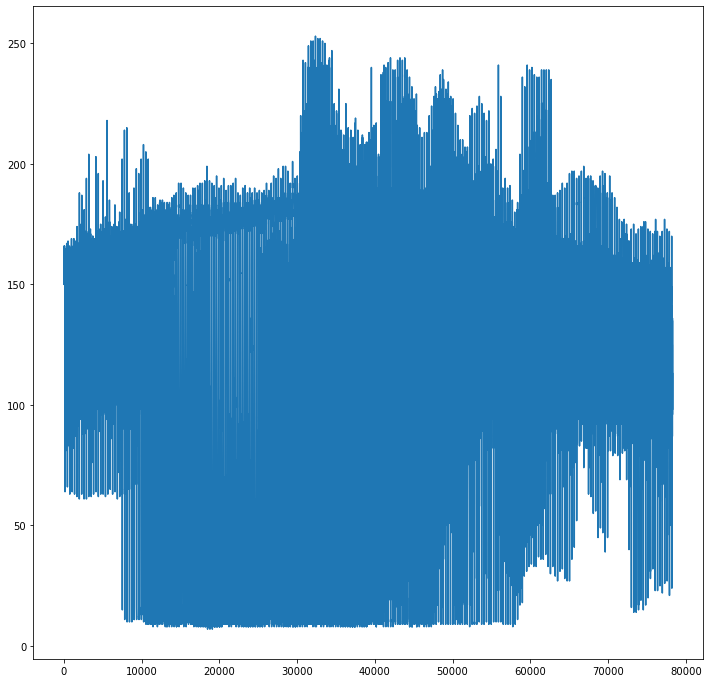

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import ssq_cwt, ssq_stft, experimental, Wavelet,icwt
plt.plot(serilized_x); plt.show()

  


In [27]:
efd, cerf, bounds = EFD(serilized_x,12) 


In [28]:
serilized_imfs = efd.transpose(1,0)

    #serilized_imfs = EMD()(serilized_x).T
print(f'concatenated imfs shape:\t{serilized_imfs.shape}')

    #imfs for each signal, [num_length, num_imf_modes, num_signal]
imfs = sdeconcatenate(serilized_imfs, num_interval, num_signal)
print(f'multi-dimensional imfs shape:\t{imfs.shape}')

concatenated imfs shape:	(78286, 13)
multi-dimensional imfs shape:	(256, 13, 256)


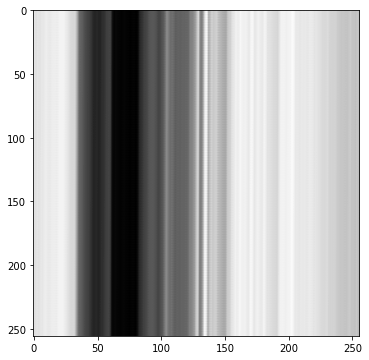

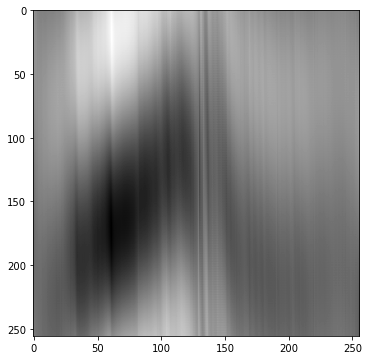

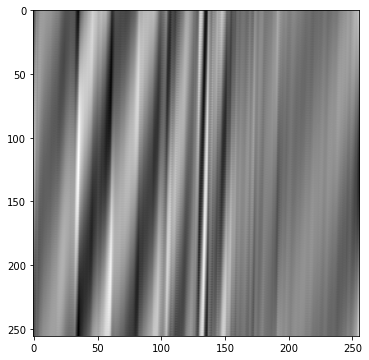

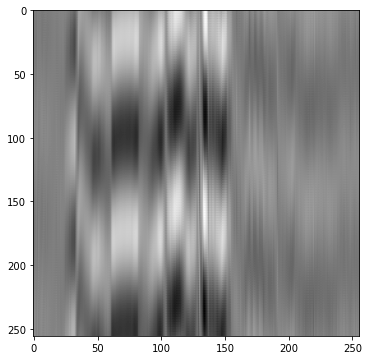

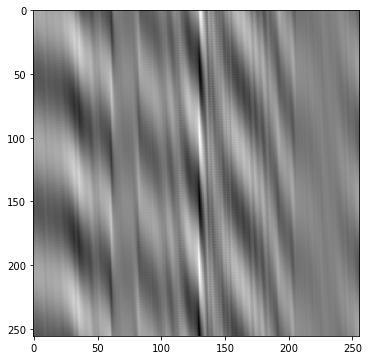

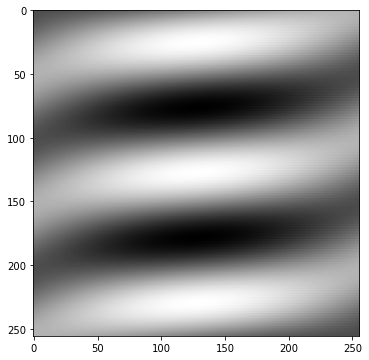

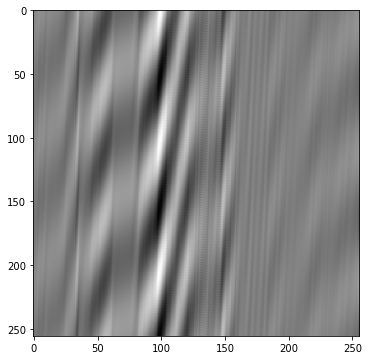

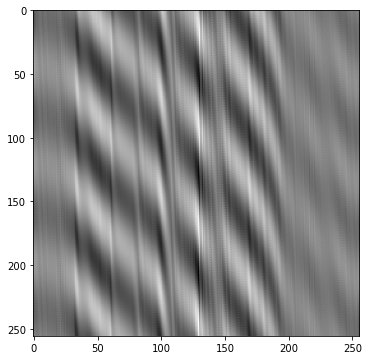

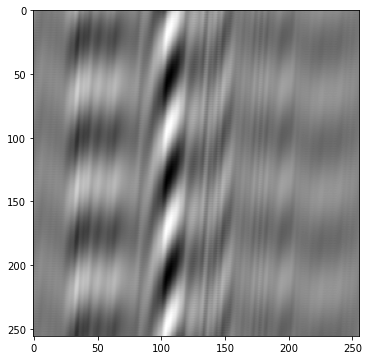

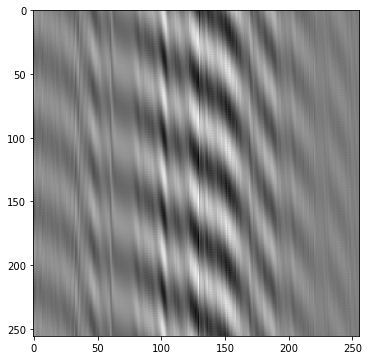

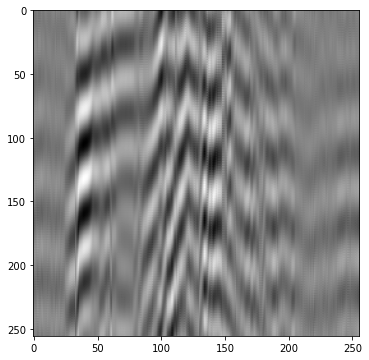

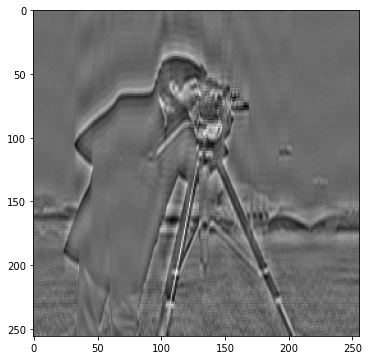

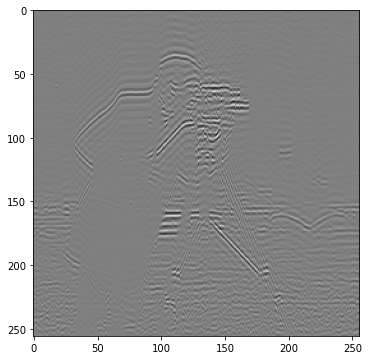

<Figure size 432x432 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

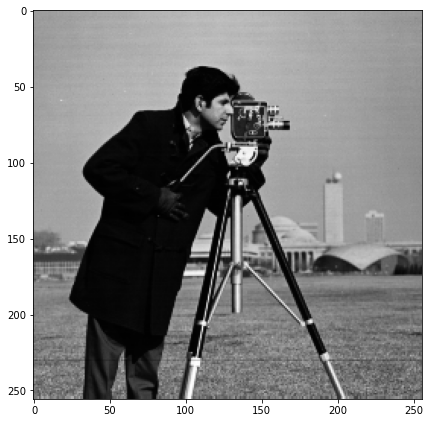

In [29]:
import math
import matplotlib.pyplot as plt


#imfs_cleaned = sdeconcatenate(serilized_imfs, num_interval, num_signal)

plt.rcParams["figure.figsize"] = (6,6)


for i in range(imfs.shape[1]):
        plt.imshow(imfs[:,i,:],cmap="gray")   
        plt.figure()

plt.tight_layout()
plt.show()
#[imfs_cleaned[:,row,:] for row in [0]]

a = np.apply_along_axis(math.fsum, 1, imfs)

plt.imshow(a,cmap="gray") #this is the re-combined output
plt.tight_layout()
plt.show



0.0


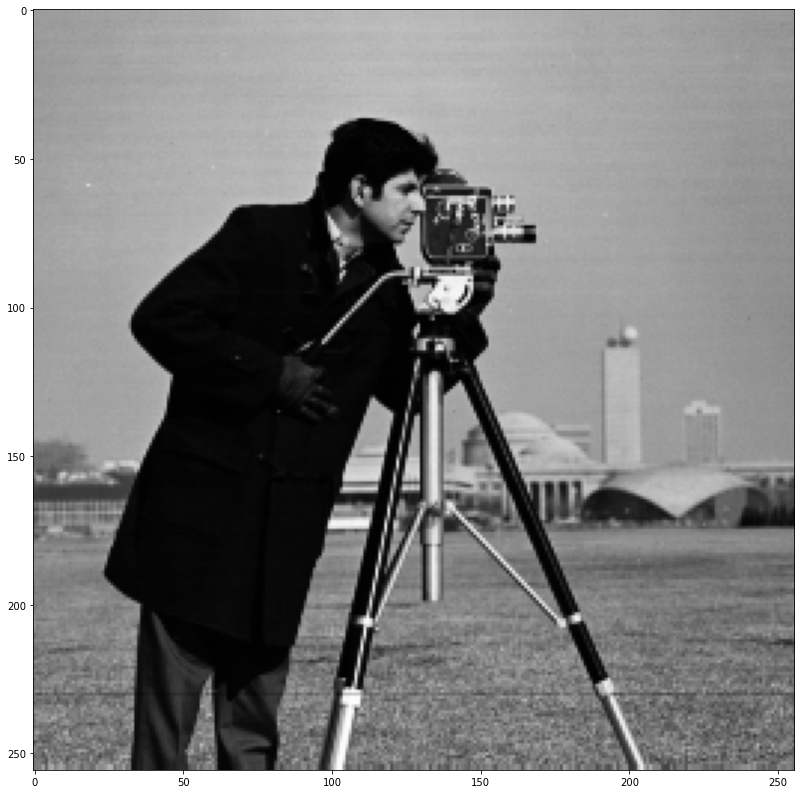

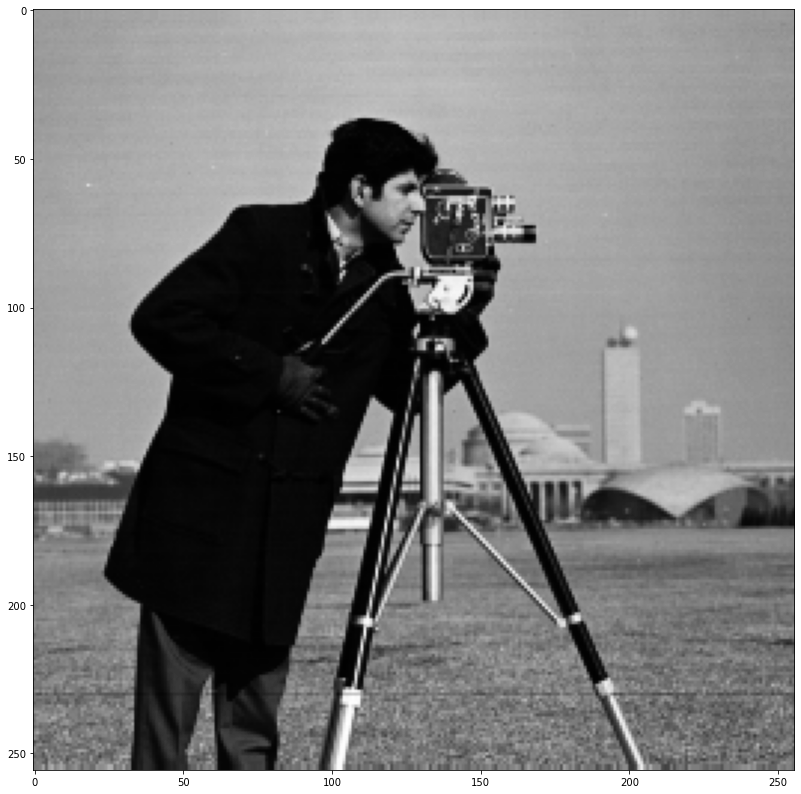

In [30]:
plt.rcParams["figure.figsize"] = (14,14)
plt.imshow(a,cmap="gray") 
plt.figure()
plt.rcParams["figure.figsize"] = (12,12)

plt.imshow(cameraman_image,cmap="gray") #this is the original image! output
plt.show
print((abs(numpy.sum(cameraman_image) - numpy.sum(a))))